In [111]:
import pickle,datetime
import pandas as pd
import numpy as np
import json
from rqalpha.api import *
from rqalpha import run_func
import multiprocessing
from matplotlib import rc
from matplotlib import pyplot as plt
from matplotlib import rcParams, gridspec, ticker, image as mpimg, pyplot as plt
from matplotlib.font_manager import findfont, FontProperties
import plotly.offline as py
import plotly.graph_objs as go
from ultron.factor.genetic.geneticist.operators import calc_factor
from alphamind.portfolio.linearbuilder import linear_builder
import warnings
warnings.filterwarnings("ignore")

In [2]:
industry_styles = ['Bank','RealEstate','Health','Transportation','Mining',
                                 'NonFerMetal','HouseApp','LeiService','MachiEquip','BuildDeco',
                                 'CommeTrade','CONMAT','Auto','Textile','FoodBever','Electronics',
                                 'Computer','LightIndus','Utilities','Telecom','AgriForest','CHEM',
                                 'Media','IronSteel','NonBankFinan','ELECEQP','AERODEF','Conglomerates']
risk_styles = ['BETA','MOMENTUM','SIZE','EARNYILD','RESVOL','GROWTH','BTOP',
                             'LEVERAGE','LIQUIDTY','SIZENL']

In [3]:
# return winsorized series
def se_winsorize(se, method='sigma', limits=(3.0, 3.0), drop=False):
    if method == 'quantile':
        down, up = se.quantile([limits[0], 1.0 - limits[1]])
    elif method == 'sigma':
        std, mean = se.std(), se.mean()
        down, up = mean - limits[0]*std, mean + limits[1]*std

    if drop:
        se[se<down] = np.NaN
        se[se>up] = np.NaN
    else:
        se[se<down] = down
        se[se>up] = up
    return se


# return standardized series
def se_standardize(se):
    try:
        res = (se - np.nanmean(se)) / np.nanstd(se)
    except:
        res = pd.Series(data=np.NaN, index=se.index)
    return res

def se_neutralize(total_data, risk_df):
    se = total_data.dropna()
    # se = total_data.copy()
    risk = risk_df.loc[se.index,:]
    # use numpy for neu, which is faster
    x = np.linalg.lstsq(risk.values, np.matrix(se).T)[0]
    se_neu = se - risk.dot(x)[0]
    return se_neu
    
def nan_rate(params):
    name = params['name']
    data = params['data']
    coverage_rate  =  1 - np.isnan(data).sum()/ len(data)
    return {'rate':coverage_rate,'name':name}

In [39]:
## 读取公共数据
with open('./index_component.pkl','rb') as file2:
    index_data = pickle.load(file2)

with open('./industry.pkl','rb') as file2:
    industry_data = pickle.load(file2)
    
#读取数据
universe = 'hs300'
with open('./' + str(universe) + '_fac_results.pkl','rb') as file2:
    fac_results = pickle.load(file2)
    
with open('./' + str(universe) + '_factor_data.pkl','rb') as file2:
    factor_data = pickle.load(file2)

with open('./' + str(universe) + '_return_data.pkl','rb') as file2:
    return_data = pickle.load(file2)
    
with open('./' + str(universe) + '_risk_data.pkl','rb') as file2:
    risk_data = pickle.load(file2)

In [5]:
factor_sets = fac_results.factor_name.to_list()  
total_data = factor_data.merge(risk_data, on=['code', 'trade_date'])
risk_styles = [i for i in risk_data.columns if i not in ['trade_date','code']]
industry_styles = ['Bank','RealEstate','Health','Transportation','Mining',
                                 'NonFerMetal','HouseApp','LeiService','MachiEquip','BuildDeco',
                                 'CommeTrade','CONMAT','Auto','Textile','FoodBever','Electronics',
                                 'Computer','LightIndus','Utilities','Telecom','AgriForest','CHEM',
                                 'Media','IronSteel','NonBankFinan','ELECEQP','AERODEF','Conglomerates']

ndiff_field = ['trade_date','code','ret'] + risk_styles

total_data = total_data.sort_values(by=['trade_date','code'],ascending=True)

total_data = total_data.set_index('trade_date'
                                 ).loc[total_data.trade_date.unique()[0:120]].reset_index()

#数据处理
alpha_res = []
grouped = total_data.groupby(['trade_date'])
for k, g in grouped:
    f = pd.DataFrame()
    for factor_name in factor_sets:
        f[factor_name] = se_standardize(se_winsorize(g[factor_name].values)) # 去极值->标准化
    for k in ndiff_field:
        f[k] = g[k].values
    alpha_res.append(f)
alpha_data = pd.concat(alpha_res)

factor_data_list = []
for name in factor_sets:
    factor_data_list.append({'name':name,'data':alpha_data[name].values})
    
with multiprocessing.Pool(processes=4) as p:
    values_list = p.map(nan_rate, factor_data_list)
factor_rate = pd.DataFrame(values_list)
factor_rate = factor_rate[factor_rate.rate > 0.65]
alpha_data = alpha_data[list(factor_rate.name) + ndiff_field]

## 均值处理Nan
alpha_res = []
grouped = total_data.groupby(['trade_date'])
for k, g in grouped:
    f = pd.DataFrame()
    for factor_name in factor_sets:
        factor_data = g[factor_name].values
        factor_data[np.isnan(factor_data)] = factor_data[~np.isnan(factor_data)].mean()
        f[factor_name] =factor_data
    for k in ndiff_field:
        f[k] = g[k].values
    alpha_res.append(f)
standard_data = pd.concat(alpha_res)

#移动收益率
def shift_ret(data):
    data = data.sort_values(by='trade_date',ascending=True)
    data['ret'] = data['ret'].shift(-1)
    return data.dropna(subset=['ret'])

now_data = standard_data.groupby(['code']).apply(shift_ret)

standard_data = now_data.set_index('code').reset_index().sort_values(by=['trade_date','code'],ascending=True)

In [6]:
name = '1570784435hs300_stm.pkl' 
with open('result/' + name ,'rb') as file2:
    fac_results = pickle.load(file2)

In [17]:
## 种群对应因子
factors_data = None
for i in range(0,3):
    formula = fac_results[0][i]['transform']
    factor_data = calc_factor(formula, standard_data, 'trade_date', 'code')
    factor_data = factor_data.rename(columns={'transformed':'ultron_' + str(i)}).reset_index()
    if factors_data is None:
        factors_data = factor_data
    else:
        factors_data = factors_data.merge(factor_data, on=['trade_date','code'])
factors_data = factors_data.set_index(['trade_date','code'])

In [24]:
## 行业风格中性化
def ultron_preprocessing(factor_data, name, risk_data, return_data):
    factor_se = factor_data[name]
    risk_se = risk_data.set_index(['trade_date','code'])
    forward_returns = shift_ret(return_data).set_index(['trade_date','code'])
    risk_df = risk_se.reindex(factor_se.index)[industry_styles + ['SIZE']]
    risk_df.dropna(inplace=True)
    factor_se = factor_se.loc[risk_df.index]
    returns = forward_returns.loc[risk_df.index]
    factor_se = factor_se.groupby(level='trade_date').apply(lambda x: se_winsorize(x,
                                                                    method='quantile',
                                                                    limits=(0.025, 0.025)))
    grouped = factor_se.groupby(level='trade_date')
    res = []
    for trade_date, g in grouped:
        neu = se_neutralize(g, risk_df)
        res.append(neu)
    factor_se = pd.concat(res, axis=0)
    factor_se = factor_se.groupby(level='trade_date').apply(lambda x: se_standardize(x))
    return factor_se.reset_index().rename(columns={0:name})

standard_data = None
for name in ultron_factor_name:
    df = ultron_preprocessing(factors_data, name, risk_data, return_data)
    if standard_data is None:
        standard_data = df
    else:
        standard_data = standard_data.merge(df, on=['trade_date','code'])

In [25]:
## 对称正交
class_mkt = standard_data[['trade_date','code']]
factors1 = standard_data.drop(['trade_date','code'],axis = 1)
col_name = factors1.columns     
D,U=np.linalg.eig(np.dot(factors1.T,factors1))
S = np.dot(U,np.diag(D**(-0.5)))
        
orthogonal_data = np.dot(factors1,S)
orthogonal_data = np.dot(orthogonal_data,U.T)
orthogonal_data = pd.DataFrame(orthogonal_data,columns = col_name,index = standard_data.index)
orthogonal_data = pd.concat([orthogonal_data,class_mkt],axis = 1)

In [26]:
## 因子合成
orthogonal_data['factors'] = orthogonal_data[['ultron_0','ultron_1','ultron_2']].mean(axis=1).values

In [50]:
#数据处理 去极值->标准化
alpha_res = []
grouped = orthogonal_data.groupby(['trade_date'])
for k, g in grouped:
    f = pd.DataFrame()
    f['neutralize_factor'] = se_standardize(se_winsorize(g['factors'].values)) # 去极值->标准化
    for k in ['code','trade_date']:
        f[k] = g[k].values
    alpha_res.append(f)
alpha_data = pd.concat(alpha_res)

In [69]:
index_component = index_data.set_index('indexCode').loc[300]
index_component = index_component.set_index('trade_date').loc[alpha_data.trade_date.unique()]

In [139]:
standard_data['neutralize_factor'] = standard_data['ultron_0'] 

In [140]:
#组合构造
neutralized_styles = ['SIZE'] + industry_styles
total_data = standard_data.merge(index_component,on=['code','trade_date'], how='outer').merge(
                                            risk_data,on=['code','trade_date'])
diff_field = ['trade_date','code','weight','neutralize_factor']
max_active_industry_exposure = 0.01  #行业主动暴露度，与基准的偏差暴露度
max_active_single_stock_exposure = 0.02 #个股主动暴露度及对个股暴露度上限进行约束
turn_over_target = 0.4
f_res = []
grouped = total_data.groupby('trade_date')
current_pos = None
for k, g in grouped:
    if current_pos is None:
        g1 = g
    else:
        g1 = g.merge(current_pos[['code','portfolio_weight']], on=['code'], how='left').fillna(0)
    er = g1.neutralize_factor.fillna(0).values
    industry_dummy = g1[neutralized_styles].values.astype(float)
    lbound = np.maximum(-max_active_single_stock_exposure, -g1['weight'].values)
    ubound = max_active_single_stock_exposure
    risk_constraints = np.concatenate((industry_dummy, np.ones((len(er), 1))), axis=1)
    industry_low_bounds = -max_active_industry_exposure * np.ones(industry_dummy.shape[1])
    industry_up_bounds = max_active_industry_exposure * np.ones(industry_dummy.shape[1])
    risk_target = (np.concatenate((industry_low_bounds, [-0.])),
                   np.concatenate((industry_up_bounds, [0.])),)
    
    if current_pos is None:
        status, optimized_values, weights = linear_builder(er,lbound,ubound,risk_constraints,
                                                           risk_target,turn_over_target)
    else:
        #做合并
        status, optimized_values, weights = linear_builder(er,lbound,ubound,risk_constraints,
                                                           risk_target,turn_over_target,
                                                           g1.portfolio_weight - g1.weight)
    f = pd.DataFrame(weights, columns=['active_weight'])
    for k in diff_field:
        f[k] = g[k].values
    f['portfolio_weight'] = f['weight'] + f['active_weight']
    current_pos = f[['portfolio_weight','code','trade_date']]
    f_res.append(f)
conmbine = pd.concat(f_res)
conmbine['code'] = conmbine['code'].apply(
                lambda x: "{:06d}".format(x) + '.XSHG' if len(str(x))==6 and str(x)[0] in '6' else "{:06d}".format(x)\
                + '.XSHE')
conmbine['trade_date'] = conmbine['trade_date'].apply(lambda x: x.date().strftime("%Y-%m-%d"))

In [141]:
class DailyDefaultStrategy(object):
    def __init__(self, session, stock_sets_ob):
        self._stock_sets_ob = json.loads(stock_sets_ob)
        self._session = session
        self._start_time_str = datetime.datetime.now().strftime('%m-%d %H:%M')
    
    
    def init(self,context):
        #读取股票池文件
        context.stock_sets = pd.DataFrame(self._stock_sets_ob)
        context.trade_date_list= list(set(context.stock_sets.trade_date))
        context.holding_stock_df = None
        
        # 是否已发送了order
        context.fired = False

    #盘前处理
    def before_trading(self, context, bar_dict):
        context.trade_signal = False
        date = context.now.date()
        if str(date) in context.trade_date_list:
            context.trade_signal = True

    #盘后处理
    def after_trading(self, context):
        pass
    
    # 你选择的证券的数据更新将会触发此段逻辑，例如日或分钟历史数据切片或者是实时数据切片更新
    def handle_bar(self, context, bar_dict):
        # 开始编写你的主要的算法逻辑
        if context.trade_signal == False:
            return
        date = context.now.date()
        stock_dict = context.stock_sets.set_index('trade_date').loc[str(date)]
        stock_df = self.filter_specials(stock_dict, context)
         #剔除后的股票
        if 'portfolio_weight' in list(set(stock_df.columns)):
            self.rebalance_weight(context, stock_df)
        else:
            self.rebalance_equal(context, stock_df)
   
    def _industry_distribute(self, stock_positions, industries):
        industry_sets_dict = {}
        industries = industries.rename(columns={'symbol':'code'})
        stock_positions = stock_positions.reset_index().rename(
            columns={'symbol':'name','order_book_id':'code','date':'trade_date'})
        stock_positions['trade_date'] = stock_positions['trade_date'].apply(lambda x: x.strftime('%Y-%m-%d'))
        industries['trade_date'] = industries['trade_date'].apply(lambda x: x.strftime('%Y-%m-%d'))
        stock_positions = stock_positions.merge(industries, on=['trade_date','code'])
        industry_grouped = stock_positions.dropna().groupby(['trade_date'])
        for k, g in industry_grouped:
            gt = g.groupby(['industry_code','industry']).count().reset_index()[['industry_code','industry','code']]
            gt['ratio'] = gt['code']/gt['code'].values.sum()
            gt=gt.rename(columns={'industry':'industry_name'})
            industry_sets_dict[k] = gt[['industry_code','industry_name','ratio']].to_dict(orient='records')
        return industry_sets_dict
    
    def _month_profit(self, portfolio, stock_capital):
        pd.DataFrame(portfolio.reset_index()).shift(1)
        month_profit = portfolio['total_value'].resample('M').mean()
        month_profit = pd.DataFrame(month_profit.reset_index())
        month_profit['last_total'] = month_profit['total_value'].shift(1)
        month_profit = month_profit.fillna(stock_capital)
        month_profit['month_ratio'] = np.log(month_profit.total_value / month_profit.last_total)
        return month_profit.rename(columns={'date':'trade_date'})
    
    def set_result(self, result):
        #summary 结算信息
        summary = result['sys_analyser']['summary']
        #trades 交易记录
        trades = result['sys_analyser']['trades']
        #portfolio 收益曲线
        portfolio = result['sys_analyser']['portfolio']
        # benchmark_portfolio 基础收益曲线benchmark_portfolio
        benchmark_portfolio = result['sys_analyser']['benchmark_portfolio']
        # stock_account 个人收益
        stock_account = result['sys_analyser']['stock_account']
        # stock_positions 股票持仓情况
        stock_positions = result['sys_analyser']['stock_positions']
        
        
    def filter_specials(self, stock_dict, context):
        stock_df = pd.DataFrame(stock_dict)
        stock_list = list(stock_df.code)
        stock_list=[stock for stock in stock_list]
        
        return stock_df.set_index('code').loc[stock_list,:] 
    
    def rebalance_equal(self, context, stock_df):
        holding_list = list(set(stock_df.index))
        if len(holding_list) > 0:
            every_stock = context.portfolio.portfolio_value/len(holding_list) 
        # 空仓只有买入操作
        if len(list(context.portfolio.positions.keys()))==0:
            for stock_to_buy in list(holding_list):
                #print(stock_to_buy)
                order_target_value(stock_to_buy,every_stock)
        else:
            for stock_to_sell in list(context.portfolio.positions.keys()):
                if stock_to_sell not in list(holding_list):
                    order_target_value(stock_to_sell, 0)
            for stock_to_buy in list(holding_list):
                order_target_value(stock_to_buy, every_stock)
                
        
    def rebalance_weight(self, context, stock_df):
        #没有持仓则全部下单
        if len(list(context.portfolio.positions.keys())) == 0:
            weight_sum = stock_df.portfolio_weight.sum()
            every_values = context.portfolio.total_value / weight_sum
            for index, weight in stock_df.iterrows():
                order_target_value(index, weight.portfolio_weight * every_values)
            context.holding_stock_df = stock_df
        else:
            now_df = context.holding_stock_df #当前持有的股票
            #做交集查看上次实际成交股票
            now_df = now_df.loc[context.portfolio.stock_account.positions.keys()]
            now_df = now_df.rename(columns={'portfolio_weight':'now_weight'}) #持仓
            #做并集
            stock_df = stock_df.rename(columns={'portfolio_weight':'next_weight'}) #调仓
            now_df = pd.merge(now_df, stock_df, left_index=True, right_index=True, how='outer')
            now_df = now_df.fillna(0)
            now_df['diff_weight'] = now_df.next_weight - now_df.now_weight #调仓股票和持仓股票进行对比
            buy_stock = now_df[now_df['diff_weight'] > 0] #当前需买进
            sell_stock = now_df[now_df['diff_weight'] < 0]
            
            #根据当前权重分配，目的是持仓达到和调仓的权重一样
            weight_sum = stock_df.next_weight.sum()
            every_values = context.portfolio.total_value/ weight_sum
            
            #平掉不需要股票
            for index, weight in sell_stock.iterrows():
                if weight.now_weight == abs(weight.diff_weight): #全部清仓
                    order_target_value(index, 0)
                else:#调整权重，此处会有误差，每期的every_values不一样
                    order_target_value(index, weight.diff_weight * every_values)
            #新建增仓
            for index, weight in buy_stock.iterrows():
                order_target_value(index, abs(weight.diff_weight) * every_values)
            stock_df = stock_df.rename(columns={'next_weight':'portfolio_weight'})
            context.holding_stock_df = stock_df         

In [142]:
backtesting = DailyDefaultStrategy(1234412, 
                json.dumps(conmbine.to_dict(orient='records')))

In [143]:
benchmark_info = '000300.XSHG'
trade_date_list = list(set(conmbine.trade_date))
trade_date_list.sort(reverse=False)
base_config = {}
base_config['start_date'] = trade_date_list[0]
base_config['end_date'] = trade_date_list[-1]
base_config['benchmark'] = benchmark_info
            
accounts_config = {}
accounts_config['stock'] = 100000000
base_config['accounts'] = accounts_config
base_config['frequency'] = '1d'
base_config['skip_suspended'] = True
    
extra_config = {}
        
mod_config = {}
sys_analyser_config = {}
sys_analyser_config['enabled'] = True
sys_analyser_config['plot'] = False
mod_config['sys_analyser'] = sys_analyser_config
        
config = {}
config['base'] = base_config
config['extra'] = extra_config
config['mod'] = mod_config
result = run_func(init=backtesting.init, before_trading=backtesting.before_trading,
                  after_trading=backtesting.after_trading, handle_bar=backtesting.handle_bar,
                  config=config)

2016-01-04 WARN [Deprecated]在before_trading函数中，第二个参数bar_dict已经不再使用了。
2016-01-04 WARN 订单创建失败: 下单量为0
2016-01-04 WARN 订单创建失败: 下单量为0
2016-01-04 WARN 订单创建失败: 下单量为0
2016-01-04 WARN 订单创建失败: 下单量为0
2016-01-04 WARN 订单创建失败: 下单量为0
2016-01-04 WARN 订单创建失败: 下单量为0
2016-01-04 WARN 订单创建失败: 下单量为0
2016-01-04 WARN 订单创建失败: 下单量为0
2016-01-04 WARN 订单创建失败: 下单量为0
2016-01-04 WARN 订单创建失败: 下单量为0
2016-01-04 WARN 订单创建失败: 下单量为0
2016-01-04 WARN 订单创建失败: 下单量为0
2016-01-04 WARN 订单创建失败: 下单量为0
2016-01-04 WARN 订单创建失败: 下单量为0
2016-01-04 WARN 订单创建失败: 下单量为0
2016-01-04 WARN 订单创建失败: 下单量为0
2016-01-04 WARN 订单创建失败: 下单量为0
2016-01-04 WARN 订单创建失败: 下单量为0
2016-01-04 WARN 订单创建失败: 下单量为0
2016-01-04 WARN 订单创建失败: 下单量为0
2016-01-04 WARN 订单创建失败: 下单量为0
2016-01-04 WARN 订单创建失败: 下单量为0
2016-01-04 WARN 订单创建失败: 下单量为0
2016-01-04 WARN 订单创建失败: 下单量为0
2016-01-04 WARN 订单创建失败: 下单量为0
2016-01-04 WARN 订单创建失败: 下单量为0
2016-01-04 WARN 订单创建失败: 下单量为0
2016-01-04 WARN 订单创建失败: 下单量为0
2016-01-04 WARN 订单创建失败: 下单量为0
2016-01-04 WARN 订单创建失败: 下单量为0
2016-01-04 WARN 订单创建失败: 下单量为0
2

2016-01-11 WARN 订单创建失败: 下单量为0
2016-01-11 WARN 订单创建失败: 下单量为0
2016-01-11 WARN 订单创建失败: 下单量为0
2016-01-11 WARN 订单创建失败: 下单量为0
2016-01-11 WARN 订单创建失败: 下单量为0
2016-01-11 WARN 订单创建失败: 下单量为0
2016-01-11 WARN 订单创建失败: 下单量为0
2016-01-11 WARN 订单被拒单: [002673.XSHE] 已跌停。
2016-01-11 WARN 订单创建失败: 下单量为0
2016-01-11 WARN 订单创建失败: 下单量为0
2016-01-11 WARN 订单创建失败: 下单量为0
2016-01-11 WARN 订单创建失败: 下单量为0
2016-01-11 WARN 订单创建失败: 下单量为0
2016-01-11 WARN 订单创建失败: 下单量为0
2016-01-11 WARN 订单创建失败: 下单量为0
2016-01-11 WARN 订单创建失败: 下单量为0
2016-01-11 WARN 订单创建失败: 下单量为0
2016-01-11 WARN 订单创建失败: 下单量为0
2016-01-11 WARN 订单创建失败: 下单量为0
2016-01-11 WARN 订单创建失败: 下单量为0
2016-01-11 WARN 订单创建失败: 下单量为0
2016-01-11 WARN 订单创建失败: 下单量为0
2016-01-11 WARN 订单创建失败: 下单量为0
2016-01-11 WARN 订单创建失败: 下单量为0
2016-01-11 WARN 订单创建失败: 下单量为0
2016-01-11 WARN 订单创建失败: 下单量为0
2016-01-11 WARN 订单创建失败: 下单量为0
2016-01-11 WARN 订单创建失败: 下单量为0
2016-01-11 WARN 订单创建失败: 下单量为0
2016-01-11 WARN 订单创建失败: 下单量为0
2016-01-11 WARN 订单创建失败: 下单量为0
2016-01-11 WARN 订单创建失败: 下单量为0
2016-01-11 WARN 订单创建失败: 下单量为

2016-01-18 WARN 订单创建失败: 下单量为0
2016-01-18 WARN 订单创建失败: 下单量为0
2016-01-18 WARN 订单创建失败: 下单量为0
2016-01-18 WARN 订单创建失败: 下单量为0
2016-01-18 WARN 订单创建失败: 下单量为0
2016-01-18 WARN 订单创建失败: 下单量为0
2016-01-18 WARN 订单创建失败: 下单量为0
2016-01-18 WARN 订单创建失败: 下单量为0
2016-01-18 WARN 订单创建失败: 下单量为0
2016-01-18 WARN 订单创建失败: 下单量为0
2016-01-18 WARN 订单创建失败: 下单量为0
2016-01-18 WARN 订单创建失败: 下单量为0
2016-01-18 WARN 订单创建失败: 下单量为0
2016-01-18 WARN 订单创建失败: 下单量为0
2016-01-18 WARN 订单创建失败: 下单量为0
2016-01-18 WARN 订单创建失败: 下单量为0
2016-01-18 WARN 订单创建失败: 下单量为0
2016-01-18 WARN 订单创建失败: 下单量为0
2016-01-18 WARN 订单创建失败: 下单量为0
2016-01-18 WARN 订单创建失败: 下单量为0
2016-01-18 WARN 订单创建失败: 下单量为0
2016-01-18 WARN 订单创建失败: 下单量为0
2016-01-18 WARN 订单创建失败: 下单量为0
2016-01-18 WARN 订单创建失败: 下单量为0
2016-01-18 WARN 订单创建失败: 下单量为0
2016-01-18 WARN 订单创建失败: 下单量为0
2016-01-18 WARN 订单创建失败: 下单量为0
2016-01-18 WARN 订单创建失败: 下单量为0
2016-01-18 WARN 订单创建失败: 下单量为0
2016-01-18 WARN 订单创建失败: 下单量为0
2016-01-18 WARN 订单创建失败: 下单量为0
2016-01-18 WARN 订单创建失败: 下单量为0
2016-01-18 WARN 订单创建失败: 下单量为0
2016-01-18

2016-01-25 WARN 订单创建失败: 下单量为0
2016-01-25 WARN 订单创建失败: 下单量为0
2016-01-25 WARN 订单创建失败: 下单量为0
2016-01-25 WARN 订单创建失败: 下单量为0
2016-01-25 WARN 订单创建失败: 下单量为0
2016-01-25 WARN 订单创建失败: 下单量为0
2016-01-25 WARN 订单创建失败: 下单量为0
2016-01-25 WARN 订单创建失败: 下单量为0
2016-01-25 WARN 订单创建失败: 下单量为0
2016-01-25 WARN 订单创建失败: 下单量为0
2016-01-25 WARN 订单创建失败: 下单量为0
2016-01-25 WARN 订单创建失败: 下单量为0
2016-01-25 WARN 订单创建失败: 下单量为0
2016-01-25 WARN 订单创建失败: 下单量为0
2016-01-25 WARN 订单创建失败: 下单量为0
2016-01-25 WARN 订单创建失败: 下单量为0
2016-01-25 WARN 订单创建失败: 下单量为0
2016-01-25 WARN 订单创建失败: 下单量为0
2016-01-25 WARN 订单创建失败: 下单量为0
2016-01-25 WARN 订单创建失败: 下单量为0
2016-01-25 WARN 订单创建失败: 下单量为0
2016-01-25 WARN 订单创建失败: 下单量为0
2016-01-25 WARN 订单创建失败: 下单量为0
2016-01-25 WARN 订单创建失败: 下单量为0
2016-01-25 WARN 订单创建失败: 下单量为0
2016-01-25 WARN 订单创建失败: 下单量为0
2016-01-25 WARN 订单创建失败: 下单量为0
2016-01-25 WARN 订单创建失败: 下单量为0
2016-01-25 WARN 订单创建失败: 下单量为0
2016-01-25 WARN 订单创建失败: 下单量为0
2016-01-25 WARN 订单创建失败: 下单量为0
2016-01-25 WARN 订单创建失败: 下单量为0
2016-01-25 WARN 订单创建失败: 下单量为0
2016-01-25

2016-02-01 WARN 订单创建失败: 下单量为0
2016-02-01 WARN 订单创建失败: 下单量为0
2016-02-01 WARN 订单创建失败: 下单量为0
2016-02-01 WARN 订单创建失败: 下单量为0
2016-02-01 WARN 订单创建失败: 下单量为0
2016-02-01 WARN 订单创建失败: 下单量为0
2016-02-01 WARN 订单创建失败: 下单量为0
2016-02-01 WARN 订单创建失败: 下单量为0
2016-02-01 WARN 订单创建失败: 下单量为0
2016-02-01 WARN 订单创建失败: 下单量为0
2016-02-01 WARN 订单创建失败: 下单量为0
2016-02-01 WARN 订单创建失败: 下单量为0
2016-02-01 WARN 订单创建失败: 下单量为0
2016-02-01 WARN 订单创建失败: 下单量为0
2016-02-01 WARN 订单创建失败: 下单量为0
2016-02-01 WARN 订单创建失败: 下单量为0
2016-02-01 WARN 订单创建失败: 下单量为0
2016-02-01 WARN 订单创建失败: 下单量为0
2016-02-01 WARN 订单创建失败: 下单量为0
2016-02-01 WARN 订单创建失败: 下单量为0
2016-02-01 WARN 订单创建失败: 下单量为0
2016-02-01 WARN 订单创建失败: 下单量为0
2016-02-01 WARN 订单创建失败: 下单量为0
2016-02-01 WARN 订单创建失败: 下单量为0
2016-02-01 WARN 订单创建失败: 下单量为0
2016-02-01 WARN 订单创建失败: 下单量为0
2016-02-01 WARN 订单创建失败: 下单量为0
2016-02-01 WARN 订单创建失败: 下单量为0
2016-02-01 WARN 订单创建失败: 300104.XSHE 在 2016-02-01 15:00:00 时停牌
2016-02-01 WARN 订单创建失败: 下单量为0
2016-02-01 WARN 订单创建失败: 下单量为0
2016-02-01 WARN 订单创建失败: 下单量为0
2016-02-

2016-02-15 WARN 订单创建失败: 下单量为0
2016-02-15 WARN 订单创建失败: 下单量为0
2016-02-15 WARN 订单创建失败: 下单量为0
2016-02-15 WARN 订单创建失败: 下单量为0
2016-02-15 WARN 订单创建失败: 下单量为0
2016-02-15 WARN 订单创建失败: 下单量为0
2016-02-15 WARN 订单创建失败: 下单量为0
2016-02-15 WARN 订单创建失败: 下单量为0
2016-02-15 WARN 订单创建失败: 下单量为0
2016-02-15 WARN 订单创建失败: 下单量为0
2016-02-15 WARN 订单创建失败: 下单量为0
2016-02-15 WARN 订单创建失败: 下单量为0
2016-02-15 WARN 订单创建失败: 下单量为0
2016-02-15 WARN 订单创建失败: 下单量为0
2016-02-15 WARN 订单创建失败: 下单量为0
2016-02-15 WARN 订单创建失败: 下单量为0
2016-02-15 WARN 订单创建失败: 下单量为0
2016-02-15 WARN 订单创建失败: 下单量为0
2016-02-15 WARN 订单创建失败: 下单量为0
2016-02-15 WARN 订单创建失败: 下单量为0
2016-02-15 WARN 订单创建失败: 下单量为0
2016-02-15 WARN 订单创建失败: 下单量为0
2016-02-15 WARN 订单创建失败: 下单量为0
2016-02-15 WARN 订单创建失败: 下单量为0
2016-02-15 WARN 订单创建失败: 下单量为0
2016-02-15 WARN 订单创建失败: 下单量为0
2016-02-15 WARN 订单创建失败: 下单量为0
2016-02-15 WARN 订单创建失败: 下单量为0
2016-02-15 WARN 订单创建失败: 下单量为0
2016-02-15 WARN 订单创建失败: 下单量为0
2016-02-15 WARN 订单创建失败: 下单量为0
2016-02-15 WARN 订单创建失败: 下单量为0
2016-02-15 WARN 订单创建失败: 下单量为0
2016-02-15

2016-02-22 WARN 订单创建失败: 下单量为0
2016-02-22 WARN 订单创建失败: 下单量为0
2016-02-22 WARN 订单创建失败: 下单量为0
2016-02-22 WARN 订单创建失败: 下单量为0
2016-02-22 WARN 订单创建失败: 下单量为0
2016-02-22 WARN 订单创建失败: 下单量为0
2016-02-22 WARN 订单创建失败: 下单量为0
2016-02-22 WARN 订单创建失败: 下单量为0
2016-02-22 WARN 订单创建失败: 下单量为0
2016-02-22 WARN 订单创建失败: 下单量为0
2016-02-22 WARN 订单创建失败: 下单量为0
2016-02-22 WARN 订单创建失败: 下单量为0
2016-02-22 WARN 订单创建失败: 下单量为0
2016-02-22 WARN 订单创建失败: 下单量为0
2016-02-22 WARN 订单创建失败: 下单量为0
2016-02-22 WARN 订单创建失败: 下单量为0
2016-02-22 WARN 订单创建失败: 下单量为0
2016-02-22 WARN 订单创建失败: 下单量为0
2016-02-22 WARN 订单创建失败: 下单量为0
2016-02-22 WARN 订单创建失败: 下单量为0
2016-02-22 WARN 订单创建失败: 下单量为0
2016-02-22 WARN 订单创建失败: 下单量为0
2016-02-22 WARN 订单创建失败: 下单量为0
2016-02-22 WARN 订单创建失败: 下单量为0
2016-02-22 WARN 订单创建失败: 下单量为0
2016-02-22 WARN 订单创建失败: 下单量为0
2016-02-22 WARN 订单创建失败: 下单量为0
2016-02-29 WARN 订单创建失败: 下单量为0
2016-02-29 WARN 订单创建失败: 下单量为0
2016-02-29 WARN 订单创建失败: 下单量为0
2016-02-29 WARN 订单创建失败: 下单量为0
2016-02-29 WARN 订单创建失败: 下单量为0
2016-02-29 WARN 订单创建失败: 下单量为0
2016-02-29

2016-03-07 WARN 订单创建失败: 下单量为0
2016-03-07 WARN 订单创建失败: 下单量为0
2016-03-07 WARN 订单创建失败: 下单量为0
2016-03-07 WARN 订单创建失败: 下单量为0
2016-03-07 WARN 订单创建失败: 下单量为0
2016-03-07 WARN 订单创建失败: 下单量为0
2016-03-07 WARN 订单创建失败: 下单量为0
2016-03-07 WARN 订单创建失败: 下单量为0
2016-03-07 WARN 订单创建失败: 下单量为0
2016-03-07 WARN 订单创建失败: 下单量为0
2016-03-07 WARN 订单创建失败: 下单量为0
2016-03-07 WARN 订单创建失败: 下单量为0
2016-03-07 WARN 订单创建失败: 下单量为0
2016-03-07 WARN 订单创建失败: 下单量为0
2016-03-07 WARN 订单创建失败: 下单量为0
2016-03-07 WARN 订单创建失败: 下单量为0
2016-03-07 WARN 订单创建失败: 下单量为0
2016-03-07 WARN 订单创建失败: 下单量为0
2016-03-07 WARN 订单创建失败: 下单量为0
2016-03-07 WARN 订单创建失败: 下单量为0
2016-03-07 WARN 订单创建失败: 下单量为0
2016-03-07 WARN 订单创建失败: 下单量为0
2016-03-07 WARN 订单创建失败: 下单量为0
2016-03-07 WARN 订单创建失败: 下单量为0
2016-03-07 WARN 订单创建失败: 下单量为0
2016-03-07 WARN 订单创建失败: 下单量为0
2016-03-07 WARN 订单创建失败: 下单量为0
2016-03-07 WARN 订单创建失败: 下单量为0
2016-03-07 WARN 订单创建失败: 下单量为0
2016-03-07 WARN 订单创建失败: 下单量为0
2016-03-07 WARN 订单创建失败: 下单量为0
2016-03-07 WARN 订单创建失败: 下单量为0
2016-03-07 WARN 订单创建失败: 下单量为0
2016-03-07

2016-03-14 WARN 订单创建失败: 下单量为0
2016-03-14 WARN 订单创建失败: 下单量为0
2016-03-14 WARN 订单创建失败: 下单量为0
2016-03-14 WARN 订单创建失败: 下单量为0
2016-03-14 WARN 订单创建失败: 下单量为0
2016-03-14 WARN 订单创建失败: 下单量为0
2016-03-14 WARN 订单创建失败: 下单量为0
2016-03-14 WARN 订单创建失败: 下单量为0
2016-03-14 WARN 订单创建失败: 下单量为0
2016-03-14 WARN 订单创建失败: 下单量为0
2016-03-14 WARN 订单创建失败: 下单量为0
2016-03-14 WARN 订单创建失败: 下单量为0
2016-03-14 WARN 订单创建失败: 下单量为0
2016-03-14 WARN 订单创建失败: 下单量为0
2016-03-14 WARN 订单创建失败: 下单量为0
2016-03-14 WARN 订单创建失败: 下单量为0
2016-03-14 WARN 订单创建失败: 下单量为0
2016-03-14 WARN 订单创建失败: 下单量为0
2016-03-14 WARN 订单创建失败: 下单量为0
2016-03-14 WARN 订单创建失败: 下单量为0
2016-03-14 WARN 订单创建失败: 下单量为0
2016-03-14 WARN 订单创建失败: 下单量为0
2016-03-14 WARN 订单创建失败: 下单量为0
2016-03-14 WARN 订单创建失败: 下单量为0
2016-03-14 WARN 订单创建失败: 下单量为0
2016-03-14 WARN 订单创建失败: 下单量为0
2016-03-14 WARN 订单创建失败: 下单量为0
2016-03-14 WARN 订单创建失败: 下单量为0
2016-03-14 WARN 订单创建失败: 下单量为0
2016-03-14 WARN 订单创建失败: 下单量为0
2016-03-14 WARN 订单创建失败: 下单量为0
2016-03-14 WARN 订单创建失败: 下单量为0
2016-03-14 WARN 订单创建失败: 下单量为0
2016-03-14

2016-03-21 WARN 订单创建失败: 下单量为0
2016-03-21 WARN 订单创建失败: 下单量为0
2016-03-21 WARN 订单创建失败: 下单量为0
2016-03-21 WARN 订单创建失败: 下单量为0
2016-03-21 WARN 订单创建失败: 下单量为0
2016-03-21 WARN 订单创建失败: 下单量为0
2016-03-21 WARN 订单创建失败: 下单量为0
2016-03-21 WARN 订单创建失败: 600663.XSHG 在 2016-03-21 15:00:00 时停牌
2016-03-21 WARN 订单创建失败: 下单量为0
2016-03-21 WARN 订单创建失败: 下单量为0
2016-03-21 WARN 订单创建失败: 下单量为0
2016-03-21 WARN 订单创建失败: 下单量为0
2016-03-21 WARN 订单创建失败: 下单量为0
2016-03-21 WARN 订单创建失败: 下单量为0
2016-03-21 WARN 订单创建失败: 下单量为0
2016-03-21 WARN 订单创建失败: 下单量为0
2016-03-21 WARN 订单创建失败: 下单量为0
2016-03-21 WARN 订单创建失败: 下单量为0
2016-03-21 WARN 订单创建失败: 下单量为0
2016-03-21 WARN 订单创建失败: 下单量为0
2016-03-21 WARN 订单创建失败: 下单量为0
2016-03-21 WARN 订单创建失败: 下单量为0
2016-03-21 WARN 订单创建失败: 下单量为0
2016-03-21 WARN 订单创建失败: 下单量为0
2016-03-21 WARN 订单创建失败: 下单量为0
2016-03-21 WARN 订单创建失败: 下单量为0
2016-03-21 WARN 订单创建失败: 下单量为0
2016-03-21 WARN 订单创建失败: 下单量为0
2016-03-21 WARN 订单创建失败: 下单量为0
2016-03-21 WARN 订单创建失败: 下单量为0
2016-03-21 WARN 订单创建失败: 下单量为0
2016-03-21 WARN 订单创建失败: 下单量为0
2016-03-

2016-03-28 WARN 订单创建失败: 下单量为0
2016-03-28 WARN 订单创建失败: 下单量为0
2016-03-28 WARN 订单创建失败: 下单量为0
2016-03-28 WARN 订单创建失败: 下单量为0
2016-03-28 WARN 订单创建失败: 下单量为0
2016-03-28 WARN 订单创建失败: 下单量为0
2016-03-28 WARN 订单创建失败: 下单量为0
2016-03-28 WARN 订单创建失败: 下单量为0
2016-03-28 WARN 订单创建失败: 下单量为0
2016-03-28 WARN 订单创建失败: 下单量为0
2016-03-28 WARN 订单创建失败: 下单量为0
2016-03-28 WARN 订单创建失败: 下单量为0
2016-03-28 WARN 订单创建失败: 下单量为0
2016-03-28 WARN 订单创建失败: 下单量为0
2016-03-28 WARN 订单创建失败: 下单量为0
2016-03-28 WARN 订单创建失败: 下单量为0
2016-03-28 WARN 订单创建失败: 下单量为0
2016-03-28 WARN 订单创建失败: 下单量为0
2016-03-28 WARN 订单创建失败: 下单量为0
2016-03-28 WARN 订单创建失败: 下单量为0
2016-03-28 WARN 订单创建失败: 下单量为0
2016-03-28 WARN 订单创建失败: 000002.XSHE 在 2016-03-28 15:00:00 时停牌
2016-03-28 WARN 订单创建失败: 下单量为0
2016-03-28 WARN 订单创建失败: 下单量为0
2016-03-28 WARN 订单创建失败: 下单量为0
2016-03-28 WARN 订单创建失败: 下单量为0
2016-03-28 WARN 订单创建失败: 下单量为0
2016-03-28 WARN 订单创建失败: 000415.XSHE 在 2016-03-28 15:00:00 时停牌
2016-03-28 WARN 订单创建失败: 下单量为0
2016-03-28 WARN 订单创建失败: 下单量为0
2016-03-28 WARN 订单创建失败: 下单量为0
2016-0

2016-04-05 WARN 订单创建失败: 下单量为0
2016-04-05 WARN 订单创建失败: 下单量为0
2016-04-05 WARN 订单创建失败: 下单量为0
2016-04-05 WARN 订单创建失败: 下单量为0
2016-04-05 WARN 订单创建失败: 下单量为0
2016-04-05 WARN 订单创建失败: 下单量为0
2016-04-05 WARN 订单创建失败: 下单量为0
2016-04-05 WARN 订单创建失败: 下单量为0
2016-04-05 WARN 订单创建失败: 下单量为0
2016-04-05 WARN 订单创建失败: 下单量为0
2016-04-05 WARN 订单创建失败: 下单量为0
2016-04-05 WARN 订单创建失败: 下单量为0
2016-04-05 WARN 订单创建失败: 下单量为0
2016-04-05 WARN 订单创建失败: 下单量为0
2016-04-05 WARN 订单创建失败: 下单量为0
2016-04-05 WARN 订单创建失败: 下单量为0
2016-04-05 WARN 订单创建失败: 下单量为0
2016-04-05 WARN 订单创建失败: 002739.XSHE 在 2016-04-05 15:00:00 时停牌
2016-04-05 WARN 订单创建失败: 下单量为0
2016-04-05 WARN 订单创建失败: 下单量为0
2016-04-05 WARN 订单创建失败: 下单量为0
2016-04-05 WARN 订单创建失败: 下单量为0
2016-04-05 WARN 订单创建失败: 下单量为0
2016-04-05 WARN 订单创建失败: 下单量为0
2016-04-05 WARN 订单创建失败: 300104.XSHE 在 2016-04-05 15:00:00 时停牌
2016-04-05 WARN 订单创建失败: 下单量为0
2016-04-05 WARN 订单创建失败: 下单量为0
2016-04-05 WARN 订单创建失败: 下单量为0
2016-04-05 WARN 订单创建失败: 下单量为0
2016-04-05 WARN 订单创建失败: 下单量为0
2016-04-05 WARN 订单创建失败: 下单量为0
2016-0

2016-04-12 WARN 订单创建失败: 下单量为0
2016-04-12 WARN 订单创建失败: 下单量为0
2016-04-12 WARN 订单创建失败: 下单量为0
2016-04-12 WARN 订单创建失败: 下单量为0
2016-04-12 WARN 订单创建失败: 下单量为0
2016-04-12 WARN 订单创建失败: 下单量为0
2016-04-12 WARN 订单创建失败: 下单量为0
2016-04-12 WARN 订单创建失败: 下单量为0
2016-04-12 WARN 订单创建失败: 下单量为0
2016-04-12 WARN 订单创建失败: 下单量为0
2016-04-12 WARN 订单创建失败: 下单量为0
2016-04-12 WARN 订单创建失败: 下单量为0
2016-04-12 WARN 订单创建失败: 下单量为0
2016-04-12 WARN 订单创建失败: 下单量为0
2016-04-12 WARN 订单创建失败: 下单量为0
2016-04-12 WARN 订单创建失败: 下单量为0
2016-04-12 WARN 订单创建失败: 下单量为0
2016-04-12 WARN 订单创建失败: 下单量为0
2016-04-12 WARN 订单创建失败: 下单量为0
2016-04-12 WARN 订单创建失败: 下单量为0
2016-04-12 WARN 订单创建失败: 下单量为0
2016-04-12 WARN 订单创建失败: 下单量为0
2016-04-12 WARN 订单创建失败: 下单量为0
2016-04-12 WARN 订单创建失败: 下单量为0
2016-04-12 WARN 订单创建失败: 下单量为0
2016-04-12 WARN 订单创建失败: 下单量为0
2016-04-12 WARN 订单创建失败: 下单量为0
2016-04-12 WARN 订单创建失败: 下单量为0
2016-04-12 WARN 订单创建失败: 下单量为0
2016-04-12 WARN 订单创建失败: 下单量为0
2016-04-12 WARN 订单创建失败: 下单量为0
2016-04-12 WARN 订单创建失败: 下单量为0
2016-04-12 WARN 订单创建失败: 下单量为0
2016-04-12

2016-04-26 WARN 订单创建失败: 下单量为0
2016-04-26 WARN 订单创建失败: 下单量为0
2016-04-26 WARN 订单创建失败: 下单量为0
2016-04-26 WARN 订单创建失败: 下单量为0
2016-04-26 WARN 订单创建失败: 下单量为0
2016-04-26 WARN 订单创建失败: 下单量为0
2016-04-26 WARN 订单创建失败: 下单量为0
2016-04-26 WARN 订单创建失败: 下单量为0
2016-04-26 WARN 订单创建失败: 下单量为0
2016-04-26 WARN 订单创建失败: 下单量为0
2016-04-26 WARN 订单创建失败: 下单量为0
2016-04-26 WARN 订单创建失败: 下单量为0
2016-04-26 WARN 订单创建失败: 下单量为0
2016-04-26 WARN 订单创建失败: 下单量为0
2016-04-26 WARN 订单创建失败: 下单量为0
2016-04-26 WARN 订单创建失败: 下单量为0
2016-04-26 WARN 订单创建失败: 下单量为0
2016-04-26 WARN 订单创建失败: 下单量为0
2016-04-26 WARN 订单创建失败: 下单量为0
2016-04-26 WARN 订单创建失败: 下单量为0
2016-04-26 WARN 订单创建失败: 下单量为0
2016-04-26 WARN 订单创建失败: 下单量为0
2016-04-26 WARN 订单创建失败: 下单量为0
2016-04-26 WARN 订单创建失败: 下单量为0
2016-04-26 WARN 订单创建失败: 下单量为0
2016-04-26 WARN 订单创建失败: 下单量为0
2016-04-26 WARN 订单创建失败: 下单量为0
2016-04-26 WARN 订单创建失败: 下单量为0
2016-04-26 WARN 订单创建失败: 下单量为0
2016-04-26 WARN 订单创建失败: 下单量为0
2016-04-26 WARN 订单创建失败: 002739.XSHE 在 2016-04-26 15:00:00 时停牌
2016-04-26 WARN 订单创建失败: 下单量为0
2016-04-

2016-05-04 WARN 订单创建失败: 下单量为0
2016-05-04 WARN 订单创建失败: 下单量为0
2016-05-04 WARN 订单创建失败: 下单量为0
2016-05-04 WARN 订单创建失败: 下单量为0
2016-05-04 WARN 订单创建失败: 下单量为0
2016-05-04 WARN 订单创建失败: 下单量为0
2016-05-04 WARN 订单创建失败: 下单量为0
2016-05-04 WARN 订单创建失败: 下单量为0
2016-05-04 WARN 订单创建失败: 下单量为0
2016-05-04 WARN 订单创建失败: 下单量为0
2016-05-04 WARN 订单创建失败: 下单量为0
2016-05-04 WARN 订单创建失败: 下单量为0
2016-05-04 WARN 订单创建失败: 下单量为0
2016-05-04 WARN 订单创建失败: 下单量为0
2016-05-04 WARN 订单创建失败: 下单量为0
2016-05-04 WARN 订单创建失败: 下单量为0
2016-05-04 WARN 订单创建失败: 下单量为0
2016-05-04 WARN 订单创建失败: 下单量为0
2016-05-04 WARN 订单创建失败: 下单量为0
2016-05-04 WARN 订单创建失败: 下单量为0
2016-05-04 WARN 订单创建失败: 下单量为0
2016-05-04 WARN 订单创建失败: 下单量为0
2016-05-04 WARN 订单创建失败: 600663.XSHG 在 2016-05-04 15:00:00 时停牌
2016-05-04 WARN 订单创建失败: 下单量为0
2016-05-04 WARN 订单创建失败: 下单量为0
2016-05-04 WARN 订单创建失败: 下单量为0
2016-05-04 WARN 订单创建失败: 下单量为0
2016-05-04 WARN 订单创建失败: 下单量为0
2016-05-04 WARN 订单创建失败: 下单量为0
2016-05-04 WARN 订单创建失败: 下单量为0
2016-05-04 WARN 订单创建失败: 下单量为0
2016-05-04 WARN 订单创建失败: 下单量为0
2016-05-

2016-05-11 WARN 订单创建失败: 下单量为0
2016-05-11 WARN 订单创建失败: 下单量为0
2016-05-11 WARN 订单创建失败: 下单量为0
2016-05-11 WARN 订单创建失败: 下单量为0
2016-05-11 WARN 订单创建失败: 下单量为0
2016-05-11 WARN 订单创建失败: 下单量为0
2016-05-11 WARN 订单创建失败: 下单量为0
2016-05-11 WARN 订单创建失败: 下单量为0
2016-05-11 WARN 订单创建失败: 下单量为0
2016-05-11 WARN 订单创建失败: 下单量为0
2016-05-11 WARN 订单创建失败: 下单量为0
2016-05-11 WARN 订单创建失败: 下单量为0
2016-05-11 WARN 订单创建失败: 下单量为0
2016-05-11 WARN 订单创建失败: 下单量为0
2016-05-11 WARN 订单创建失败: 下单量为0
2016-05-11 WARN 订单创建失败: 下单量为0
2016-05-11 WARN 订单创建失败: 下单量为0
2016-05-11 WARN 订单创建失败: 下单量为0
2016-05-11 WARN 订单创建失败: 下单量为0
2016-05-11 WARN 订单创建失败: 000917.XSHE 在 2016-05-11 15:00:00 时停牌
2016-05-11 WARN 订单创建失败: 下单量为0
2016-05-11 WARN 订单创建失败: 下单量为0
2016-05-11 WARN 订单创建失败: 下单量为0
2016-05-11 WARN 订单创建失败: 下单量为0
2016-05-11 WARN 订单创建失败: 下单量为0
2016-05-11 WARN 订单创建失败: 下单量为0
2016-05-11 WARN 订单创建失败: 下单量为0
2016-05-11 WARN 订单创建失败: 下单量为0
2016-05-11 WARN 订单创建失败: 下单量为0
2016-05-11 WARN 订单创建失败: 下单量为0
2016-05-11 WARN 订单创建失败: 下单量为0
2016-05-11 WARN 订单创建失败: 下单量为0
2016-05-

2016-05-18 WARN 订单创建失败: 下单量为0
2016-05-18 WARN 订单创建失败: 下单量为0
2016-05-18 WARN 订单创建失败: 下单量为0
2016-05-18 WARN 订单创建失败: 下单量为0
2016-05-18 WARN 订单创建失败: 下单量为0
2016-05-18 WARN 订单创建失败: 下单量为0
2016-05-18 WARN 订单创建失败: 下单量为0
2016-05-18 WARN 订单创建失败: 下单量为0
2016-05-18 WARN 订单创建失败: 下单量为0
2016-05-18 WARN 订单创建失败: 下单量为0
2016-05-18 WARN 订单创建失败: 603993.XSHG 在 2016-05-18 15:00:00 时停牌
2016-05-25 WARN 订单创建失败: 下单量为0
2016-05-25 WARN 订单创建失败: 下单量为0
2016-05-25 WARN 订单创建失败: 下单量为0
2016-05-25 WARN 订单创建失败: 下单量为0
2016-05-25 WARN 订单创建失败: 下单量为0
2016-05-25 WARN 订单创建失败: 下单量为0
2016-05-25 WARN 订单创建失败: 下单量为0
2016-05-25 WARN 订单创建失败: 下单量为0
2016-05-25 WARN 订单创建失败: 下单量为0
2016-05-25 WARN 订单创建失败: 下单量为0
2016-05-25 WARN 订单创建失败: 下单量为0
2016-05-25 WARN 订单创建失败: 下单量为0
2016-05-25 WARN 订单创建失败: 下单量为0
2016-05-25 WARN 订单创建失败: 下单量为0
2016-05-25 WARN 订单创建失败: 下单量为0
2016-05-25 WARN 订单创建失败: 下单量为0
2016-05-25 WARN 订单创建失败: 下单量为0
2016-05-25 WARN 订单创建失败: 下单量为0
2016-05-25 WARN 订单创建失败: 下单量为0
2016-05-25 WARN 订单创建失败: 下单量为0
2016-05-25 WARN 订单创建失败: 下单量为0
2016-05-

2016-06-01 WARN 订单创建失败: 下单量为0
2016-06-01 WARN 订单创建失败: 下单量为0
2016-06-01 WARN 订单创建失败: 下单量为0
2016-06-01 WARN 订单创建失败: 下单量为0
2016-06-01 WARN 订单创建失败: 下单量为0
2016-06-01 WARN 订单创建失败: 下单量为0
2016-06-01 WARN 订单创建失败: 下单量为0
2016-06-01 WARN 订单创建失败: 下单量为0
2016-06-01 WARN 订单创建失败: 下单量为0
2016-06-01 WARN 订单创建失败: 下单量为0
2016-06-01 WARN 订单创建失败: 下单量为0
2016-06-01 WARN 订单创建失败: 下单量为0
2016-06-01 WARN 订单创建失败: 下单量为0
2016-06-01 WARN 订单创建失败: 下单量为0
2016-06-01 WARN 订单创建失败: 下单量为0
2016-06-01 WARN 订单创建失败: 下单量为0
2016-06-01 WARN 订单创建失败: 下单量为0
2016-06-01 WARN 订单创建失败: 下单量为0
2016-06-01 WARN 订单创建失败: 下单量为0
2016-06-01 WARN 订单创建失败: 下单量为0
2016-06-01 WARN 订单创建失败: 下单量为0
2016-06-01 WARN 订单创建失败: 下单量为0
2016-06-01 WARN 订单创建失败: 下单量为0
2016-06-01 WARN 订单创建失败: 下单量为0
2016-06-01 WARN 订单创建失败: 下单量为0
2016-06-01 WARN 订单创建失败: 下单量为0
2016-06-01 WARN 订单创建失败: 600637.XSHG 在 2016-06-01 15:00:00 时停牌
2016-06-01 WARN 订单创建失败: 下单量为0
2016-06-01 WARN 订单创建失败: 下单量为0
2016-06-01 WARN 订单创建失败: 下单量为0
2016-06-01 WARN 订单创建失败: 下单量为0
2016-06-01 WARN 订单创建失败: 下单量为0
2016-06-

2016-06-08 WARN 订单创建失败: 下单量为0
2016-06-08 WARN 订单创建失败: 下单量为0
2016-06-08 WARN 订单创建失败: 下单量为0
2016-06-08 WARN 订单创建失败: 下单量为0
2016-06-08 WARN 订单创建失败: 下单量为0
2016-06-08 WARN 订单创建失败: 下单量为0
2016-06-08 WARN 订单创建失败: 下单量为0
2016-06-08 WARN 订单创建失败: 下单量为0
2016-06-08 WARN 订单创建失败: 下单量为0
2016-06-08 WARN 订单创建失败: 下单量为0
2016-06-08 WARN 订单创建失败: 下单量为0
2016-06-08 WARN 订单创建失败: 下单量为0
2016-06-08 WARN 订单创建失败: 下单量为0
2016-06-08 WARN 订单创建失败: 下单量为0
2016-06-08 WARN 订单创建失败: 下单量为0
2016-06-08 WARN 订单创建失败: 下单量为0
2016-06-08 WARN 订单创建失败: 下单量为0
2016-06-08 WARN 订单创建失败: 下单量为0
2016-06-08 WARN 订单创建失败: 下单量为0
2016-06-08 WARN 订单创建失败: 下单量为0
2016-06-08 WARN 订单创建失败: 下单量为0
2016-06-08 WARN 订单创建失败: 000002.XSHE 在 2016-06-08 15:00:00 时停牌
2016-06-08 WARN 订单创建失败: 下单量为0
2016-06-08 WARN 订单创建失败: 下单量为0
2016-06-08 WARN 订单创建失败: 下单量为0
2016-06-08 WARN 订单创建失败: 下单量为0
2016-06-08 WARN 订单创建失败: 下单量为0
2016-06-08 WARN 订单创建失败: 下单量为0
2016-06-08 WARN 订单创建失败: 下单量为0
2016-06-08 WARN 订单创建失败: 下单量为0
2016-06-08 WARN 订单创建失败: 下单量为0
2016-06-08 WARN 订单创建失败: 下单量为0
2016-06-

2016-06-17 WARN 订单创建失败: 下单量为0
2016-06-17 WARN 订单创建失败: 下单量为0
2016-06-17 WARN 订单创建失败: 000002.XSHE 在 2016-06-17 15:00:00 时停牌
2016-06-17 WARN 订单创建失败: 下单量为0
2016-06-17 WARN 订单创建失败: 下单量为0
2016-06-17 WARN 订单创建失败: 下单量为0
2016-06-17 WARN 订单创建失败: 下单量为0
2016-06-17 WARN 订单创建失败: 下单量为0
2016-06-17 WARN 订单创建失败: 下单量为0
2016-06-17 WARN 订单创建失败: 下单量为0
2016-06-17 WARN 订单创建失败: 下单量为0
2016-06-17 WARN 订单创建失败: 下单量为0
2016-06-17 WARN 订单创建失败: 下单量为0
2016-06-17 WARN 订单创建失败: 下单量为0
2016-06-17 WARN 订单创建失败: 下单量为0
2016-06-17 WARN 订单创建失败: 000651.XSHE 在 2016-06-17 15:00:00 时停牌
2016-06-17 WARN 订单创建失败: 下单量为0
2016-06-17 WARN 订单创建失败: 下单量为0
2016-06-17 WARN 订单创建失败: 下单量为0
2016-06-17 WARN 订单创建失败: 下单量为0
2016-06-17 WARN 订单创建失败: 下单量为0
2016-06-17 WARN 订单创建失败: 下单量为0
2016-06-17 WARN 订单创建失败: 下单量为0
2016-06-17 WARN 订单创建失败: 下单量为0
2016-06-17 WARN 订单创建失败: 下单量为0
2016-06-17 WARN 订单创建失败: 下单量为0
2016-06-17 WARN 订单创建失败: 下单量为0
2016-06-17 WARN 订单创建失败: 下单量为0
2016-06-17 WARN 订单创建失败: 下单量为0
2016-06-17 WARN 订单创建失败: 下单量为0
2016-06-17 WARN 订单创建失败: 下单量为0
2016-0

2016-06-24 WARN 订单创建失败: 下单量为0
2016-06-24 WARN 订单创建失败: 下单量为0
2016-06-24 WARN 订单创建失败: 下单量为0
2016-06-24 WARN 订单创建失败: 下单量为0
2016-06-24 WARN 订单创建失败: 下单量为0
2016-06-24 WARN 订单创建失败: 下单量为0
2016-06-24 WARN 订单创建失败: 下单量为0
2016-06-24 WARN 订单创建失败: 下单量为0
2016-06-24 WARN 订单创建失败: 下单量为0
2016-06-24 WARN 订单被拒单: [600489.XSHG] 已涨停。
2016-06-24 WARN 订单创建失败: 下单量为0
2016-06-24 WARN 订单创建失败: 下单量为0
2016-06-24 WARN 订单创建失败: 下单量为0
2016-06-24 WARN 订单创建失败: 下单量为0
2016-06-24 WARN 订单创建失败: 下单量为0
2016-06-24 WARN 订单创建失败: 下单量为0
2016-06-24 WARN 订单创建失败: 下单量为0
2016-06-24 WARN 订单创建失败: 下单量为0
2016-06-24 WARN 订单创建失败: 下单量为0
2016-06-24 WARN 订单创建失败: 下单量为0
2016-06-24 WARN 订单创建失败: 下单量为0
2016-06-24 WARN 订单创建失败: 下单量为0
2016-06-24 WARN 订单创建失败: 下单量为0
2016-06-24 WARN 订单创建失败: 下单量为0
2016-06-24 WARN 订单创建失败: 下单量为0
2016-06-24 WARN 订单创建失败: 下单量为0
2016-06-24 WARN 订单创建失败: 下单量为0
2016-06-24 WARN 订单创建失败: 下单量为0
2016-06-24 WARN 订单创建失败: 下单量为0
2016-06-24 WARN 订单创建失败: 下单量为0
2016-06-24 WARN 订单创建失败: 下单量为0
2016-06-24 WARN 订单创建失败: 下单量为0
2016-06-24 WARN 订单创建失败: 下单量为

2016-07-01 WARN 订单创建失败: 下单量为0
2016-07-01 WARN 订单创建失败: 下单量为0
2016-07-01 WARN 订单创建失败: 下单量为0
2016-07-01 WARN 订单创建失败: 下单量为0
2016-07-01 WARN 订单创建失败: 下单量为0
2016-07-01 WARN 订单创建失败: 下单量为0
2016-07-01 WARN 订单创建失败: 下单量为0
2016-07-01 WARN 订单创建失败: 下单量为0
2016-07-01 WARN 订单创建失败: 下单量为0
2016-07-01 WARN 订单创建失败: 下单量为0
2016-07-01 WARN 订单创建失败: 下单量为0
2016-07-01 WARN 订单创建失败: 下单量为0
2016-07-01 WARN 订单创建失败: 下单量为0
2016-07-01 WARN 订单创建失败: 下单量为0
2016-07-01 WARN 订单创建失败: 下单量为0
2016-07-01 WARN 订单创建失败: 下单量为0
2016-07-01 WARN 订单创建失败: 下单量为0
2016-07-01 WARN 订单创建失败: 下单量为0
2016-07-01 WARN 订单创建失败: 下单量为0
2016-07-01 WARN 订单创建失败: 下单量为0
2016-07-01 WARN 订单创建失败: 下单量为0
2016-07-01 WARN 订单创建失败: 下单量为0
2016-07-01 WARN 订单创建失败: 下单量为0
2016-07-01 WARN 订单创建失败: 下单量为0
2016-07-01 WARN 订单创建失败: 下单量为0
2016-07-01 WARN 订单创建失败: 下单量为0
2016-07-01 WARN 订单创建失败: 下单量为0
2016-07-01 WARN 订单创建失败: 下单量为0
2016-07-08 WARN 订单创建失败: 下单量为0
2016-07-08 WARN 订单创建失败: 下单量为0
2016-07-08 WARN 订单创建失败: 下单量为0
2016-07-08 WARN 订单创建失败: 下单量为0
2016-07-08 WARN 订单创建失败: 下单量为0
2016-07-08

2016-07-15 WARN 订单创建失败: 下单量为0
2016-07-15 WARN 订单创建失败: 下单量为0
2016-07-15 WARN 订单创建失败: 下单量为0
2016-07-15 WARN 订单创建失败: 下单量为0
2016-07-15 WARN 订单创建失败: 下单量为0
2016-07-15 WARN 订单创建失败: 下单量为0
2016-07-15 WARN 订单创建失败: 下单量为0
2016-07-15 WARN 订单创建失败: 下单量为0
2016-07-15 WARN 订单创建失败: 下单量为0
2016-07-15 WARN 订单创建失败: 下单量为0
2016-07-15 WARN 订单创建失败: 下单量为0
2016-07-15 WARN 订单创建失败: 下单量为0
2016-07-15 WARN 订单创建失败: 下单量为0
2016-07-15 WARN 订单创建失败: 下单量为0
2016-07-15 WARN 订单创建失败: 下单量为0
2016-07-15 WARN 订单创建失败: 下单量为0
2016-07-15 WARN 订单创建失败: 下单量为0
2016-07-15 WARN 订单创建失败: 下单量为0
2016-07-15 WARN 订单创建失败: 下单量为0
2016-07-15 WARN 订单创建失败: 下单量为0
2016-07-15 WARN 订单创建失败: 下单量为0
2016-07-15 WARN 订单创建失败: 下单量为0
2016-07-15 WARN 订单创建失败: 下单量为0
2016-07-15 WARN 订单创建失败: 下单量为0
2016-07-15 WARN 订单创建失败: 下单量为0
2016-07-15 WARN 订单创建失败: 下单量为0
2016-07-15 WARN 订单创建失败: 下单量为0
2016-07-15 WARN 订单创建失败: 下单量为0
2016-07-15 WARN 订单创建失败: 下单量为0
2016-07-15 WARN 订单创建失败: 下单量为0
2016-07-15 WARN 订单创建失败: 下单量为0
2016-07-15 WARN 订单创建失败: 下单量为0
2016-07-15 WARN 订单创建失败: 下单量为0
2016-07-15

2016-07-22 WARN 订单创建失败: 下单量为0
2016-07-22 WARN 订单创建失败: 下单量为0
2016-07-22 WARN 订单创建失败: 下单量为0
2016-07-22 WARN 订单创建失败: 下单量为0
2016-07-22 WARN 订单创建失败: 下单量为0
2016-07-22 WARN 订单创建失败: 下单量为0
2016-07-22 WARN 订单创建失败: 下单量为0
2016-07-22 WARN 订单创建失败: 下单量为0
2016-07-22 WARN 订单创建失败: 下单量为0
2016-07-22 WARN 订单创建失败: 下单量为0
2016-07-22 WARN 订单创建失败: 下单量为0
2016-07-22 WARN 订单创建失败: 下单量为0
2016-07-22 WARN 订单创建失败: 下单量为0
2016-07-22 WARN 订单创建失败: 下单量为0
2016-07-22 WARN 订单创建失败: 下单量为0
2016-07-22 WARN 订单创建失败: 下单量为0
2016-07-22 WARN 订单创建失败: 下单量为0
2016-07-22 WARN 订单创建失败: 下单量为0
2016-07-22 WARN 订单创建失败: 下单量为0
2016-07-22 WARN 订单创建失败: 下单量为0
2016-07-22 WARN 订单创建失败: 下单量为0
2016-07-22 WARN 订单创建失败: 下单量为0
2016-07-22 WARN 订单创建失败: 下单量为0
2016-07-22 WARN 订单创建失败: 下单量为0
2016-07-22 WARN 订单创建失败: 下单量为0
2016-07-22 WARN 订单创建失败: 下单量为0
2016-07-22 WARN 订单创建失败: 下单量为0
2016-07-22 WARN 订单创建失败: 下单量为0
2016-07-22 WARN 订单创建失败: 下单量为0
2016-07-22 WARN 订单创建失败: 下单量为0
2016-07-22 WARN 订单创建失败: 下单量为0
2016-07-22 WARN 订单创建失败: 下单量为0
2016-07-22 WARN 订单创建失败: 下单量为0
2016-07-22

2016-07-29 WARN 订单创建失败: 下单量为0
2016-07-29 WARN 订单创建失败: 下单量为0
2016-07-29 WARN 订单创建失败: 下单量为0
2016-07-29 WARN 订单创建失败: 下单量为0
2016-07-29 WARN 订单创建失败: 下单量为0
2016-07-29 WARN 订单创建失败: 下单量为0
2016-07-29 WARN 订单创建失败: 下单量为0
2016-07-29 WARN 订单创建失败: 下单量为0
2016-07-29 WARN 订单创建失败: 下单量为0
2016-07-29 WARN 订单创建失败: 下单量为0
2016-07-29 WARN 订单创建失败: 下单量为0
2016-07-29 WARN 订单创建失败: 下单量为0
2016-07-29 WARN 订单创建失败: 下单量为0
2016-07-29 WARN 订单创建失败: 下单量为0
2016-07-29 WARN 订单创建失败: 下单量为0
2016-07-29 WARN 订单创建失败: 下单量为0
2016-07-29 WARN 订单创建失败: 下单量为0
2016-07-29 WARN 订单创建失败: 下单量为0
2016-07-29 WARN 订单创建失败: 下单量为0
2016-07-29 WARN 订单创建失败: 下单量为0
2016-07-29 WARN 订单创建失败: 下单量为0
2016-07-29 WARN 订单创建失败: 下单量为0
2016-07-29 WARN 订单创建失败: 下单量为0
2016-07-29 WARN 订单创建失败: 下单量为0
2016-07-29 WARN 订单创建失败: 下单量为0
2016-07-29 WARN 订单创建失败: 下单量为0
2016-07-29 WARN 订单创建失败: 下单量为0
2016-07-29 WARN 订单创建失败: 下单量为0
2016-07-29 WARN 订单创建失败: 下单量为0
2016-07-29 WARN 订单创建失败: 下单量为0
2016-07-29 WARN 订单创建失败: 下单量为0
2016-07-29 WARN 订单创建失败: 下单量为0
2016-07-29 WARN 订单创建失败: 下单量为0
2016-07-29

2016-08-05 WARN 订单创建失败: 下单量为0
2016-08-05 WARN 订单创建失败: 下单量为0
2016-08-05 WARN 订单创建失败: 下单量为0
2016-08-05 WARN 订单创建失败: 下单量为0
2016-08-05 WARN 订单创建失败: 下单量为0
2016-08-05 WARN 订单创建失败: 下单量为0
2016-08-05 WARN 订单创建失败: 下单量为0
2016-08-05 WARN 订单创建失败: 下单量为0
2016-08-05 WARN 订单创建失败: 下单量为0
2016-08-05 WARN 订单创建失败: 下单量为0
2016-08-05 WARN 订单创建失败: 下单量为0
2016-08-05 WARN 订单创建失败: 下单量为0
2016-08-05 WARN 订单创建失败: 下单量为0
2016-08-05 WARN 订单创建失败: 下单量为0
2016-08-05 WARN 订单创建失败: 下单量为0
2016-08-05 WARN 订单创建失败: 下单量为0
2016-08-05 WARN 订单创建失败: 下单量为0
2016-08-05 WARN 订单创建失败: 下单量为0
2016-08-05 WARN 订单创建失败: 下单量为0
2016-08-05 WARN 订单创建失败: 下单量为0
2016-08-05 WARN 订单创建失败: 下单量为0
2016-08-05 WARN 订单创建失败: 下单量为0
2016-08-05 WARN 订单创建失败: 下单量为0
2016-08-05 WARN 订单创建失败: 下单量为0
2016-08-05 WARN 订单创建失败: 下单量为0
2016-08-05 WARN 订单创建失败: 下单量为0
2016-08-05 WARN 订单创建失败: 下单量为0
2016-08-05 WARN 订单创建失败: 下单量为0
2016-08-05 WARN 订单创建失败: 下单量为0
2016-08-05 WARN 订单创建失败: 下单量为0
2016-08-05 WARN 订单创建失败: 下单量为0
2016-08-05 WARN 订单创建失败: 下单量为0
2016-08-05 WARN 订单创建失败: 下单量为0
2016-08-05

2016-08-12 WARN 订单创建失败: 下单量为0
2016-08-12 WARN 订单创建失败: 下单量为0
2016-08-12 WARN 订单创建失败: 下单量为0
2016-08-12 WARN 订单创建失败: 下单量为0
2016-08-12 WARN 订单创建失败: 下单量为0
2016-08-12 WARN 订单创建失败: 下单量为0
2016-08-12 WARN 订单创建失败: 下单量为0
2016-08-12 WARN 订单创建失败: 下单量为0
2016-08-12 WARN 订单创建失败: 下单量为0
2016-08-12 WARN 订单创建失败: 下单量为0
2016-08-12 WARN 订单创建失败: 下单量为0
2016-08-12 WARN 订单创建失败: 下单量为0
2016-08-12 WARN 订单创建失败: 下单量为0
2016-08-12 WARN 订单创建失败: 下单量为0
2016-08-12 WARN 订单创建失败: 下单量为0
2016-08-12 WARN 订单创建失败: 下单量为0
2016-08-12 WARN 订单创建失败: 下单量为0
2016-08-12 WARN 订单创建失败: 下单量为0
2016-08-12 WARN 订单创建失败: 下单量为0
2016-08-12 WARN 订单创建失败: 下单量为0
2016-08-12 WARN 订单创建失败: 下单量为0
2016-08-12 WARN 订单创建失败: 000651.XSHE 在 2016-08-12 15:00:00 时停牌
2016-08-12 WARN 订单创建失败: 下单量为0
2016-08-12 WARN 订单创建失败: 下单量为0
2016-08-12 WARN 订单创建失败: 下单量为0
2016-08-12 WARN 订单创建失败: 下单量为0
2016-08-12 WARN 订单创建失败: 下单量为0
2016-08-12 WARN 订单创建失败: 下单量为0
2016-08-12 WARN 订单创建失败: 下单量为0
2016-08-12 WARN 订单创建失败: 下单量为0
2016-08-12 WARN 订单创建失败: 下单量为0
2016-08-12 WARN 订单创建失败: 下单量为0
2016-08-

2016-08-19 WARN 订单创建失败: 下单量为0
2016-08-19 WARN 订单创建失败: 下单量为0
2016-08-19 WARN 订单创建失败: 下单量为0
2016-08-19 WARN 订单创建失败: 下单量为0
2016-08-19 WARN 订单创建失败: 下单量为0
2016-08-19 WARN 订单创建失败: 下单量为0
2016-08-19 WARN 订单创建失败: 下单量为0
2016-08-19 WARN 订单创建失败: 下单量为0
2016-08-19 WARN 订单创建失败: 下单量为0
2016-08-19 WARN 订单创建失败: 下单量为0
2016-08-19 WARN 订单创建失败: 下单量为0
2016-08-19 WARN 订单创建失败: 下单量为0
2016-08-19 WARN 订单创建失败: 下单量为0
2016-08-19 WARN 订单创建失败: 下单量为0
2016-08-19 WARN 订单创建失败: 下单量为0
2016-08-19 WARN 订单创建失败: 下单量为0
2016-08-19 WARN 订单创建失败: 下单量为0
2016-08-19 WARN 订单创建失败: 下单量为0
2016-08-19 WARN 订单创建失败: 下单量为0
2016-08-19 WARN 订单创建失败: 下单量为0
2016-08-19 WARN 订单创建失败: 下单量为0
2016-08-19 WARN 订单创建失败: 下单量为0
2016-08-26 WARN 订单创建失败: 下单量为0
2016-08-26 WARN 订单创建失败: 下单量为0
2016-08-26 WARN 订单创建失败: 下单量为0
2016-08-26 WARN 订单创建失败: 下单量为0
2016-08-26 WARN 订单创建失败: 下单量为0
2016-08-26 WARN 订单创建失败: 下单量为0
2016-08-26 WARN 订单创建失败: 下单量为0
2016-08-26 WARN 订单创建失败: 下单量为0
2016-08-26 WARN 订单创建失败: 下单量为0
2016-08-26 WARN 订单创建失败: 下单量为0
2016-08-26 WARN 订单创建失败: 下单量为0
2016-08-26

2016-09-02 WARN 订单创建失败: 下单量为0
2016-09-02 WARN 订单创建失败: 下单量为0
2016-09-02 WARN 订单创建失败: 下单量为0
2016-09-02 WARN 订单创建失败: 下单量为0
2016-09-02 WARN 订单创建失败: 下单量为0
2016-09-02 WARN 订单创建失败: 下单量为0
2016-09-02 WARN 订单创建失败: 下单量为0
2016-09-02 WARN 订单创建失败: 下单量为0
2016-09-02 WARN 订单创建失败: 下单量为0
2016-09-02 WARN 订单创建失败: 下单量为0
2016-09-02 WARN 订单创建失败: 下单量为0
2016-09-02 WARN 订单创建失败: 下单量为0
2016-09-02 WARN 订单创建失败: 下单量为0
2016-09-02 WARN 订单创建失败: 下单量为0
2016-09-02 WARN 订单创建失败: 下单量为0
2016-09-02 WARN 订单创建失败: 下单量为0
2016-09-02 WARN 订单创建失败: 下单量为0
2016-09-02 WARN 订单创建失败: 下单量为0
2016-09-02 WARN 订单创建失败: 下单量为0
2016-09-02 WARN 订单创建失败: 下单量为0
2016-09-02 WARN 订单创建失败: 下单量为0
2016-09-02 WARN 订单创建失败: 下单量为0
2016-09-02 WARN 订单创建失败: 下单量为0
2016-09-02 WARN 订单创建失败: 下单量为0
2016-09-02 WARN 订单创建失败: 下单量为0
2016-09-02 WARN 订单创建失败: 下单量为0
2016-09-02 WARN 订单创建失败: 下单量为0
2016-09-02 WARN 订单创建失败: 下单量为0
2016-09-02 WARN 订单创建失败: 下单量为0
2016-09-02 WARN 订单创建失败: 下单量为0
2016-09-02 WARN 订单创建失败: 下单量为0
2016-09-02 WARN 订单创建失败: 下单量为0
2016-09-02 WARN 订单创建失败: 下单量为0
2016-09-02

2016-09-09 WARN 订单创建失败: 下单量为0
2016-09-09 WARN 订单创建失败: 下单量为0
2016-09-09 WARN 订单创建失败: 下单量为0
2016-09-09 WARN 订单创建失败: 下单量为0
2016-09-09 WARN 订单创建失败: 下单量为0
2016-09-09 WARN 订单创建失败: 下单量为0
2016-09-09 WARN 订单创建失败: 下单量为0
2016-09-09 WARN 订单创建失败: 下单量为0
2016-09-09 WARN 订单创建失败: 下单量为0
2016-09-09 WARN 订单创建失败: 下单量为0
2016-09-09 WARN 订单创建失败: 下单量为0
2016-09-09 WARN 订单创建失败: 下单量为0
2016-09-09 WARN 订单创建失败: 下单量为0
2016-09-09 WARN 订单创建失败: 下单量为0
2016-09-09 WARN 订单创建失败: 下单量为0
2016-09-09 WARN 订单创建失败: 下单量为0
2016-09-09 WARN 订单创建失败: 下单量为0
2016-09-09 WARN 订单创建失败: 下单量为0
2016-09-09 WARN 订单创建失败: 下单量为0
2016-09-09 WARN 订单创建失败: 下单量为0
2016-09-09 WARN 订单创建失败: 下单量为0
2016-09-09 WARN 订单创建失败: 下单量为0
2016-09-09 WARN 订单创建失败: 下单量为0
2016-09-09 WARN 订单创建失败: 下单量为0
2016-09-09 WARN 订单创建失败: 下单量为0
2016-09-09 WARN 订单创建失败: 下单量为0
2016-09-09 WARN 订单创建失败: 下单量为0
2016-09-09 WARN 订单创建失败: 下单量为0
2016-09-09 WARN 订单创建失败: 下单量为0
2016-09-09 WARN 订单创建失败: 下单量为0
2016-09-09 WARN 订单创建失败: 下单量为0
2016-09-09 WARN 订单创建失败: 下单量为0
2016-09-09 WARN 订单创建失败: 下单量为0
2016-09-09

2016-09-20 WARN 订单创建失败: 下单量为0
2016-09-20 WARN 订单创建失败: 下单量为0
2016-09-20 WARN 订单创建失败: 下单量为0
2016-09-20 WARN 订单创建失败: 下单量为0
2016-09-20 WARN 订单创建失败: 下单量为0
2016-09-20 WARN 订单创建失败: 下单量为0
2016-09-20 WARN 订单创建失败: 下单量为0
2016-09-20 WARN 订单创建失败: 下单量为0
2016-09-20 WARN 订单创建失败: 下单量为0
2016-09-20 WARN 订单创建失败: 下单量为0
2016-09-20 WARN 订单创建失败: 下单量为0
2016-09-20 WARN 订单创建失败: 下单量为0
2016-09-20 WARN 订单创建失败: 下单量为0
2016-09-20 WARN 订单创建失败: 下单量为0
2016-09-20 WARN 订单创建失败: 下单量为0
2016-09-20 WARN 订单创建失败: 下单量为0
2016-09-20 WARN 订单创建失败: 下单量为0
2016-09-20 WARN 订单创建失败: 下单量为0
2016-09-20 WARN 订单创建失败: 下单量为0
2016-09-20 WARN 订单创建失败: 下单量为0
2016-09-20 WARN 订单创建失败: 下单量为0
2016-09-20 WARN 订单创建失败: 下单量为0
2016-09-20 WARN 订单创建失败: 下单量为0
2016-09-20 WARN 订单创建失败: 下单量为0
2016-09-20 WARN 订单创建失败: 下单量为0
2016-09-20 WARN 订单创建失败: 下单量为0
2016-09-20 WARN 订单创建失败: 下单量为0
2016-09-20 WARN 订单创建失败: 下单量为0
2016-09-20 WARN 订单创建失败: 下单量为0
2016-09-20 WARN 订单创建失败: 下单量为0
2016-09-20 WARN 订单创建失败: 下单量为0
2016-09-20 WARN 订单创建失败: 下单量为0
2016-09-20 WARN 订单创建失败: 下单量为0
2016-09-20

2016-09-27 WARN 订单创建失败: 下单量为0
2016-09-27 WARN 订单创建失败: 下单量为0
2016-09-27 WARN 订单创建失败: 下单量为0
2016-09-27 WARN 订单创建失败: 下单量为0
2016-09-27 WARN 订单创建失败: 下单量为0
2016-09-27 WARN 订单创建失败: 下单量为0
2016-09-27 WARN 订单创建失败: 下单量为0
2016-09-27 WARN 订单创建失败: 下单量为0
2016-09-27 WARN 订单创建失败: 下单量为0
2016-09-27 WARN 订单创建失败: 下单量为0
2016-09-27 WARN 订单创建失败: 下单量为0
2016-09-27 WARN 订单创建失败: 下单量为0
2016-09-27 WARN 订单创建失败: 下单量为0
2016-09-27 WARN 订单创建失败: 下单量为0
2016-09-27 WARN 订单创建失败: 下单量为0
2016-09-27 WARN 订单创建失败: 下单量为0
2016-09-27 WARN 订单创建失败: 下单量为0
2016-09-27 WARN 订单创建失败: 下单量为0
2016-09-27 WARN 订单创建失败: 下单量为0
2016-09-27 WARN 订单创建失败: 下单量为0
2016-09-27 WARN 订单创建失败: 下单量为0
2016-09-27 WARN 订单创建失败: 下单量为0
2016-09-27 WARN 订单创建失败: 下单量为0
2016-09-27 WARN 订单创建失败: 下单量为0
2016-09-27 WARN 订单创建失败: 下单量为0
2016-09-27 WARN 订单创建失败: 下单量为0
2016-09-27 WARN 订单创建失败: 下单量为0
2016-09-27 WARN 订单创建失败: 601727.XSHG 在 2016-09-27 15:00:00 时停牌
2016-09-27 WARN 订单创建失败: 下单量为0
2016-09-27 WARN 订单创建失败: 下单量为0
2016-09-27 WARN 订单创建失败: 下单量为0
2016-09-27 WARN 订单创建失败: 下单量为0
2016-09-

2016-10-11 WARN 订单创建失败: 下单量为0
2016-10-11 WARN 订单创建失败: 下单量为0
2016-10-11 WARN 订单创建失败: 下单量为0
2016-10-11 WARN 订单创建失败: 下单量为0
2016-10-11 WARN 订单创建失败: 下单量为0
2016-10-11 WARN 订单创建失败: 下单量为0
2016-10-11 WARN 订单创建失败: 下单量为0
2016-10-11 WARN 订单创建失败: 下单量为0
2016-10-11 WARN 订单创建失败: 下单量为0
2016-10-11 WARN 订单创建失败: 下单量为0
2016-10-11 WARN 订单创建失败: 下单量为0
2016-10-11 WARN 订单创建失败: 下单量为0
2016-10-11 WARN 订单创建失败: 下单量为0
2016-10-11 WARN 订单创建失败: 下单量为0
2016-10-11 WARN 订单创建失败: 下单量为0
2016-10-11 WARN 订单创建失败: 下单量为0
2016-10-11 WARN 订单创建失败: 下单量为0
2016-10-11 WARN 订单创建失败: 下单量为0
2016-10-11 WARN 订单创建失败: 下单量为0
2016-10-11 WARN 订单创建失败: 下单量为0
2016-10-11 WARN 订单创建失败: 下单量为0
2016-10-11 WARN 订单创建失败: 下单量为0
2016-10-11 WARN 订单创建失败: 下单量为0
2016-10-11 WARN 订单创建失败: 下单量为0
2016-10-11 WARN 订单创建失败: 下单量为0
2016-10-11 WARN 订单创建失败: 下单量为0
2016-10-11 WARN 订单创建失败: 下单量为0
2016-10-11 WARN 订单创建失败: 下单量为0
2016-10-11 WARN 订单创建失败: 下单量为0
2016-10-11 WARN 订单创建失败: 下单量为0
2016-10-11 WARN 订单创建失败: 下单量为0
2016-10-11 WARN 订单创建失败: 下单量为0
2016-10-11 WARN 订单创建失败: 下单量为0
2016-10-11

2016-10-18 WARN 订单创建失败: 下单量为0
2016-10-18 WARN 订单创建失败: 下单量为0
2016-10-18 WARN 订单创建失败: 下单量为0
2016-10-18 WARN 订单创建失败: 下单量为0
2016-10-18 WARN 订单创建失败: 下单量为0
2016-10-18 WARN 订单创建失败: 下单量为0
2016-10-18 WARN 订单创建失败: 下单量为0
2016-10-18 WARN 订单创建失败: 下单量为0
2016-10-18 WARN 订单创建失败: 下单量为0
2016-10-18 WARN 订单创建失败: 下单量为0
2016-10-18 WARN 订单创建失败: 下单量为0
2016-10-18 WARN 订单创建失败: 下单量为0
2016-10-18 WARN 订单创建失败: 下单量为0
2016-10-18 WARN 订单创建失败: 下单量为0
2016-10-18 WARN 订单创建失败: 下单量为0
2016-10-18 WARN 订单创建失败: 下单量为0
2016-10-18 WARN 订单创建失败: 下单量为0
2016-10-25 WARN 订单创建失败: 下单量为0
2016-10-25 WARN 订单创建失败: 下单量为0
2016-10-25 WARN 订单创建失败: 下单量为0
2016-10-25 WARN 订单创建失败: 下单量为0
2016-10-25 WARN 订单创建失败: 下单量为0
2016-10-25 WARN 订单创建失败: 下单量为0
2016-10-25 WARN 订单创建失败: 下单量为0
2016-10-25 WARN 订单创建失败: 下单量为0
2016-10-25 WARN 订单创建失败: 下单量为0
2016-10-25 WARN 订单创建失败: 下单量为0
2016-10-25 WARN 订单创建失败: 下单量为0
2016-10-25 WARN 订单创建失败: 下单量为0
2016-10-25 WARN 订单创建失败: 下单量为0
2016-10-25 WARN 订单创建失败: 下单量为0
2016-10-25 WARN 订单创建失败: 下单量为0
2016-10-25 WARN 订单创建失败: 下单量为0
2016-10-25

2016-11-01 WARN 订单创建失败: 下单量为0
2016-11-01 WARN 订单创建失败: 下单量为0
2016-11-01 WARN 订单创建失败: 下单量为0
2016-11-01 WARN 订单创建失败: 下单量为0
2016-11-01 WARN 订单创建失败: 下单量为0
2016-11-01 WARN 订单创建失败: 下单量为0
2016-11-01 WARN 订单创建失败: 下单量为0
2016-11-01 WARN 订单创建失败: 下单量为0
2016-11-01 WARN 订单创建失败: 下单量为0
2016-11-01 WARN 订单创建失败: 下单量为0
2016-11-01 WARN 订单创建失败: 下单量为0
2016-11-01 WARN 订单创建失败: 下单量为0
2016-11-01 WARN 订单创建失败: 下单量为0
2016-11-01 WARN 订单创建失败: 下单量为0
2016-11-01 WARN 订单创建失败: 下单量为0
2016-11-01 WARN 订单创建失败: 下单量为0
2016-11-01 WARN 订单创建失败: 下单量为0
2016-11-01 WARN 订单创建失败: 下单量为0
2016-11-01 WARN 订单创建失败: 下单量为0
2016-11-01 WARN 订单创建失败: 下单量为0
2016-11-01 WARN 订单创建失败: 下单量为0
2016-11-01 WARN 订单创建失败: 下单量为0
2016-11-01 WARN 订单创建失败: 下单量为0
2016-11-01 WARN 订单创建失败: 下单量为0
2016-11-01 WARN 订单创建失败: 下单量为0
2016-11-01 WARN 订单创建失败: 下单量为0
2016-11-01 WARN 订单创建失败: 下单量为0
2016-11-01 WARN 订单创建失败: 下单量为0
2016-11-01 WARN 订单创建失败: 下单量为0
2016-11-01 WARN 订单创建失败: 下单量为0
2016-11-01 WARN 订单创建失败: 下单量为0
2016-11-01 WARN 订单创建失败: 下单量为0
2016-11-01 WARN 订单创建失败: 下单量为0
2016-11-01

2016-11-08 WARN 订单创建失败: 下单量为0
2016-11-08 WARN 订单创建失败: 下单量为0
2016-11-08 WARN 订单创建失败: 下单量为0
2016-11-08 WARN 订单创建失败: 下单量为0
2016-11-08 WARN 订单创建失败: 下单量为0
2016-11-08 WARN 订单创建失败: 下单量为0
2016-11-08 WARN 订单创建失败: 下单量为0
2016-11-08 WARN 订单创建失败: 下单量为0
2016-11-08 WARN 订单创建失败: 下单量为0
2016-11-08 WARN 订单创建失败: 下单量为0
2016-11-08 WARN 订单创建失败: 下单量为0
2016-11-08 WARN 订单创建失败: 下单量为0
2016-11-08 WARN 订单创建失败: 下单量为0
2016-11-08 WARN 订单创建失败: 下单量为0
2016-11-08 WARN 订单创建失败: 下单量为0
2016-11-08 WARN 订单创建失败: 下单量为0
2016-11-08 WARN 订单创建失败: 下单量为0
2016-11-08 WARN 订单创建失败: 下单量为0
2016-11-08 WARN 订单创建失败: 下单量为0
2016-11-08 WARN 订单创建失败: 下单量为0
2016-11-08 WARN 订单创建失败: 下单量为0
2016-11-08 WARN 订单创建失败: 下单量为0
2016-11-08 WARN 订单创建失败: 下单量为0
2016-11-08 WARN 订单创建失败: 下单量为0
2016-11-08 WARN 订单创建失败: 下单量为0
2016-11-08 WARN 订单创建失败: 下单量为0
2016-11-08 WARN 订单创建失败: 下单量为0
2016-11-08 WARN 订单创建失败: 下单量为0
2016-11-08 WARN 订单创建失败: 下单量为0
2016-11-08 WARN 订单创建失败: 下单量为0
2016-11-08 WARN 订单创建失败: 下单量为0
2016-11-08 WARN 订单创建失败: 下单量为0
2016-11-08 WARN 订单创建失败: 下单量为0
2016-11-08

2016-11-15 WARN 订单创建失败: 下单量为0
2016-11-15 WARN 订单创建失败: 下单量为0
2016-11-15 WARN 订单创建失败: 下单量为0
2016-11-15 WARN 订单创建失败: 下单量为0
2016-11-15 WARN 订单创建失败: 下单量为0
2016-11-15 WARN 订单创建失败: 下单量为0
2016-11-15 WARN 订单创建失败: 下单量为0
2016-11-15 WARN 订单创建失败: 下单量为0
2016-11-15 WARN 订单创建失败: 下单量为0
2016-11-15 WARN 订单创建失败: 下单量为0
2016-11-15 WARN 订单创建失败: 下单量为0
2016-11-15 WARN 订单创建失败: 下单量为0
2016-11-15 WARN 订单创建失败: 下单量为0
2016-11-15 WARN 订单创建失败: 下单量为0
2016-11-15 WARN 订单创建失败: 下单量为0
2016-11-15 WARN 订单创建失败: 下单量为0
2016-11-15 WARN 订单创建失败: 下单量为0
2016-11-15 WARN 订单创建失败: 下单量为0
2016-11-15 WARN 订单创建失败: 下单量为0
2016-11-15 WARN 订单创建失败: 下单量为0
2016-11-15 WARN 订单创建失败: 下单量为0
2016-11-15 WARN 订单创建失败: 下单量为0
2016-11-15 WARN 订单创建失败: 下单量为0
2016-11-15 WARN 订单创建失败: 下单量为0
2016-11-15 WARN 订单创建失败: 下单量为0
2016-11-15 WARN 订单创建失败: 下单量为0
2016-11-15 WARN 订单创建失败: 下单量为0
2016-11-15 WARN 订单创建失败: 下单量为0
2016-11-15 WARN 订单创建失败: 下单量为0
2016-11-15 WARN 订单创建失败: 下单量为0
2016-11-15 WARN 订单创建失败: 下单量为0
2016-11-15 WARN 订单创建失败: 下单量为0
2016-11-15 WARN 订单创建失败: 下单量为0
2016-11-15

2016-11-22 WARN 订单创建失败: 下单量为0
2016-11-22 WARN 订单创建失败: 下单量为0
2016-11-22 WARN 订单创建失败: 下单量为0
2016-11-22 WARN 订单创建失败: 下单量为0
2016-11-22 WARN 订单创建失败: 下单量为0
2016-11-22 WARN 订单创建失败: 下单量为0
2016-11-22 WARN 订单创建失败: 下单量为0
2016-11-29 WARN 订单创建失败: 下单量为0
2016-11-29 WARN 订单创建失败: 下单量为0
2016-11-29 WARN 订单创建失败: 下单量为0
2016-11-29 WARN 订单创建失败: 下单量为0
2016-11-29 WARN 订单创建失败: 下单量为0
2016-11-29 WARN 订单创建失败: 下单量为0
2016-11-29 WARN 订单创建失败: 下单量为0
2016-11-29 WARN 订单创建失败: 下单量为0
2016-11-29 WARN 订单创建失败: 下单量为0
2016-11-29 WARN 订单创建失败: 下单量为0
2016-11-29 WARN 订单创建失败: 下单量为0
2016-11-29 WARN 订单创建失败: 下单量为0
2016-11-29 WARN 订单创建失败: 下单量为0
2016-11-29 WARN 订单创建失败: 下单量为0
2016-11-29 WARN 订单创建失败: 下单量为0
2016-11-29 WARN 订单创建失败: 下单量为0
2016-11-29 WARN 订单创建失败: 下单量为0
2016-11-29 WARN 订单创建失败: 下单量为0
2016-11-29 WARN 订单创建失败: 下单量为0
2016-11-29 WARN 订单创建失败: 下单量为0
2016-11-29 WARN 订单创建失败: 下单量为0
2016-11-29 WARN 订单创建失败: 下单量为0
2016-11-29 WARN 订单创建失败: 下单量为0
2016-11-29 WARN 订单创建失败: 下单量为0
2016-11-29 WARN 订单创建失败: 下单量为0
2016-11-29 WARN 订单创建失败: 下单量为0
2016-11-29

2016-12-06 WARN 订单创建失败: 下单量为0
2016-12-06 WARN 订单创建失败: 下单量为0
2016-12-06 WARN 订单创建失败: 下单量为0
2016-12-06 WARN 订单创建失败: 下单量为0
2016-12-06 WARN 订单创建失败: 下单量为0
2016-12-06 WARN 订单创建失败: 下单量为0
2016-12-06 WARN 订单创建失败: 下单量为0
2016-12-06 WARN 订单创建失败: 下单量为0
2016-12-06 WARN 订单创建失败: 下单量为0
2016-12-06 WARN 订单创建失败: 下单量为0
2016-12-06 WARN 订单创建失败: 下单量为0
2016-12-06 WARN 订单创建失败: 下单量为0
2016-12-06 WARN 订单创建失败: 下单量为0
2016-12-06 WARN 订单创建失败: 下单量为0
2016-12-06 WARN 订单创建失败: 下单量为0
2016-12-06 WARN 订单创建失败: 下单量为0
2016-12-06 WARN 订单创建失败: 下单量为0
2016-12-06 WARN 订单创建失败: 下单量为0
2016-12-06 WARN 订单创建失败: 下单量为0
2016-12-06 WARN 订单创建失败: 下单量为0
2016-12-06 WARN 订单创建失败: 下单量为0
2016-12-06 WARN 订单创建失败: 下单量为0
2016-12-06 WARN 订单创建失败: 下单量为0
2016-12-06 WARN 订单创建失败: 下单量为0
2016-12-06 WARN 订单创建失败: 下单量为0
2016-12-06 WARN 订单创建失败: 下单量为0
2016-12-06 WARN 订单创建失败: 下单量为0
2016-12-06 WARN 订单创建失败: 下单量为0
2016-12-06 WARN 订单创建失败: 下单量为0
2016-12-06 WARN 订单创建失败: 下单量为0
2016-12-06 WARN 订单创建失败: 下单量为0
2016-12-06 WARN 订单创建失败: 下单量为0
2016-12-06 WARN 订单创建失败: 下单量为0
2016-12-06

2016-12-13 WARN 订单创建失败: 下单量为0
2016-12-13 WARN 订单创建失败: 下单量为0
2016-12-13 WARN 订单创建失败: 下单量为0
2016-12-13 WARN 订单创建失败: 下单量为0
2016-12-13 WARN 订单创建失败: 下单量为0
2016-12-13 WARN 订单创建失败: 下单量为0
2016-12-13 WARN 订单创建失败: 下单量为0
2016-12-13 WARN 订单创建失败: 下单量为0
2016-12-13 WARN 订单创建失败: 下单量为0
2016-12-13 WARN 订单创建失败: 下单量为0
2016-12-13 WARN 订单创建失败: 下单量为0
2016-12-13 WARN 订单创建失败: 下单量为0
2016-12-13 WARN 订单创建失败: 下单量为0
2016-12-13 WARN 订单创建失败: 下单量为0
2016-12-13 WARN 订单创建失败: 下单量为0
2016-12-13 WARN 订单创建失败: 下单量为0
2016-12-13 WARN 订单创建失败: 下单量为0
2016-12-13 WARN 订单创建失败: 下单量为0
2016-12-13 WARN 订单创建失败: 下单量为0
2016-12-13 WARN 订单创建失败: 下单量为0
2016-12-13 WARN 订单创建失败: 下单量为0
2016-12-13 WARN 订单创建失败: 下单量为0
2016-12-13 WARN 订单创建失败: 下单量为0
2016-12-13 WARN 订单创建失败: 下单量为0
2016-12-13 WARN 订单创建失败: 下单量为0
2016-12-13 WARN 订单创建失败: 下单量为0
2016-12-13 WARN 订单创建失败: 下单量为0
2016-12-13 WARN 订单创建失败: 下单量为0
2016-12-13 WARN 订单创建失败: 下单量为0
2016-12-13 WARN 订单创建失败: 下单量为0
2016-12-13 WARN 订单创建失败: 下单量为0
2016-12-13 WARN 订单创建失败: 下单量为0
2016-12-13 WARN 订单创建失败: 下单量为0
2016-12-13

2016-12-20 WARN 订单创建失败: 下单量为0
2016-12-20 WARN 订单创建失败: 下单量为0
2016-12-20 WARN 订单创建失败: 下单量为0
2016-12-20 WARN 订单创建失败: 下单量为0
2016-12-20 WARN 订单创建失败: 下单量为0
2016-12-20 WARN 订单创建失败: 下单量为0
2016-12-20 WARN 订单创建失败: 下单量为0
2016-12-20 WARN 订单创建失败: 下单量为0
2016-12-20 WARN 订单创建失败: 下单量为0
2016-12-20 WARN 订单创建失败: 下单量为0
2016-12-20 WARN 订单创建失败: 下单量为0
2016-12-20 WARN 订单创建失败: 下单量为0
2016-12-20 WARN 订单创建失败: 300104.XSHE 在 2016-12-20 15:00:00 时停牌
2016-12-20 WARN 订单创建失败: 下单量为0
2016-12-20 WARN 订单创建失败: 下单量为0
2016-12-20 WARN 订单创建失败: 下单量为0
2016-12-20 WARN 订单创建失败: 下单量为0
2016-12-20 WARN 订单创建失败: 下单量为0
2016-12-20 WARN 订单创建失败: 下单量为0
2016-12-20 WARN 订单创建失败: 下单量为0
2016-12-20 WARN 订单创建失败: 下单量为0
2016-12-20 WARN 订单创建失败: 下单量为0
2016-12-20 WARN 订单创建失败: 下单量为0
2016-12-20 WARN 订单创建失败: 下单量为0
2016-12-20 WARN 订单创建失败: 下单量为0
2016-12-20 WARN 订单创建失败: 下单量为0
2016-12-20 WARN 订单创建失败: 下单量为0
2016-12-20 WARN 订单创建失败: 下单量为0
2016-12-20 WARN 订单创建失败: 下单量为0
2016-12-20 WARN 订单创建失败: 下单量为0
2016-12-20 WARN 订单创建失败: 下单量为0
2016-12-20 WARN 订单创建失败: 下单量为0
2016-12-

2016-12-27 WARN 订单创建失败: 下单量为0
2016-12-27 WARN 订单创建失败: 下单量为0
2016-12-27 WARN 订单创建失败: 下单量为0
2016-12-27 WARN 订单创建失败: 下单量为0
2016-12-27 WARN 订单创建失败: 下单量为0
2016-12-27 WARN 订单创建失败: 下单量为0
2016-12-27 WARN 订单创建失败: 下单量为0
2016-12-27 WARN 订单创建失败: 下单量为0
2016-12-27 WARN 订单创建失败: 下单量为0
2016-12-27 WARN 订单创建失败: 下单量为0
2016-12-27 WARN 订单创建失败: 下单量为0
2016-12-27 WARN 订单创建失败: 下单量为0
2016-12-27 WARN 订单创建失败: 下单量为0
2016-12-27 WARN 订单创建失败: 下单量为0
2016-12-27 WARN 订单创建失败: 下单量为0
2016-12-27 WARN 订单创建失败: 下单量为0
2016-12-27 WARN 订单创建失败: 下单量为0
2016-12-27 WARN 订单创建失败: 下单量为0
2016-12-27 WARN 订单创建失败: 下单量为0
2016-12-27 WARN 订单创建失败: 下单量为0
2016-12-27 WARN 订单创建失败: 下单量为0
2016-12-27 WARN 订单创建失败: 下单量为0
2016-12-27 WARN 订单创建失败: 下单量为0
2016-12-27 WARN 订单创建失败: 下单量为0
2016-12-27 WARN 订单创建失败: 下单量为0
2016-12-27 WARN 订单创建失败: 下单量为0
2016-12-27 WARN 订单创建失败: 下单量为0
2016-12-27 WARN 订单创建失败: 下单量为0
2016-12-27 WARN 订单创建失败: 下单量为0
2016-12-27 WARN 订单创建失败: 下单量为0
2016-12-27 WARN 订单创建失败: 下单量为0
2016-12-27 WARN 订单创建失败: 下单量为0
2016-12-27 WARN 订单创建失败: 下单量为0
2016-12-27

2017-01-04 WARN 订单创建失败: 下单量为0
2017-01-04 WARN 订单创建失败: 下单量为0
2017-01-04 WARN 订单创建失败: 下单量为0
2017-01-11 WARN 订单创建失败: 下单量为0
2017-01-11 WARN 订单创建失败: 下单量为0
2017-01-11 WARN 订单创建失败: 下单量为0
2017-01-11 WARN 订单创建失败: 下单量为0
2017-01-11 WARN 订单创建失败: 下单量为0
2017-01-11 WARN 订单创建失败: 下单量为0
2017-01-11 WARN 订单创建失败: 下单量为0
2017-01-11 WARN 订单创建失败: 下单量为0
2017-01-11 WARN 订单创建失败: 下单量为0
2017-01-11 WARN 订单创建失败: 下单量为0
2017-01-11 WARN 订单创建失败: 下单量为0
2017-01-11 WARN 订单创建失败: 下单量为0
2017-01-11 WARN 订单创建失败: 下单量为0
2017-01-11 WARN 订单创建失败: 下单量为0
2017-01-11 WARN 订单创建失败: 下单量为0
2017-01-11 WARN 订单创建失败: 下单量为0
2017-01-11 WARN 订单创建失败: 下单量为0
2017-01-11 WARN 订单创建失败: 下单量为0
2017-01-11 WARN 订单创建失败: 下单量为0
2017-01-11 WARN 订单创建失败: 下单量为0
2017-01-11 WARN 订单创建失败: 下单量为0
2017-01-11 WARN 订单创建失败: 下单量为0
2017-01-11 WARN 订单创建失败: 下单量为0
2017-01-11 WARN 订单创建失败: 下单量为0
2017-01-11 WARN 订单创建失败: 下单量为0
2017-01-11 WARN 订单创建失败: 下单量为0
2017-01-11 WARN 订单创建失败: 下单量为0
2017-01-11 WARN 订单创建失败: 下单量为0
2017-01-11 WARN 订单创建失败: 下单量为0
2017-01-11 WARN 订单创建失败: 下单量为0
2017-01-11

2017-01-18 WARN 订单创建失败: 下单量为0
2017-01-18 WARN 订单创建失败: 下单量为0
2017-01-18 WARN 订单创建失败: 下单量为0
2017-01-18 WARN 订单创建失败: 下单量为0
2017-01-18 WARN 订单创建失败: 下单量为0
2017-01-18 WARN 订单创建失败: 下单量为0
2017-01-18 WARN 订单创建失败: 下单量为0
2017-01-18 WARN 订单创建失败: 下单量为0
2017-01-18 WARN 订单创建失败: 下单量为0
2017-01-18 WARN 订单创建失败: 下单量为0
2017-01-18 WARN 订单创建失败: 下单量为0
2017-01-18 WARN 订单创建失败: 下单量为0
2017-01-18 WARN 订单创建失败: 下单量为0
2017-01-18 WARN 订单创建失败: 下单量为0
2017-01-18 WARN 订单创建失败: 下单量为0
2017-01-18 WARN 订单创建失败: 下单量为0
2017-01-18 WARN 订单创建失败: 下单量为0
2017-01-18 WARN 订单创建失败: 下单量为0
2017-01-18 WARN 订单创建失败: 下单量为0
2017-01-18 WARN 订单创建失败: 下单量为0
2017-01-18 WARN 订单创建失败: 下单量为0
2017-01-18 WARN 订单创建失败: 下单量为0
2017-01-18 WARN 订单创建失败: 下单量为0
2017-01-18 WARN 订单创建失败: 下单量为0
2017-01-18 WARN 订单创建失败: 下单量为0
2017-01-18 WARN 订单创建失败: 下单量为0
2017-01-18 WARN 订单创建失败: 下单量为0
2017-01-18 WARN 订单创建失败: 下单量为0
2017-01-18 WARN 订单创建失败: 下单量为0
2017-01-18 WARN 订单创建失败: 下单量为0
2017-01-18 WARN 订单创建失败: 下单量为0
2017-01-18 WARN 订单创建失败: 下单量为0
2017-01-18 WARN 订单创建失败: 下单量为0
2017-01-18

2017-01-25 WARN 订单创建失败: 下单量为0
2017-01-25 WARN 订单创建失败: 下单量为0
2017-01-25 WARN 订单创建失败: 下单量为0
2017-01-25 WARN 订单创建失败: 下单量为0
2017-01-25 WARN 订单创建失败: 下单量为0
2017-01-25 WARN 订单创建失败: 下单量为0
2017-01-25 WARN 订单创建失败: 下单量为0
2017-01-25 WARN 订单创建失败: 下单量为0
2017-01-25 WARN 订单创建失败: 下单量为0
2017-01-25 WARN 订单创建失败: 下单量为0
2017-01-25 WARN 订单创建失败: 下单量为0
2017-01-25 WARN 订单创建失败: 下单量为0
2017-01-25 WARN 订单创建失败: 下单量为0
2017-01-25 WARN 订单创建失败: 下单量为0
2017-01-25 WARN 订单创建失败: 000166.XSHE 在 2017-01-25 15:00:00 时停牌
2017-01-25 WARN 订单创建失败: 下单量为0
2017-01-25 WARN 订单创建失败: 下单量为0
2017-01-25 WARN 订单创建失败: 下单量为0
2017-01-25 WARN 订单创建失败: 下单量为0
2017-01-25 WARN 订单创建失败: 下单量为0
2017-01-25 WARN 订单创建失败: 下单量为0
2017-01-25 WARN 订单创建失败: 下单量为0
2017-01-25 WARN 订单创建失败: 下单量为0
2017-01-25 WARN 订单创建失败: 下单量为0
2017-01-25 WARN 订单创建失败: 下单量为0
2017-01-25 WARN 订单创建失败: 下单量为0
2017-01-25 WARN 订单创建失败: 下单量为0
2017-01-25 WARN 订单创建失败: 下单量为0
2017-01-25 WARN 订单创建失败: 下单量为0
2017-01-25 WARN 订单创建失败: 下单量为0
2017-01-25 WARN 订单创建失败: 下单量为0
2017-01-25 WARN 订单创建失败: 下单量为0
2017-01-

2017-02-08 WARN 订单创建失败: 下单量为0
2017-02-08 WARN 订单创建失败: 下单量为0
2017-02-08 WARN 订单创建失败: 下单量为0
2017-02-08 WARN 订单创建失败: 下单量为0
2017-02-08 WARN 订单创建失败: 下单量为0
2017-02-08 WARN 订单创建失败: 下单量为0
2017-02-08 WARN 订单创建失败: 下单量为0
2017-02-08 WARN 订单创建失败: 下单量为0
2017-02-08 WARN 订单创建失败: 下单量为0
2017-02-08 WARN 订单创建失败: 下单量为0
2017-02-08 WARN 订单创建失败: 下单量为0
2017-02-08 WARN 订单创建失败: 下单量为0
2017-02-08 WARN 订单创建失败: 下单量为0
2017-02-08 WARN 订单创建失败: 下单量为0
2017-02-08 WARN 订单创建失败: 下单量为0
2017-02-08 WARN 订单创建失败: 下单量为0
2017-02-08 WARN 订单创建失败: 600958.XSHG 在 2017-02-08 15:00:00 时停牌
2017-02-08 WARN 订单创建失败: 下单量为0
2017-02-08 WARN 订单创建失败: 下单量为0
2017-02-08 WARN 订单创建失败: 下单量为0
2017-02-08 WARN 订单创建失败: 下单量为0
2017-02-08 WARN 订单创建失败: 下单量为0
2017-02-08 WARN 订单创建失败: 下单量为0
2017-02-08 WARN 订单创建失败: 下单量为0
2017-02-08 WARN 订单创建失败: 下单量为0
2017-02-08 WARN 订单创建失败: 下单量为0
2017-02-08 WARN 订单创建失败: 下单量为0
2017-02-08 WARN 订单创建失败: 下单量为0
2017-02-08 WARN 订单创建失败: 下单量为0
2017-02-15 WARN 订单创建失败: 下单量为0
2017-02-15 WARN 订单创建失败: 下单量为0
2017-02-15 WARN 订单创建失败: 下单量为0
2017-02-

2017-02-22 WARN 订单创建失败: 下单量为0
2017-02-22 WARN 订单创建失败: 下单量为0
2017-02-22 WARN 订单创建失败: 下单量为0
2017-02-22 WARN 订单创建失败: 下单量为0
2017-02-22 WARN 订单创建失败: 下单量为0
2017-02-22 WARN 订单创建失败: 下单量为0
2017-02-22 WARN 订单创建失败: 下单量为0
2017-02-22 WARN 订单创建失败: 下单量为0
2017-02-22 WARN 订单创建失败: 下单量为0
2017-02-22 WARN 订单创建失败: 下单量为0
2017-02-22 WARN 订单创建失败: 下单量为0
2017-02-22 WARN 订单创建失败: 下单量为0
2017-02-22 WARN 订单创建失败: 下单量为0
2017-02-22 WARN 订单创建失败: 下单量为0
2017-02-22 WARN 订单创建失败: 下单量为0
2017-02-22 WARN 订单创建失败: 下单量为0
2017-02-22 WARN 订单创建失败: 下单量为0
2017-02-22 WARN 订单创建失败: 下单量为0
2017-02-22 WARN 订单创建失败: 下单量为0
2017-02-22 WARN 订单创建失败: 下单量为0
2017-02-22 WARN 订单创建失败: 下单量为0
2017-02-22 WARN 订单创建失败: 下单量为0
2017-02-22 WARN 订单创建失败: 下单量为0
2017-02-22 WARN 订单创建失败: 下单量为0
2017-02-22 WARN 订单创建失败: 下单量为0
2017-02-22 WARN 订单创建失败: 下单量为0
2017-02-22 WARN 订单创建失败: 下单量为0
2017-02-22 WARN 订单创建失败: 下单量为0
2017-02-22 WARN 订单创建失败: 下单量为0
2017-02-22 WARN 订单创建失败: 下单量为0
2017-02-22 WARN 订单创建失败: 下单量为0
2017-02-22 WARN 订单创建失败: 下单量为0
2017-02-22 WARN 订单创建失败: 下单量为0
2017-02-22

2017-03-01 WARN 订单创建失败: 下单量为0
2017-03-01 WARN 订单创建失败: 下单量为0
2017-03-01 WARN 订单创建失败: 下单量为0
2017-03-01 WARN 订单创建失败: 下单量为0
2017-03-01 WARN 订单创建失败: 下单量为0
2017-03-01 WARN 订单创建失败: 下单量为0
2017-03-01 WARN 订单创建失败: 下单量为0
2017-03-01 WARN 订单创建失败: 下单量为0
2017-03-01 WARN 订单创建失败: 下单量为0
2017-03-01 WARN 订单创建失败: 下单量为0
2017-03-01 WARN 订单创建失败: 下单量为0
2017-03-01 WARN 订单创建失败: 下单量为0
2017-03-01 WARN 订单创建失败: 下单量为0
2017-03-01 WARN 订单创建失败: 下单量为0
2017-03-01 WARN 订单创建失败: 下单量为0
2017-03-01 WARN 订单创建失败: 下单量为0
2017-03-01 WARN 订单创建失败: 下单量为0
2017-03-01 WARN 订单创建失败: 下单量为0
2017-03-01 WARN 订单创建失败: 下单量为0
2017-03-01 WARN 订单创建失败: 下单量为0
2017-03-01 WARN 订单创建失败: 下单量为0
2017-03-01 WARN 订单创建失败: 下单量为0
2017-03-01 WARN 订单创建失败: 下单量为0
2017-03-01 WARN 订单创建失败: 下单量为0
2017-03-01 WARN 订单创建失败: 下单量为0
2017-03-01 WARN 订单创建失败: 下单量为0
2017-03-01 WARN 订单创建失败: 下单量为0
2017-03-01 WARN 订单创建失败: 下单量为0
2017-03-01 WARN 订单创建失败: 下单量为0
2017-03-01 WARN 订单创建失败: 下单量为0
2017-03-01 WARN 订单创建失败: 下单量为0
2017-03-01 WARN 订单创建失败: 下单量为0
2017-03-01 WARN 订单创建失败: 下单量为0
2017-03-01

2017-03-08 WARN 订单创建失败: 下单量为0
2017-03-08 WARN 订单创建失败: 下单量为0
2017-03-08 WARN 订单创建失败: 下单量为0
2017-03-08 WARN 订单创建失败: 下单量为0
2017-03-08 WARN 订单创建失败: 下单量为0
2017-03-08 WARN 订单创建失败: 下单量为0
2017-03-08 WARN 订单创建失败: 下单量为0
2017-03-08 WARN 订单创建失败: 下单量为0
2017-03-08 WARN 订单创建失败: 下单量为0
2017-03-08 WARN 订单创建失败: 下单量为0
2017-03-08 WARN 订单创建失败: 下单量为0
2017-03-08 WARN 订单创建失败: 下单量为0
2017-03-08 WARN 订单创建失败: 下单量为0
2017-03-08 WARN 订单创建失败: 下单量为0
2017-03-08 WARN 订单创建失败: 下单量为0
2017-03-08 WARN 订单创建失败: 下单量为0
2017-03-08 WARN 订单创建失败: 下单量为0
2017-03-08 WARN 订单创建失败: 下单量为0
2017-03-08 WARN 订单创建失败: 下单量为0
2017-03-08 WARN 订单创建失败: 下单量为0
2017-03-08 WARN 订单创建失败: 下单量为0
2017-03-08 WARN 订单创建失败: 下单量为0
2017-03-08 WARN 订单创建失败: 下单量为0
2017-03-08 WARN 订单创建失败: 下单量为0
2017-03-08 WARN 订单创建失败: 下单量为0
2017-03-08 WARN 订单创建失败: 下单量为0
2017-03-08 WARN 订单创建失败: 下单量为0
2017-03-08 WARN 订单创建失败: 下单量为0
2017-03-08 WARN 订单创建失败: 下单量为0
2017-03-08 WARN 订单创建失败: 下单量为0
2017-03-08 WARN 订单创建失败: 下单量为0
2017-03-08 WARN 订单创建失败: 下单量为0
2017-03-08 WARN 订单创建失败: 下单量为0
2017-03-08

2017-03-15 WARN 订单创建失败: 下单量为0
2017-03-15 WARN 订单创建失败: 下单量为0
2017-03-15 WARN 订单创建失败: 下单量为0
2017-03-15 WARN 订单创建失败: 下单量为0
2017-03-15 WARN 订单创建失败: 下单量为0
2017-03-15 WARN 订单创建失败: 下单量为0
2017-03-15 WARN 订单创建失败: 下单量为0
2017-03-15 WARN 订单创建失败: 下单量为0
2017-03-15 WARN 订单创建失败: 下单量为0
2017-03-15 WARN 订单创建失败: 下单量为0
2017-03-15 WARN 订单创建失败: 下单量为0
2017-03-15 WARN 订单创建失败: 下单量为0
2017-03-15 WARN 订单创建失败: 下单量为0
2017-03-15 WARN 订单创建失败: 下单量为0
2017-03-15 WARN 订单创建失败: 下单量为0
2017-03-15 WARN 订单创建失败: 下单量为0
2017-03-15 WARN 订单创建失败: 下单量为0
2017-03-15 WARN 订单创建失败: 下单量为0
2017-03-15 WARN 订单创建失败: 下单量为0
2017-03-15 WARN 订单创建失败: 下单量为0
2017-03-15 WARN 订单创建失败: 下单量为0
2017-03-15 WARN 订单创建失败: 下单量为0
2017-03-15 WARN 订单创建失败: 下单量为0
2017-03-15 WARN 订单创建失败: 下单量为0
2017-03-15 WARN 订单创建失败: 下单量为0
2017-03-15 WARN 订单创建失败: 下单量为0
2017-03-15 WARN 订单创建失败: 下单量为0
2017-03-15 WARN 订单创建失败: 下单量为0
2017-03-15 WARN 订单创建失败: 下单量为0
2017-03-15 WARN 订单创建失败: 下单量为0
2017-03-15 WARN 订单创建失败: 下单量为0
2017-03-15 WARN 订单创建失败: 下单量为0
2017-03-15 WARN 订单创建失败: 下单量为0
2017-03-15

2017-03-22 WARN 订单创建失败: 下单量为0
2017-03-22 WARN 订单创建失败: 下单量为0
2017-03-22 WARN 订单创建失败: 下单量为0
2017-03-22 WARN 订单创建失败: 下单量为0
2017-03-22 WARN 订单创建失败: 601727.XSHG 在 2017-03-22 15:00:00 时停牌
2017-03-22 WARN 订单创建失败: 下单量为0
2017-03-22 WARN 订单创建失败: 下单量为0
2017-03-22 WARN 订单创建失败: 下单量为0
2017-03-22 WARN 订单创建失败: 下单量为0
2017-03-22 WARN 订单创建失败: 下单量为0
2017-03-22 WARN 订单创建失败: 下单量为0
2017-03-22 WARN 订单创建失败: 下单量为0
2017-03-22 WARN 订单创建失败: 下单量为0
2017-03-22 WARN 订单创建失败: 下单量为0
2017-03-22 WARN 订单创建失败: 下单量为0
2017-03-22 WARN 订单创建失败: 下单量为0
2017-03-22 WARN 订单创建失败: 下单量为0
2017-03-22 WARN 订单创建失败: 下单量为0
2017-03-22 WARN 订单创建失败: 下单量为0
2017-03-22 WARN 订单创建失败: 下单量为0
2017-03-22 WARN 订单创建失败: 下单量为0
2017-03-22 WARN 订单创建失败: 下单量为0
2017-03-22 WARN 订单创建失败: 下单量为0
2017-03-22 WARN 订单创建失败: 下单量为0
2017-03-22 WARN 订单创建失败: 下单量为0
2017-03-22 WARN 订单创建失败: 下单量为0
2017-03-22 WARN 订单创建失败: 下单量为0
2017-03-22 WARN 订单创建失败: 下单量为0
2017-03-22 WARN 订单创建失败: 下单量为0
2017-03-22 WARN 订单创建失败: 下单量为0
2017-03-22 WARN 订单创建失败: 下单量为0
2017-03-22 WARN 订单创建失败: 下单量为0
2017-03-

2017-03-29 WARN 订单创建失败: 下单量为0
2017-03-29 WARN 订单创建失败: 下单量为0
2017-03-29 WARN 订单创建失败: 下单量为0
2017-03-29 WARN 订单创建失败: 下单量为0
2017-04-07 WARN 订单创建失败: 下单量为0
2017-04-07 WARN 订单创建失败: 下单量为0
2017-04-07 WARN 订单创建失败: 下单量为0
2017-04-07 WARN 订单创建失败: 下单量为0
2017-04-07 WARN 订单创建失败: 下单量为0
2017-04-07 WARN 订单创建失败: 下单量为0
2017-04-07 WARN 订单创建失败: 下单量为0
2017-04-07 WARN 订单创建失败: 下单量为0
2017-04-07 WARN 订单创建失败: 下单量为0
2017-04-07 WARN 订单创建失败: 下单量为0
2017-04-07 WARN 订单创建失败: 下单量为0
2017-04-07 WARN 订单创建失败: 下单量为0
2017-04-07 WARN 订单创建失败: 下单量为0
2017-04-07 WARN 订单创建失败: 下单量为0
2017-04-07 WARN 订单创建失败: 下单量为0
2017-04-07 WARN 订单创建失败: 下单量为0
2017-04-07 WARN 订单创建失败: 下单量为0
2017-04-07 WARN 订单创建失败: 下单量为0
2017-04-07 WARN 订单创建失败: 下单量为0
2017-04-07 WARN 订单创建失败: 下单量为0
2017-04-07 WARN 订单创建失败: 下单量为0
2017-04-07 WARN 订单创建失败: 下单量为0
2017-04-07 WARN 订单创建失败: 下单量为0
2017-04-07 WARN 订单创建失败: 下单量为0
2017-04-07 WARN 订单创建失败: 下单量为0
2017-04-07 WARN 订单创建失败: 下单量为0
2017-04-07 WARN 订单创建失败: 下单量为0
2017-04-07 WARN 订单创建失败: 下单量为0
2017-04-07 WARN 订单创建失败: 下单量为0
2017-04-07

2017-04-14 WARN 订单创建失败: 下单量为0
2017-04-14 WARN 订单创建失败: 下单量为0
2017-04-14 WARN 订单创建失败: 下单量为0
2017-04-14 WARN 订单创建失败: 下单量为0
2017-04-14 WARN 订单创建失败: 下单量为0
2017-04-14 WARN 订单创建失败: 下单量为0
2017-04-14 WARN 订单创建失败: 下单量为0
2017-04-14 WARN 订单创建失败: 下单量为0
2017-04-14 WARN 订单创建失败: 下单量为0
2017-04-14 WARN 订单创建失败: 下单量为0
2017-04-14 WARN 订单创建失败: 下单量为0
2017-04-14 WARN 订单创建失败: 下单量为0
2017-04-14 WARN 订单创建失败: 下单量为0
2017-04-14 WARN 订单创建失败: 下单量为0
2017-04-14 WARN 订单创建失败: 下单量为0
2017-04-14 WARN 订单创建失败: 下单量为0
2017-04-14 WARN 订单创建失败: 下单量为0
2017-04-14 WARN 订单创建失败: 下单量为0
2017-04-14 WARN 订单创建失败: 下单量为0
2017-04-14 WARN 订单创建失败: 下单量为0
2017-04-14 WARN 订单创建失败: 下单量为0
2017-04-14 WARN 订单创建失败: 下单量为0
2017-04-14 WARN 订单创建失败: 下单量为0
2017-04-14 WARN 订单创建失败: 下单量为0
2017-04-14 WARN 订单创建失败: 下单量为0
2017-04-14 WARN 订单创建失败: 下单量为0
2017-04-14 WARN 订单创建失败: 下单量为0
2017-04-14 WARN 订单创建失败: 下单量为0
2017-04-14 WARN 订单创建失败: 下单量为0
2017-04-14 WARN 订单创建失败: 下单量为0
2017-04-14 WARN 订单创建失败: 下单量为0
2017-04-14 WARN 订单创建失败: 下单量为0
2017-04-14 WARN 订单创建失败: 下单量为0
2017-04-14

2017-04-21 WARN 订单创建失败: 下单量为0
2017-04-21 WARN 订单创建失败: 下单量为0
2017-04-21 WARN 订单创建失败: 下单量为0
2017-04-21 WARN 订单创建失败: 下单量为0
2017-04-21 WARN 订单创建失败: 下单量为0
2017-04-21 WARN 订单创建失败: 下单量为0
2017-04-21 WARN 订单创建失败: 下单量为0
2017-04-21 WARN 订单创建失败: 下单量为0
2017-04-21 WARN 订单创建失败: 下单量为0
2017-04-21 WARN 订单创建失败: 600050.XSHG 在 2017-04-21 15:00:00 时停牌
2017-04-21 WARN 订单创建失败: 下单量为0
2017-04-21 WARN 订单创建失败: 下单量为0
2017-04-21 WARN 订单创建失败: 下单量为0
2017-04-21 WARN 订单创建失败: 下单量为0
2017-04-21 WARN 订单创建失败: 下单量为0
2017-04-21 WARN 订单创建失败: 下单量为0
2017-04-21 WARN 订单创建失败: 下单量为0
2017-04-21 WARN 订单创建失败: 下单量为0
2017-04-21 WARN 订单创建失败: 下单量为0
2017-04-21 WARN 订单创建失败: 下单量为0
2017-04-21 WARN 订单创建失败: 下单量为0
2017-04-21 WARN 订单创建失败: 下单量为0
2017-04-21 WARN 订单创建失败: 下单量为0
2017-04-21 WARN 订单创建失败: 下单量为0
2017-04-21 WARN 订单创建失败: 下单量为0
2017-04-21 WARN 订单创建失败: 下单量为0
2017-04-21 WARN 订单创建失败: 下单量为0
2017-04-21 WARN 订单创建失败: 下单量为0
2017-04-21 WARN 订单创建失败: 下单量为0
2017-04-21 WARN 订单创建失败: 下单量为0
2017-04-21 WARN 订单创建失败: 下单量为0
2017-04-21 WARN 订单创建失败: 下单量为0
2017-04-

2017-04-28 WARN 订单创建失败: 下单量为0
2017-04-28 WARN 订单创建失败: 下单量为0
2017-04-28 WARN 订单创建失败: 下单量为0
2017-04-28 WARN 订单创建失败: 下单量为0
2017-04-28 WARN 订单创建失败: 下单量为0
2017-04-28 WARN 订单创建失败: 下单量为0
2017-04-28 WARN 订单创建失败: 下单量为0
2017-04-28 WARN 订单创建失败: 下单量为0
2017-04-28 WARN 订单创建失败: 下单量为0
2017-04-28 WARN 订单创建失败: 下单量为0
2017-04-28 WARN 订单创建失败: 下单量为0
2017-04-28 WARN 订单创建失败: 下单量为0
2017-04-28 WARN 订单创建失败: 下单量为0
2017-04-28 WARN 订单创建失败: 下单量为0
2017-04-28 WARN 订单创建失败: 下单量为0
2017-04-28 WARN 订单创建失败: 下单量为0
2017-04-28 WARN 订单创建失败: 下单量为0
2017-04-28 WARN 订单创建失败: 下单量为0
2017-04-28 WARN 订单创建失败: 下单量为0
2017-04-28 WARN 订单创建失败: 下单量为0
2017-04-28 WARN 订单创建失败: 下单量为0
2017-04-28 WARN 订单创建失败: 下单量为0
2017-04-28 WARN 订单创建失败: 下单量为0
2017-04-28 WARN 订单创建失败: 下单量为0
2017-04-28 WARN 订单创建失败: 下单量为0
2017-04-28 WARN 订单创建失败: 下单量为0
2017-04-28 WARN 订单创建失败: 下单量为0
2017-04-28 WARN 订单创建失败: 下单量为0
2017-04-28 WARN 订单创建失败: 下单量为0
2017-04-28 WARN 订单创建失败: 下单量为0
2017-04-28 WARN 订单创建失败: 下单量为0
2017-04-28 WARN 订单创建失败: 下单量为0
2017-04-28 WARN 订单创建失败: 下单量为0
2017-04-28

2017-05-08 WARN 订单创建失败: 下单量为0
2017-05-08 WARN 订单创建失败: 下单量为0
2017-05-08 WARN 订单创建失败: 下单量为0
2017-05-08 WARN 订单创建失败: 下单量为0
2017-05-08 WARN 订单创建失败: 下单量为0
2017-05-08 WARN 订单创建失败: 下单量为0
2017-05-08 WARN 订单创建失败: 下单量为0
2017-05-08 WARN 订单创建失败: 下单量为0
2017-05-08 WARN 订单创建失败: 下单量为0
2017-05-08 WARN 订单创建失败: 下单量为0
2017-05-08 WARN 订单创建失败: 下单量为0
2017-05-08 WARN 订单创建失败: 下单量为0
2017-05-08 WARN 订单创建失败: 下单量为0
2017-05-08 WARN 订单创建失败: 下单量为0
2017-05-08 WARN 订单创建失败: 下单量为0
2017-05-08 WARN 订单创建失败: 下单量为0
2017-05-08 WARN 订单创建失败: 下单量为0
2017-05-08 WARN 订单创建失败: 下单量为0
2017-05-08 WARN 订单创建失败: 下单量为0
2017-05-08 WARN 订单创建失败: 下单量为0
2017-05-08 WARN 订单创建失败: 下单量为0
2017-05-08 WARN 订单创建失败: 下单量为0
2017-05-08 WARN 订单创建失败: 下单量为0
2017-05-08 WARN 订单创建失败: 下单量为0
2017-05-08 WARN 订单创建失败: 下单量为0
2017-05-08 WARN 订单创建失败: 下单量为0
2017-05-08 WARN 订单创建失败: 下单量为0
2017-05-08 WARN 订单创建失败: 下单量为0
2017-05-08 WARN 订单创建失败: 下单量为0
2017-05-08 WARN 订单创建失败: 下单量为0
2017-05-08 WARN 订单创建失败: 下单量为0
2017-05-08 WARN 订单创建失败: 下单量为0
2017-05-08 WARN 订单创建失败: 下单量为0
2017-05-08

2017-05-15 WARN 订单创建失败: 002252.XSHE 在 2017-05-15 15:00:00 时停牌
2017-05-15 WARN 订单创建失败: 下单量为0
2017-05-15 WARN 订单创建失败: 下单量为0
2017-05-15 WARN 订单创建失败: 下单量为0
2017-05-15 WARN 订单创建失败: 下单量为0
2017-05-15 WARN 订单创建失败: 下单量为0
2017-05-15 WARN 订单创建失败: 下单量为0
2017-05-15 WARN 订单创建失败: 下单量为0
2017-05-15 WARN 订单创建失败: 下单量为0
2017-05-15 WARN 订单创建失败: 下单量为0
2017-05-15 WARN 订单创建失败: 下单量为0
2017-05-15 WARN 订单创建失败: 下单量为0
2017-05-15 WARN 订单创建失败: 下单量为0
2017-05-15 WARN 订单创建失败: 下单量为0
2017-05-15 WARN 订单创建失败: 下单量为0
2017-05-15 WARN 订单创建失败: 下单量为0
2017-05-15 WARN 订单创建失败: 下单量为0
2017-05-15 WARN 订单创建失败: 下单量为0
2017-05-15 WARN 订单创建失败: 下单量为0
2017-05-15 WARN 订单创建失败: 下单量为0
2017-05-15 WARN 订单创建失败: 下单量为0
2017-05-15 WARN 订单创建失败: 下单量为0
2017-05-15 WARN 订单创建失败: 下单量为0
2017-05-15 WARN 订单创建失败: 下单量为0
2017-05-15 WARN 订单创建失败: 下单量为0
2017-05-15 WARN 订单创建失败: 下单量为0
2017-05-15 WARN 订单创建失败: 下单量为0
2017-05-15 WARN 订单创建失败: 下单量为0
2017-05-15 WARN 订单创建失败: 下单量为0
2017-05-15 WARN 订单创建失败: 下单量为0
2017-05-15 WARN 订单创建失败: 下单量为0
2017-05-15 WARN 订单创建失败: 下单量为0
2017-05-

2017-05-31 WARN 订单创建失败: 下单量为0
2017-05-31 WARN 订单创建失败: 下单量为0
2017-05-31 WARN 订单创建失败: 下单量为0
2017-05-31 WARN 订单创建失败: 下单量为0
2017-05-31 WARN 订单创建失败: 下单量为0
2017-05-31 WARN 订单创建失败: 下单量为0
2017-05-31 WARN 订单创建失败: 下单量为0
2017-05-31 WARN 订单创建失败: 下单量为0
2017-05-31 WARN 订单创建失败: 下单量为0
2017-05-31 WARN 订单创建失败: 下单量为0
2017-05-31 WARN 订单创建失败: 下单量为0
2017-05-31 WARN 订单创建失败: 下单量为0
2017-05-31 WARN 订单创建失败: 下单量为0
2017-05-31 WARN 订单创建失败: 下单量为0
2017-05-31 WARN 订单创建失败: 下单量为0
2017-05-31 WARN 订单创建失败: 下单量为0
2017-05-31 WARN 订单创建失败: 下单量为0
2017-05-31 WARN 订单创建失败: 下单量为0
2017-05-31 WARN 订单创建失败: 下单量为0
2017-05-31 WARN 订单创建失败: 下单量为0
2017-05-31 WARN 订单创建失败: 下单量为0
2017-05-31 WARN 订单创建失败: 下单量为0
2017-05-31 WARN 订单创建失败: 下单量为0
2017-05-31 WARN 订单创建失败: 下单量为0
2017-05-31 WARN 订单创建失败: 下单量为0
2017-05-31 WARN 订单创建失败: 下单量为0
2017-05-31 WARN 订单创建失败: 下单量为0
2017-05-31 WARN 订单创建失败: 下单量为0
2017-05-31 WARN 订单创建失败: 下单量为0
2017-05-31 WARN 订单创建失败: 下单量为0
2017-05-31 WARN 订单创建失败: 下单量为0
2017-05-31 WARN 订单创建失败: 下单量为0
2017-05-31 WARN 订单创建失败: 下单量为0
2017-05-31

2017-06-07 WARN 订单创建失败: 下单量为0
2017-06-07 WARN 订单创建失败: 下单量为0
2017-06-07 WARN 订单创建失败: 下单量为0
2017-06-07 WARN 订单创建失败: 下单量为0
2017-06-07 WARN 订单创建失败: 下单量为0
2017-06-07 WARN 订单创建失败: 下单量为0
2017-06-07 WARN 订单创建失败: 下单量为0
2017-06-07 WARN 订单创建失败: 下单量为0
2017-06-07 WARN 订单创建失败: 下单量为0
2017-06-07 WARN 订单创建失败: 下单量为0
2017-06-07 WARN 订单创建失败: 下单量为0
2017-06-07 WARN 订单创建失败: 下单量为0
2017-06-07 WARN 订单创建失败: 下单量为0
2017-06-07 WARN 订单创建失败: 下单量为0
2017-06-07 WARN 订单创建失败: 下单量为0
2017-06-07 WARN 订单创建失败: 下单量为0
2017-06-07 WARN 订单创建失败: 下单量为0
2017-06-07 WARN 订单创建失败: 下单量为0
2017-06-07 WARN 订单创建失败: 下单量为0
2017-06-07 WARN 订单创建失败: 下单量为0
2017-06-07 WARN 订单创建失败: 下单量为0
2017-06-07 WARN 订单创建失败: 下单量为0
2017-06-07 WARN 订单创建失败: 下单量为0
2017-06-07 WARN 订单创建失败: 下单量为0
2017-06-07 WARN 订单创建失败: 下单量为0
2017-06-07 WARN 订单创建失败: 下单量为0
2017-06-07 WARN 订单创建失败: 下单量为0
2017-06-07 WARN 订单创建失败: 下单量为0
2017-06-07 WARN 订单创建失败: 下单量为0
2017-06-07 WARN 订单创建失败: 下单量为0
2017-06-07 WARN 订单创建失败: 下单量为0
2017-06-07 WARN 订单创建失败: 下单量为0
2017-06-07 WARN 订单创建失败: 下单量为0
2017-06-07

2017-06-14 WARN 订单创建失败: 下单量为0
2017-06-14 WARN 订单创建失败: 下单量为0
2017-06-14 WARN 订单创建失败: 下单量为0
2017-06-14 WARN 订单创建失败: 下单量为0
2017-06-14 WARN 订单创建失败: 下单量为0
2017-06-14 WARN 订单创建失败: 下单量为0
2017-06-14 WARN 订单创建失败: 下单量为0
2017-06-14 WARN 订单创建失败: 下单量为0
2017-06-14 WARN 订单创建失败: 下单量为0
2017-06-14 WARN 订单创建失败: 下单量为0
2017-06-14 WARN 订单创建失败: 下单量为0
2017-06-14 WARN 订单创建失败: 下单量为0
2017-06-14 WARN 订单创建失败: 下单量为0
2017-06-14 WARN 订单创建失败: 下单量为0
2017-06-14 WARN 订单创建失败: 下单量为0
2017-06-14 WARN 订单创建失败: 下单量为0
2017-06-14 WARN 订单创建失败: 下单量为0
2017-06-14 WARN 订单创建失败: 下单量为0
2017-06-14 WARN 订单创建失败: 下单量为0
2017-06-14 WARN 订单创建失败: 下单量为0
2017-06-14 WARN 订单创建失败: 下单量为0
2017-06-14 WARN 订单创建失败: 下单量为0
2017-06-14 WARN 订单创建失败: 下单量为0
2017-06-14 WARN 订单创建失败: 下单量为0
2017-06-14 WARN 订单创建失败: 下单量为0
2017-06-14 WARN 订单创建失败: 下单量为0
2017-06-14 WARN 订单创建失败: 下单量为0
2017-06-14 WARN 订单创建失败: 下单量为0
2017-06-14 WARN 订单创建失败: 下单量为0
2017-06-14 WARN 订单创建失败: 下单量为0
2017-06-14 WARN 订单创建失败: 下单量为0
2017-06-14 WARN 订单创建失败: 下单量为0
2017-06-14 WARN 订单创建失败: 下单量为0
2017-06-14

2017-06-21 WARN 订单创建失败: 下单量为0
2017-06-21 WARN 订单创建失败: 下单量为0
2017-06-21 WARN 订单创建失败: 下单量为0
2017-06-21 WARN 订单创建失败: 下单量为0
2017-06-21 WARN 订单创建失败: 下单量为0
2017-06-21 WARN 订单创建失败: 下单量为0
2017-06-21 WARN 订单创建失败: 下单量为0
2017-06-21 WARN 订单创建失败: 下单量为0
2017-06-21 WARN 订单创建失败: 下单量为0
2017-06-21 WARN 订单创建失败: 下单量为0
2017-06-21 WARN 订单创建失败: 下单量为0
2017-06-21 WARN 订单创建失败: 下单量为0
2017-06-21 WARN 订单创建失败: 下单量为0
2017-06-21 WARN 订单创建失败: 下单量为0
2017-06-21 WARN 订单创建失败: 下单量为0
2017-06-21 WARN 订单创建失败: 下单量为0
2017-06-21 WARN 订单创建失败: 下单量为0
2017-06-21 WARN 订单创建失败: 下单量为0
2017-06-21 WARN 订单创建失败: 下单量为0
2017-06-21 WARN 订单创建失败: 下单量为0
2017-06-21 WARN 订单创建失败: 下单量为0
2017-06-21 WARN 订单创建失败: 下单量为0
2017-06-21 WARN 订单创建失败: 下单量为0
2017-06-21 WARN 订单创建失败: 下单量为0
2017-06-21 WARN 订单创建失败: 下单量为0
2017-06-21 WARN 订单创建失败: 下单量为0
2017-06-21 WARN 订单创建失败: 下单量为0
2017-06-21 WARN 订单创建失败: 下单量为0
2017-06-21 WARN 订单创建失败: 下单量为0
2017-06-21 WARN 订单创建失败: 下单量为0
2017-06-21 WARN 订单创建失败: 下单量为0
2017-06-21 WARN 订单创建失败: 下单量为0
2017-06-21 WARN 订单创建失败: 下单量为0
2017-06-21

2017-06-28 WARN 订单创建失败: 下单量为0
2017-06-28 WARN 订单创建失败: 下单量为0
2017-06-28 WARN 订单创建失败: 下单量为0
2017-06-28 WARN 订单创建失败: 下单量为0
2017-06-28 WARN 订单创建失败: 下单量为0
2017-06-28 WARN 订单创建失败: 下单量为0
2017-06-28 WARN 订单创建失败: 下单量为0
2017-06-28 WARN 订单创建失败: 下单量为0
2017-06-28 WARN 订单创建失败: 下单量为0
2017-06-28 WARN 订单创建失败: 下单量为0
2017-06-28 WARN 订单创建失败: 下单量为0
2017-06-28 WARN 订单创建失败: 下单量为0
2017-06-28 WARN 订单创建失败: 下单量为0
2017-06-28 WARN 订单创建失败: 下单量为0
2017-06-28 WARN 订单创建失败: 下单量为0
2017-06-28 WARN 订单创建失败: 下单量为0
2017-06-28 WARN 订单创建失败: 下单量为0
2017-06-28 WARN 订单创建失败: 下单量为0
2017-06-28 WARN 订单创建失败: 下单量为0
2017-06-28 WARN 订单创建失败: 下单量为0
2017-06-28 WARN 订单创建失败: 下单量为0
2017-06-28 WARN 订单创建失败: 下单量为0
2017-06-28 WARN 订单创建失败: 下单量为0
2017-06-28 WARN 订单创建失败: 下单量为0
2017-06-28 WARN 订单创建失败: 下单量为0
2017-06-28 WARN 订单创建失败: 下单量为0
2017-06-28 WARN 订单创建失败: 下单量为0
2017-06-28 WARN 订单创建失败: 下单量为0
2017-06-28 WARN 订单创建失败: 下单量为0
2017-06-28 WARN 订单创建失败: 下单量为0
2017-06-28 WARN 订单创建失败: 下单量为0
2017-06-28 WARN 订单创建失败: 下单量为0
2017-06-28 WARN 订单创建失败: 下单量为0
2017-06-28

2017-07-05 WARN 订单创建失败: 下单量为0
2017-07-05 WARN 订单创建失败: 下单量为0
2017-07-05 WARN 订单创建失败: 下单量为0
2017-07-05 WARN 订单创建失败: 下单量为0
2017-07-05 WARN 订单创建失败: 下单量为0
2017-07-05 WARN 订单创建失败: 下单量为0
2017-07-05 WARN 订单创建失败: 下单量为0
2017-07-05 WARN 订单创建失败: 下单量为0
2017-07-05 WARN 订单创建失败: 下单量为0
2017-07-05 WARN 订单创建失败: 下单量为0
2017-07-05 WARN 订单创建失败: 下单量为0
2017-07-05 WARN 订单创建失败: 下单量为0
2017-07-05 WARN 订单创建失败: 下单量为0
2017-07-05 WARN 订单创建失败: 下单量为0
2017-07-05 WARN 订单创建失败: 下单量为0
2017-07-05 WARN 订单创建失败: 601088.XSHG 在 2017-07-05 15:00:00 时停牌
2017-07-05 WARN 订单创建失败: 下单量为0
2017-07-05 WARN 订单创建失败: 下单量为0
2017-07-05 WARN 订单创建失败: 下单量为0
2017-07-05 WARN 订单创建失败: 下单量为0
2017-07-05 WARN 订单创建失败: 下单量为0
2017-07-05 WARN 订单创建失败: 下单量为0
2017-07-05 WARN 订单创建失败: 下单量为0
2017-07-05 WARN 订单创建失败: 下单量为0
2017-07-05 WARN 订单创建失败: 下单量为0
2017-07-05 WARN 订单创建失败: 下单量为0
2017-07-05 WARN 订单创建失败: 下单量为0
2017-07-05 WARN 订单创建失败: 601989.XSHG 在 2017-07-05 15:00:00 时停牌
2017-07-05 WARN 订单创建失败: 下单量为0
2017-07-05 WARN 订单创建失败: 下单量为0
2017-07-12 WARN 订单创建失败: 下单量为0
2017-0

2017-07-19 WARN 订单创建失败: 下单量为0
2017-07-19 WARN 订单创建失败: 下单量为0
2017-07-19 WARN 订单创建失败: 下单量为0
2017-07-19 WARN 订单创建失败: 下单量为0
2017-07-19 WARN 订单创建失败: 下单量为0
2017-07-19 WARN 订单创建失败: 下单量为0
2017-07-19 WARN 订单创建失败: 下单量为0
2017-07-19 WARN 订单创建失败: 下单量为0
2017-07-19 WARN 订单创建失败: 下单量为0
2017-07-19 WARN 订单创建失败: 下单量为0
2017-07-19 WARN 订单创建失败: 下单量为0
2017-07-19 WARN 订单创建失败: 下单量为0
2017-07-19 WARN 订单创建失败: 下单量为0
2017-07-19 WARN 订单创建失败: 下单量为0
2017-07-19 WARN 订单创建失败: 下单量为0
2017-07-19 WARN 订单创建失败: 下单量为0
2017-07-19 WARN 订单创建失败: 下单量为0
2017-07-19 WARN 订单创建失败: 下单量为0
2017-07-19 WARN 订单创建失败: 下单量为0
2017-07-19 WARN 订单创建失败: 下单量为0
2017-07-19 WARN 订单创建失败: 下单量为0
2017-07-19 WARN 订单创建失败: 下单量为0
2017-07-19 WARN 订单创建失败: 下单量为0
2017-07-19 WARN 订单创建失败: 下单量为0
2017-07-19 WARN 订单创建失败: 下单量为0
2017-07-19 WARN 订单创建失败: 下单量为0
2017-07-19 WARN 订单创建失败: 下单量为0
2017-07-19 WARN 订单创建失败: 下单量为0
2017-07-19 WARN 订单创建失败: 下单量为0
2017-07-19 WARN 订单创建失败: 下单量为0
2017-07-19 WARN 订单创建失败: 下单量为0
2017-07-19 WARN 订单创建失败: 下单量为0
2017-07-19 WARN 订单创建失败: 下单量为0
2017-07-19

2017-07-26 WARN 订单创建失败: 下单量为0
2017-07-26 WARN 订单创建失败: 下单量为0
2017-07-26 WARN 订单创建失败: 下单量为0
2017-07-26 WARN 订单创建失败: 下单量为0
2017-07-26 WARN 订单创建失败: 下单量为0
2017-07-26 WARN 订单创建失败: 下单量为0
2017-07-26 WARN 订单创建失败: 下单量为0
2017-07-26 WARN 订单创建失败: 下单量为0
2017-07-26 WARN 订单创建失败: 下单量为0
2017-07-26 WARN 订单创建失败: 下单量为0
2017-07-26 WARN 订单创建失败: 下单量为0
2017-07-26 WARN 订单创建失败: 下单量为0
2017-07-26 WARN 订单创建失败: 下单量为0
2017-07-26 WARN 订单创建失败: 下单量为0
2017-07-26 WARN 订单创建失败: 下单量为0
2017-07-26 WARN 订单创建失败: 下单量为0
2017-07-26 WARN 订单创建失败: 下单量为0
2017-07-26 WARN 订单创建失败: 下单量为0
2017-07-26 WARN 订单创建失败: 下单量为0
2017-07-26 WARN 订单创建失败: 下单量为0
2017-07-26 WARN 订单创建失败: 下单量为0
2017-07-26 WARN 订单创建失败: 下单量为0
2017-07-26 WARN 订单创建失败: 下单量为0
2017-07-26 WARN 订单创建失败: 下单量为0
2017-07-26 WARN 订单创建失败: 下单量为0
2017-07-26 WARN 订单创建失败: 下单量为0
2017-07-26 WARN 订单创建失败: 下单量为0
2017-07-26 WARN 订单创建失败: 下单量为0
2017-07-26 WARN 订单创建失败: 下单量为0
2017-07-26 WARN 订单创建失败: 下单量为0
2017-07-26 WARN 订单创建失败: 下单量为0
2017-07-26 WARN 订单创建失败: 下单量为0
2017-07-26 WARN 订单创建失败: 下单量为0
2017-07-26

2017-08-02 WARN 订单创建失败: 下单量为0
2017-08-02 WARN 订单创建失败: 下单量为0
2017-08-02 WARN 订单创建失败: 下单量为0
2017-08-02 WARN 订单创建失败: 下单量为0
2017-08-02 WARN 订单创建失败: 下单量为0
2017-08-02 WARN 订单创建失败: 下单量为0
2017-08-02 WARN 订单创建失败: 下单量为0
2017-08-02 WARN 订单创建失败: 下单量为0
2017-08-02 WARN 订单创建失败: 下单量为0
2017-08-02 WARN 订单创建失败: 下单量为0
2017-08-02 WARN 订单创建失败: 下单量为0
2017-08-02 WARN 订单创建失败: 下单量为0
2017-08-02 WARN 订单创建失败: 下单量为0
2017-08-02 WARN 订单创建失败: 下单量为0
2017-08-02 WARN 订单创建失败: 下单量为0
2017-08-02 WARN 订单创建失败: 下单量为0
2017-08-02 WARN 订单创建失败: 下单量为0
2017-08-02 WARN 订单创建失败: 下单量为0
2017-08-02 WARN 订单创建失败: 下单量为0
2017-08-02 WARN 订单创建失败: 下单量为0
2017-08-02 WARN 订单创建失败: 下单量为0
2017-08-02 WARN 订单创建失败: 下单量为0
2017-08-02 WARN 订单创建失败: 下单量为0
2017-08-02 WARN 订单创建失败: 下单量为0
2017-08-02 WARN 订单创建失败: 下单量为0
2017-08-02 WARN 订单创建失败: 下单量为0
2017-08-02 WARN 订单创建失败: 下单量为0
2017-08-02 WARN 订单创建失败: 下单量为0
2017-08-02 WARN 订单创建失败: 下单量为0
2017-08-02 WARN 订单创建失败: 下单量为0
2017-08-02 WARN 订单创建失败: 下单量为0
2017-08-02 WARN 订单创建失败: 下单量为0
2017-08-02 WARN 订单创建失败: 下单量为0
2017-08-02

2017-08-09 WARN 订单创建失败: 下单量为0
2017-08-09 WARN 订单创建失败: 下单量为0
2017-08-09 WARN 订单创建失败: 下单量为0
2017-08-09 WARN 订单创建失败: 下单量为0
2017-08-09 WARN 订单创建失败: 下单量为0
2017-08-09 WARN 订单创建失败: 下单量为0
2017-08-09 WARN 订单创建失败: 下单量为0
2017-08-09 WARN 订单创建失败: 下单量为0
2017-08-09 WARN 订单创建失败: 下单量为0
2017-08-09 WARN 订单创建失败: 下单量为0
2017-08-09 WARN 订单创建失败: 下单量为0
2017-08-09 WARN 订单创建失败: 下单量为0
2017-08-09 WARN 订单创建失败: 下单量为0
2017-08-09 WARN 订单创建失败: 下单量为0
2017-08-09 WARN 订单创建失败: 下单量为0
2017-08-09 WARN 订单创建失败: 下单量为0
2017-08-09 WARN 订单创建失败: 下单量为0
2017-08-09 WARN 订单创建失败: 下单量为0
2017-08-09 WARN 订单创建失败: 下单量为0
2017-08-09 WARN 订单创建失败: 下单量为0
2017-08-09 WARN 订单创建失败: 下单量为0
2017-08-09 WARN 订单创建失败: 下单量为0
2017-08-09 WARN 订单创建失败: 下单量为0
2017-08-09 WARN 订单创建失败: 下单量为0
2017-08-09 WARN 订单创建失败: 下单量为0
2017-08-09 WARN 订单创建失败: 下单量为0
2017-08-09 WARN 订单创建失败: 下单量为0
2017-08-09 WARN 订单创建失败: 下单量为0
2017-08-09 WARN 订单创建失败: 下单量为0
2017-08-09 WARN 订单创建失败: 下单量为0
2017-08-09 WARN 订单创建失败: 下单量为0
2017-08-09 WARN 订单创建失败: 下单量为0
2017-08-09 WARN 订单创建失败: 下单量为0
2017-08-09

2017-08-16 WARN 订单创建失败: 下单量为0
2017-08-16 WARN 订单创建失败: 下单量为0
2017-08-16 WARN 订单创建失败: 下单量为0
2017-08-16 WARN 订单创建失败: 下单量为0
2017-08-16 WARN 订单创建失败: 下单量为0
2017-08-16 WARN 订单创建失败: 下单量为0
2017-08-16 WARN 订单创建失败: 下单量为0
2017-08-16 WARN 订单创建失败: 下单量为0
2017-08-16 WARN 订单创建失败: 下单量为0
2017-08-16 WARN 订单创建失败: 下单量为0
2017-08-16 WARN 订单创建失败: 下单量为0
2017-08-16 WARN 订单创建失败: 下单量为0
2017-08-16 WARN 订单创建失败: 下单量为0
2017-08-16 WARN 订单创建失败: 下单量为0
2017-08-16 WARN 订单创建失败: 下单量为0
2017-08-16 WARN 订单创建失败: 下单量为0
2017-08-16 WARN 订单创建失败: 下单量为0
2017-08-16 WARN 订单创建失败: 下单量为0
2017-08-16 WARN 订单创建失败: 下单量为0
2017-08-16 WARN 订单创建失败: 下单量为0
2017-08-16 WARN 订单创建失败: 下单量为0
2017-08-16 WARN 订单创建失败: 下单量为0
2017-08-16 WARN 订单创建失败: 下单量为0
2017-08-16 WARN 订单创建失败: 下单量为0
2017-08-16 WARN 订单创建失败: 下单量为0
2017-08-16 WARN 订单创建失败: 下单量为0
2017-08-16 WARN 订单创建失败: 下单量为0
2017-08-16 WARN 订单创建失败: 下单量为0
2017-08-16 WARN 订单创建失败: 下单量为0
2017-08-16 WARN 订单创建失败: 下单量为0
2017-08-16 WARN 订单创建失败: 下单量为0
2017-08-16 WARN 订单创建失败: 下单量为0
2017-08-16 WARN 订单创建失败: 下单量为0
2017-08-16

2017-08-23 WARN 订单创建失败: 下单量为0
2017-08-23 WARN 订单创建失败: 下单量为0
2017-08-23 WARN 订单创建失败: 下单量为0
2017-08-23 WARN 订单创建失败: 下单量为0
2017-08-23 WARN 订单创建失败: 下单量为0
2017-08-23 WARN 订单创建失败: 下单量为0
2017-08-23 WARN 订单创建失败: 下单量为0
2017-08-23 WARN 订单创建失败: 下单量为0
2017-08-23 WARN 订单创建失败: 下单量为0
2017-08-23 WARN 订单创建失败: 下单量为0
2017-08-23 WARN 订单创建失败: 下单量为0
2017-08-23 WARN 订单创建失败: 下单量为0
2017-08-23 WARN 订单创建失败: 下单量为0
2017-08-23 WARN 订单创建失败: 下单量为0
2017-08-23 WARN 订单创建失败: 下单量为0
2017-08-23 WARN 订单创建失败: 下单量为0
2017-08-23 WARN 订单创建失败: 下单量为0
2017-08-23 WARN 订单创建失败: 下单量为0
2017-08-23 WARN 订单创建失败: 下单量为0
2017-08-23 WARN 订单创建失败: 下单量为0
2017-08-23 WARN 订单创建失败: 601989.XSHG 在 2017-08-23 15:00:00 时停牌
2017-08-23 WARN 订单创建失败: 下单量为0
2017-08-23 WARN 订单创建失败: 下单量为0
2017-08-23 WARN 订单创建失败: 下单量为0
2017-08-23 WARN 订单创建失败: 下单量为0
2017-08-23 WARN 订单创建失败: 下单量为0
2017-08-30 WARN 订单创建失败: 下单量为0
2017-08-30 WARN 订单创建失败: 下单量为0
2017-08-30 WARN 订单创建失败: 下单量为0
2017-08-30 WARN 订单创建失败: 下单量为0
2017-08-30 WARN 订单创建失败: 下单量为0
2017-08-30 WARN 订单创建失败: 下单量为0
2017-08-

2017-09-06 WARN 订单创建失败: 下单量为0
2017-09-06 WARN 订单创建失败: 下单量为0
2017-09-06 WARN 订单创建失败: 下单量为0
2017-09-06 WARN 订单创建失败: 下单量为0
2017-09-06 WARN 订单创建失败: 下单量为0
2017-09-06 WARN 订单创建失败: 下单量为0
2017-09-06 WARN 订单创建失败: 下单量为0
2017-09-06 WARN 订单创建失败: 下单量为0
2017-09-06 WARN 订单创建失败: 下单量为0
2017-09-06 WARN 订单创建失败: 下单量为0
2017-09-06 WARN 订单创建失败: 下单量为0
2017-09-06 WARN 订单创建失败: 下单量为0
2017-09-06 WARN 订单创建失败: 下单量为0
2017-09-06 WARN 订单创建失败: 下单量为0
2017-09-06 WARN 订单创建失败: 下单量为0
2017-09-06 WARN 订单创建失败: 下单量为0
2017-09-06 WARN 订单创建失败: 下单量为0
2017-09-06 WARN 订单创建失败: 下单量为0
2017-09-06 WARN 订单创建失败: 下单量为0
2017-09-06 WARN 订单创建失败: 下单量为0
2017-09-06 WARN 订单创建失败: 下单量为0
2017-09-06 WARN 订单创建失败: 下单量为0
2017-09-06 WARN 订单创建失败: 下单量为0
2017-09-06 WARN 订单创建失败: 下单量为0
2017-09-06 WARN 订单创建失败: 下单量为0
2017-09-06 WARN 订单创建失败: 下单量为0
2017-09-06 WARN 订单创建失败: 下单量为0
2017-09-06 WARN 订单创建失败: 下单量为0
2017-09-06 WARN 订单创建失败: 下单量为0
2017-09-06 WARN 订单创建失败: 下单量为0
2017-09-06 WARN 订单创建失败: 下单量为0
2017-09-06 WARN 订单创建失败: 下单量为0
2017-09-06 WARN 订单创建失败: 下单量为0
2017-09-06

2017-09-13 WARN 订单创建失败: 下单量为0
2017-09-13 WARN 订单创建失败: 下单量为0
2017-09-13 WARN 订单创建失败: 下单量为0
2017-09-13 WARN 订单创建失败: 下单量为0
2017-09-13 WARN 订单创建失败: 下单量为0
2017-09-13 WARN 订单创建失败: 下单量为0
2017-09-13 WARN 订单创建失败: 下单量为0
2017-09-13 WARN 订单创建失败: 下单量为0
2017-09-13 WARN 订单创建失败: 下单量为0
2017-09-13 WARN 订单创建失败: 下单量为0
2017-09-13 WARN 订单创建失败: 下单量为0
2017-09-13 WARN 订单创建失败: 下单量为0
2017-09-13 WARN 订单创建失败: 下单量为0
2017-09-13 WARN 订单创建失败: 下单量为0
2017-09-13 WARN 订单创建失败: 下单量为0
2017-09-13 WARN 订单创建失败: 下单量为0
2017-09-13 WARN 订单创建失败: 下单量为0
2017-09-13 WARN 订单创建失败: 下单量为0
2017-09-13 WARN 订单创建失败: 下单量为0
2017-09-13 WARN 订单创建失败: 下单量为0
2017-09-13 WARN 订单创建失败: 下单量为0
2017-09-13 WARN 订单创建失败: 下单量为0
2017-09-13 WARN 订单创建失败: 下单量为0
2017-09-13 WARN 订单创建失败: 下单量为0
2017-09-13 WARN 订单创建失败: 下单量为0
2017-09-13 WARN 订单创建失败: 下单量为0
2017-09-13 WARN 订单创建失败: 下单量为0
2017-09-13 WARN 订单创建失败: 下单量为0
2017-09-13 WARN 订单创建失败: 下单量为0
2017-09-13 WARN 订单创建失败: 下单量为0
2017-09-13 WARN 订单创建失败: 下单量为0
2017-09-13 WARN 订单创建失败: 下单量为0
2017-09-13 WARN 订单创建失败: 下单量为0
2017-09-13

2017-09-20 WARN 订单创建失败: 下单量为0
2017-09-20 WARN 订单创建失败: 下单量为0
2017-09-20 WARN 订单创建失败: 下单量为0
2017-09-20 WARN 订单创建失败: 下单量为0
2017-09-20 WARN 订单创建失败: 下单量为0
2017-09-20 WARN 订单创建失败: 下单量为0
2017-09-20 WARN 订单创建失败: 下单量为0
2017-09-20 WARN 订单创建失败: 下单量为0
2017-09-20 WARN 订单创建失败: 下单量为0
2017-09-20 WARN 订单创建失败: 下单量为0
2017-09-20 WARN 订单创建失败: 下单量为0
2017-09-20 WARN 订单创建失败: 下单量为0
2017-09-20 WARN 订单创建失败: 下单量为0
2017-09-20 WARN 订单创建失败: 下单量为0
2017-09-20 WARN 订单创建失败: 下单量为0
2017-09-20 WARN 订单创建失败: 下单量为0
2017-09-20 WARN 订单创建失败: 下单量为0
2017-09-20 WARN 订单创建失败: 下单量为0
2017-09-20 WARN 订单创建失败: 下单量为0
2017-09-20 WARN 订单创建失败: 下单量为0
2017-09-20 WARN 订单创建失败: 下单量为0
2017-09-20 WARN 订单创建失败: 下单量为0
2017-09-20 WARN 订单创建失败: 下单量为0
2017-09-20 WARN 订单创建失败: 下单量为0
2017-09-20 WARN 订单创建失败: 下单量为0
2017-09-20 WARN 订单创建失败: 下单量为0
2017-09-20 WARN 订单创建失败: 下单量为0
2017-09-20 WARN 订单创建失败: 下单量为0
2017-09-20 WARN 订单创建失败: 下单量为0
2017-09-20 WARN 订单创建失败: 下单量为0
2017-09-20 WARN 订单创建失败: 下单量为0
2017-09-20 WARN 订单创建失败: 下单量为0
2017-09-20 WARN 订单创建失败: 下单量为0
2017-09-20

2017-09-27 WARN 订单创建失败: 下单量为0
2017-09-27 WARN 订单创建失败: 下单量为0
2017-09-27 WARN 订单创建失败: 下单量为0
2017-09-27 WARN 订单创建失败: 下单量为0
2017-09-27 WARN 订单创建失败: 下单量为0
2017-09-27 WARN 订单创建失败: 下单量为0
2017-09-27 WARN 订单创建失败: 下单量为0
2017-09-27 WARN 订单创建失败: 下单量为0
2017-09-27 WARN 订单创建失败: 下单量为0
2017-09-27 WARN 订单创建失败: 下单量为0
2017-09-27 WARN 订单创建失败: 下单量为0
2017-09-27 WARN 订单创建失败: 下单量为0
2017-09-27 WARN 订单创建失败: 下单量为0
2017-09-27 WARN 订单创建失败: 下单量为0
2017-09-27 WARN 订单创建失败: 下单量为0
2017-09-27 WARN 订单创建失败: 下单量为0
2017-09-27 WARN 订单创建失败: 下单量为0
2017-09-27 WARN 订单创建失败: 下单量为0
2017-09-27 WARN 订单创建失败: 下单量为0
2017-09-27 WARN 订单创建失败: 下单量为0
2017-09-27 WARN 订单创建失败: 下单量为0
2017-09-27 WARN 订单创建失败: 601600.XSHG 在 2017-09-27 15:00:00 时停牌
2017-09-27 WARN 订单创建失败: 下单量为0
2017-09-27 WARN 订单创建失败: 下单量为0
2017-09-27 WARN 订单创建失败: 下单量为0
2017-09-27 WARN 订单创建失败: 下单量为0
2017-09-27 WARN 订单创建失败: 下单量为0
2017-09-27 WARN 订单创建失败: 下单量为0
2017-09-27 WARN 订单创建失败: 下单量为0
2017-09-27 WARN 订单创建失败: 下单量为0
2017-09-27 WARN 订单创建失败: 下单量为0
2017-09-27 WARN 订单创建失败: 下单量为0
2017-09-

2017-10-18 WARN 订单创建失败: 下单量为0
2017-10-18 WARN 订单创建失败: 下单量为0
2017-10-18 WARN 订单创建失败: 下单量为0
2017-10-18 WARN 订单创建失败: 下单量为0
2017-10-18 WARN 订单创建失败: 下单量为0
2017-10-18 WARN 订单创建失败: 下单量为0
2017-10-18 WARN 订单创建失败: 下单量为0
2017-10-18 WARN 订单创建失败: 下单量为0
2017-10-18 WARN 订单创建失败: 下单量为0
2017-10-18 WARN 订单创建失败: 下单量为0
2017-10-18 WARN 订单创建失败: 下单量为0
2017-10-18 WARN 订单创建失败: 下单量为0
2017-10-18 WARN 订单创建失败: 下单量为0
2017-10-18 WARN 订单创建失败: 下单量为0
2017-10-18 WARN 订单创建失败: 下单量为0
2017-10-18 WARN 订单创建失败: 下单量为0
2017-10-18 WARN 订单创建失败: 下单量为0
2017-10-18 WARN 订单创建失败: 下单量为0
2017-10-18 WARN 订单创建失败: 下单量为0
2017-10-18 WARN 订单创建失败: 下单量为0
2017-10-18 WARN 订单创建失败: 下单量为0
2017-10-18 WARN 订单创建失败: 下单量为0
2017-10-18 WARN 订单创建失败: 下单量为0
2017-10-18 WARN 订单创建失败: 下单量为0
2017-10-18 WARN 订单创建失败: 下单量为0
2017-10-18 WARN 订单创建失败: 下单量为0
2017-10-18 WARN 订单创建失败: 下单量为0
2017-10-18 WARN 订单创建失败: 下单量为0
2017-10-18 WARN 订单创建失败: 下单量为0
2017-10-18 WARN 订单创建失败: 下单量为0
2017-10-18 WARN 订单创建失败: 下单量为0
2017-10-18 WARN 订单创建失败: 下单量为0
2017-10-18 WARN 订单创建失败: 下单量为0
2017-10-18

2017-10-25 WARN 订单创建失败: 下单量为0
2017-10-25 WARN 订单创建失败: 下单量为0
2017-10-25 WARN 订单创建失败: 下单量为0
2017-10-25 WARN 订单创建失败: 下单量为0
2017-10-25 WARN 订单创建失败: 下单量为0
2017-10-25 WARN 订单创建失败: 下单量为0
2017-10-25 WARN 订单创建失败: 下单量为0
2017-10-25 WARN 订单创建失败: 下单量为0
2017-10-25 WARN 订单创建失败: 下单量为0
2017-10-25 WARN 订单创建失败: 下单量为0
2017-10-25 WARN 订单创建失败: 下单量为0
2017-10-25 WARN 订单创建失败: 下单量为0
2017-10-25 WARN 订单创建失败: 下单量为0
2017-10-25 WARN 订单创建失败: 下单量为0
2017-10-25 WARN 订单创建失败: 下单量为0
2017-10-25 WARN 订单创建失败: 下单量为0
2017-10-25 WARN 订单创建失败: 下单量为0
2017-10-25 WARN 订单创建失败: 下单量为0
2017-10-25 WARN 订单创建失败: 下单量为0
2017-10-25 WARN 订单创建失败: 下单量为0
2017-10-25 WARN 订单创建失败: 下单量为0
2017-10-25 WARN 订单创建失败: 下单量为0
2017-10-25 WARN 订单创建失败: 下单量为0
2017-10-25 WARN 订单创建失败: 下单量为0
2017-10-25 WARN 订单创建失败: 下单量为0
2017-10-25 WARN 订单创建失败: 下单量为0
2017-10-25 WARN 订单创建失败: 下单量为0
2017-10-25 WARN 订单创建失败: 下单量为0
2017-10-25 WARN 订单创建失败: 下单量为0
2017-10-25 WARN 订单创建失败: 下单量为0
2017-10-25 WARN 订单创建失败: 下单量为0
2017-10-25 WARN 订单创建失败: 下单量为0
2017-10-25 WARN 订单创建失败: 下单量为0
2017-10-25

2017-11-01 WARN 订单创建失败: 下单量为0
2017-11-01 WARN 订单创建失败: 下单量为0
2017-11-01 WARN 订单创建失败: 下单量为0
2017-11-01 WARN 订单创建失败: 下单量为0
2017-11-01 WARN 订单创建失败: 下单量为0
2017-11-01 WARN 订单创建失败: 下单量为0
2017-11-01 WARN 订单创建失败: 下单量为0
2017-11-01 WARN 订单创建失败: 下单量为0
2017-11-01 WARN 订单创建失败: 下单量为0
2017-11-01 WARN 订单创建失败: 下单量为0
2017-11-01 WARN 订单创建失败: 下单量为0
2017-11-01 WARN 订单创建失败: 下单量为0
2017-11-01 WARN 订单创建失败: 下单量为0
2017-11-01 WARN 订单创建失败: 下单量为0
2017-11-01 WARN 订单创建失败: 下单量为0
2017-11-01 WARN 订单创建失败: 下单量为0
2017-11-01 WARN 订单创建失败: 下单量为0
2017-11-01 WARN 订单创建失败: 下单量为0
2017-11-01 WARN 订单创建失败: 下单量为0
2017-11-01 WARN 订单创建失败: 下单量为0
2017-11-01 WARN 订单创建失败: 下单量为0
2017-11-01 WARN 订单创建失败: 下单量为0
2017-11-01 WARN 订单创建失败: 下单量为0
2017-11-01 WARN 订单创建失败: 下单量为0
2017-11-01 WARN 订单创建失败: 下单量为0
2017-11-01 WARN 订单创建失败: 下单量为0
2017-11-01 WARN 订单创建失败: 下单量为0
2017-11-01 WARN 订单创建失败: 下单量为0
2017-11-01 WARN 订单创建失败: 下单量为0
2017-11-01 WARN 订单创建失败: 下单量为0
2017-11-01 WARN 订单创建失败: 下单量为0
2017-11-01 WARN 订单创建失败: 下单量为0
2017-11-01 WARN 订单创建失败: 下单量为0
2017-11-01

2017-11-08 WARN 订单创建失败: 下单量为0
2017-11-08 WARN 订单创建失败: 下单量为0
2017-11-08 WARN 订单创建失败: 下单量为0
2017-11-08 WARN 订单创建失败: 下单量为0
2017-11-08 WARN 订单创建失败: 下单量为0
2017-11-08 WARN 订单创建失败: 下单量为0
2017-11-08 WARN 订单创建失败: 下单量为0
2017-11-08 WARN 订单创建失败: 下单量为0
2017-11-08 WARN 订单创建失败: 下单量为0
2017-11-08 WARN 订单创建失败: 下单量为0
2017-11-15 WARN 订单创建失败: 下单量为0
2017-11-15 WARN 订单创建失败: 下单量为0
2017-11-15 WARN 订单创建失败: 下单量为0
2017-11-15 WARN 订单创建失败: 下单量为0
2017-11-15 WARN 订单创建失败: 下单量为0
2017-11-15 WARN 订单创建失败: 下单量为0
2017-11-15 WARN 订单创建失败: 下单量为0
2017-11-15 WARN 订单创建失败: 下单量为0
2017-11-15 WARN 订单创建失败: 下单量为0
2017-11-15 WARN 订单创建失败: 下单量为0
2017-11-15 WARN 订单创建失败: 下单量为0
2017-11-15 WARN 订单创建失败: 下单量为0
2017-11-15 WARN 订单创建失败: 下单量为0
2017-11-15 WARN 订单创建失败: 下单量为0
2017-11-15 WARN 订单创建失败: 下单量为0
2017-11-15 WARN 订单创建失败: 下单量为0
2017-11-15 WARN 订单创建失败: 下单量为0
2017-11-15 WARN 订单创建失败: 下单量为0
2017-11-15 WARN 订单创建失败: 下单量为0
2017-11-15 WARN 订单创建失败: 下单量为0
2017-11-15 WARN 订单创建失败: 下单量为0
2017-11-15 WARN 订单创建失败: 下单量为0
2017-11-15 WARN 订单创建失败: 下单量为0
2017-11-15

2017-11-22 WARN 订单创建失败: 下单量为0
2017-11-22 WARN 订单创建失败: 下单量为0
2017-11-22 WARN 订单创建失败: 下单量为0
2017-11-22 WARN 订单创建失败: 下单量为0
2017-11-22 WARN 订单创建失败: 下单量为0
2017-11-22 WARN 订单创建失败: 下单量为0
2017-11-22 WARN 订单创建失败: 下单量为0
2017-11-22 WARN 订单创建失败: 下单量为0
2017-11-22 WARN 订单创建失败: 下单量为0
2017-11-22 WARN 订单创建失败: 下单量为0
2017-11-22 WARN 订单创建失败: 下单量为0
2017-11-22 WARN 订单创建失败: 下单量为0
2017-11-22 WARN 订单创建失败: 下单量为0
2017-11-22 WARN 订单创建失败: 下单量为0
2017-11-22 WARN 订单创建失败: 下单量为0
2017-11-22 WARN 订单创建失败: 下单量为0
2017-11-22 WARN 订单创建失败: 下单量为0
2017-11-22 WARN 订单创建失败: 下单量为0
2017-11-22 WARN 订单创建失败: 下单量为0
2017-11-22 WARN 订单创建失败: 下单量为0
2017-11-22 WARN 订单创建失败: 下单量为0
2017-11-22 WARN 订单创建失败: 下单量为0
2017-11-22 WARN 订单创建失败: 下单量为0
2017-11-22 WARN 订单创建失败: 下单量为0
2017-11-22 WARN 订单创建失败: 下单量为0
2017-11-22 WARN 订单创建失败: 下单量为0
2017-11-22 WARN 订单创建失败: 下单量为0
2017-11-22 WARN 订单创建失败: 下单量为0
2017-11-22 WARN 订单创建失败: 下单量为0
2017-11-22 WARN 订单创建失败: 下单量为0
2017-11-22 WARN 订单创建失败: 下单量为0
2017-11-22 WARN 订单创建失败: 下单量为0
2017-11-22 WARN 订单创建失败: 下单量为0
2017-11-22

2017-11-29 WARN 订单创建失败: 下单量为0
2017-11-29 WARN 订单创建失败: 下单量为0
2017-11-29 WARN 订单创建失败: 下单量为0
2017-11-29 WARN 订单创建失败: 下单量为0
2017-11-29 WARN 订单创建失败: 下单量为0
2017-11-29 WARN 订单创建失败: 下单量为0
2017-11-29 WARN 订单创建失败: 下单量为0
2017-11-29 WARN 订单创建失败: 下单量为0
2017-11-29 WARN 订单创建失败: 下单量为0
2017-11-29 WARN 订单创建失败: 下单量为0
2017-11-29 WARN 订单创建失败: 下单量为0
2017-11-29 WARN 订单创建失败: 下单量为0
2017-11-29 WARN 订单创建失败: 下单量为0
2017-11-29 WARN 订单创建失败: 下单量为0
2017-11-29 WARN 订单创建失败: 下单量为0
2017-11-29 WARN 订单创建失败: 下单量为0
2017-11-29 WARN 订单创建失败: 下单量为0
2017-11-29 WARN 订单创建失败: 下单量为0
2017-11-29 WARN 订单创建失败: 下单量为0
2017-11-29 WARN 订单创建失败: 下单量为0
2017-11-29 WARN 订单创建失败: 下单量为0
2017-11-29 WARN 订单创建失败: 下单量为0
2017-11-29 WARN 订单创建失败: 下单量为0
2017-11-29 WARN 订单创建失败: 下单量为0
2017-11-29 WARN 订单创建失败: 下单量为0
2017-11-29 WARN 订单创建失败: 下单量为0
2017-11-29 WARN 订单创建失败: 下单量为0
2017-11-29 WARN 订单创建失败: 下单量为0
2017-11-29 WARN 订单创建失败: 下单量为0
2017-11-29 WARN 订单创建失败: 下单量为0
2017-11-29 WARN 订单创建失败: 下单量为0
2017-11-29 WARN 订单创建失败: 下单量为0
2017-11-29 WARN 订单创建失败: 下单量为0
2017-11-29

2017-12-06 WARN 订单创建失败: 下单量为0
2017-12-06 WARN 订单创建失败: 下单量为0
2017-12-06 WARN 订单创建失败: 下单量为0
2017-12-06 WARN 订单创建失败: 下单量为0
2017-12-06 WARN 订单创建失败: 下单量为0
2017-12-06 WARN 订单创建失败: 下单量为0
2017-12-06 WARN 订单创建失败: 下单量为0
2017-12-06 WARN 订单创建失败: 下单量为0
2017-12-06 WARN 订单创建失败: 下单量为0
2017-12-06 WARN 订单创建失败: 下单量为0
2017-12-06 WARN 订单创建失败: 下单量为0
2017-12-06 WARN 订单创建失败: 下单量为0
2017-12-06 WARN 订单创建失败: 下单量为0
2017-12-06 WARN 订单创建失败: 下单量为0
2017-12-06 WARN 订单创建失败: 下单量为0
2017-12-06 WARN 订单创建失败: 下单量为0
2017-12-06 WARN 订单创建失败: 下单量为0
2017-12-06 WARN 订单创建失败: 下单量为0
2017-12-06 WARN 订单创建失败: 下单量为0
2017-12-06 WARN 订单创建失败: 下单量为0
2017-12-06 WARN 订单创建失败: 下单量为0
2017-12-06 WARN 订单创建失败: 下单量为0
2017-12-06 WARN 订单创建失败: 下单量为0
2017-12-06 WARN 订单创建失败: 下单量为0
2017-12-06 WARN 订单创建失败: 下单量为0
2017-12-06 WARN 订单创建失败: 下单量为0
2017-12-06 WARN 订单创建失败: 600309.XSHG 在 2017-12-06 15:00:00 时停牌
2017-12-06 WARN 订单创建失败: 下单量为0
2017-12-06 WARN 订单创建失败: 下单量为0
2017-12-06 WARN 订单创建失败: 下单量为0
2017-12-06 WARN 订单创建失败: 下单量为0
2017-12-06 WARN 订单创建失败: 下单量为0
2017-12-

2017-12-13 WARN 订单创建失败: 下单量为0
2017-12-13 WARN 订单创建失败: 下单量为0
2017-12-13 WARN 订单创建失败: 下单量为0
2017-12-13 WARN 订单创建失败: 下单量为0
2017-12-13 WARN 订单创建失败: 下单量为0
2017-12-13 WARN 订单创建失败: 下单量为0
2017-12-13 WARN 订单创建失败: 下单量为0
2017-12-13 WARN 订单创建失败: 下单量为0
2017-12-13 WARN 订单创建失败: 下单量为0
2017-12-13 WARN 订单创建失败: 下单量为0
2017-12-13 WARN 订单创建失败: 下单量为0
2017-12-13 WARN 订单创建失败: 下单量为0
2017-12-13 WARN 订单创建失败: 下单量为0
2017-12-13 WARN 订单创建失败: 下单量为0
2017-12-13 WARN 订单创建失败: 下单量为0
2017-12-13 WARN 订单创建失败: 下单量为0
2017-12-13 WARN 订单创建失败: 下单量为0
2017-12-13 WARN 订单创建失败: 下单量为0
2017-12-13 WARN 订单创建失败: 下单量为0
2017-12-13 WARN 订单创建失败: 下单量为0
2017-12-13 WARN 订单创建失败: 下单量为0
2017-12-13 WARN 订单创建失败: 下单量为0
2017-12-13 WARN 订单创建失败: 下单量为0
2017-12-13 WARN 订单创建失败: 下单量为0
2017-12-13 WARN 订单创建失败: 下单量为0
2017-12-13 WARN 订单创建失败: 下单量为0
2017-12-13 WARN 订单创建失败: 下单量为0
2017-12-13 WARN 订单创建失败: 下单量为0
2017-12-13 WARN 订单创建失败: 下单量为0
2017-12-13 WARN 订单创建失败: 下单量为0
2017-12-13 WARN 订单创建失败: 下单量为0
2017-12-13 WARN 订单创建失败: 下单量为0
2017-12-13 WARN 订单创建失败: 下单量为0
2017-12-13

2017-12-20 WARN 订单创建失败: 下单量为0
2017-12-20 WARN 订单创建失败: 下单量为0
2017-12-20 WARN 订单创建失败: 下单量为0
2017-12-20 WARN 订单创建失败: 下单量为0
2017-12-20 WARN 订单创建失败: 下单量为0
2017-12-20 WARN 订单创建失败: 下单量为0
2017-12-20 WARN 订单创建失败: 下单量为0
2017-12-20 WARN 订单创建失败: 下单量为0
2017-12-20 WARN 订单创建失败: 下单量为0
2017-12-20 WARN 订单创建失败: 下单量为0
2017-12-20 WARN 订单创建失败: 下单量为0
2017-12-20 WARN 订单创建失败: 下单量为0
2017-12-20 WARN 订单创建失败: 下单量为0
2017-12-20 WARN 订单创建失败: 下单量为0
2017-12-20 WARN 订单创建失败: 下单量为0
2017-12-20 WARN 订单创建失败: 601600.XSHG 在 2017-12-20 15:00:00 时停牌
2017-12-20 WARN 订单创建失败: 下单量为0
2017-12-20 WARN 订单创建失败: 下单量为0
2017-12-20 WARN 订单创建失败: 下单量为0
2017-12-20 WARN 订单创建失败: 下单量为0
2017-12-20 WARN 订单创建失败: 下单量为0
2017-12-20 WARN 订单创建失败: 下单量为0
2017-12-20 WARN 订单创建失败: 下单量为0
2017-12-20 WARN 订单创建失败: 下单量为0
2017-12-20 WARN 订单创建失败: 下单量为0
2017-12-20 WARN 订单创建失败: 下单量为0
2017-12-20 WARN 订单创建失败: 下单量为0
2017-12-20 WARN 订单创建失败: 下单量为0
2017-12-20 WARN 订单创建失败: 下单量为0
2017-12-20 WARN 订单创建失败: 下单量为0
2017-12-20 WARN 订单创建失败: 下单量为0
2017-12-20 WARN 订单创建失败: 下单量为0
2017-12-

2017-12-27 WARN 订单创建失败: 下单量为0
2017-12-27 WARN 订单创建失败: 下单量为0
2017-12-27 WARN 订单创建失败: 下单量为0
2017-12-27 WARN 订单创建失败: 下单量为0
2017-12-27 WARN 订单创建失败: 下单量为0
2017-12-27 WARN 订单创建失败: 下单量为0
2017-12-27 WARN 订单创建失败: 下单量为0
2017-12-27 WARN 订单创建失败: 下单量为0
2017-12-27 WARN 订单创建失败: 下单量为0
2017-12-27 WARN 订单创建失败: 下单量为0
2017-12-27 WARN 订单创建失败: 下单量为0
2017-12-27 WARN 订单创建失败: 下单量为0
2017-12-27 WARN 订单创建失败: 下单量为0
2018-01-04 WARN 订单创建失败: 下单量为0
2018-01-04 WARN 订单创建失败: 下单量为0
2018-01-04 WARN 订单创建失败: 下单量为0
2018-01-04 WARN 订单创建失败: 下单量为0
2018-01-04 WARN 订单创建失败: 下单量为0
2018-01-04 WARN 订单创建失败: 下单量为0
2018-01-04 WARN 订单创建失败: 下单量为0
2018-01-04 WARN 订单创建失败: 下单量为0
2018-01-04 WARN 订单创建失败: 下单量为0
2018-01-04 WARN 订单创建失败: 下单量为0
2018-01-04 WARN 订单创建失败: 下单量为0
2018-01-04 WARN 订单创建失败: 下单量为0
2018-01-04 WARN 订单创建失败: 下单量为0
2018-01-04 WARN 订单创建失败: 下单量为0
2018-01-04 WARN 订单创建失败: 下单量为0
2018-01-04 WARN 订单创建失败: 下单量为0
2018-01-04 WARN 订单创建失败: 下单量为0
2018-01-04 WARN 订单创建失败: 下单量为0
2018-01-04 WARN 订单创建失败: 下单量为0
2018-01-04 WARN 订单创建失败: 下单量为0
2018-01-04

2018-01-11 WARN 订单创建失败: 下单量为0
2018-01-11 WARN 订单创建失败: 下单量为0
2018-01-11 WARN 订单创建失败: 下单量为0
2018-01-11 WARN 订单创建失败: 下单量为0
2018-01-11 WARN 订单创建失败: 下单量为0
2018-01-11 WARN 订单创建失败: 下单量为0
2018-01-11 WARN 订单创建失败: 下单量为0
2018-01-11 WARN 订单创建失败: 下单量为0
2018-01-11 WARN 订单创建失败: 下单量为0
2018-01-11 WARN 订单创建失败: 下单量为0
2018-01-11 WARN 订单创建失败: 下单量为0
2018-01-11 WARN 订单创建失败: 下单量为0
2018-01-11 WARN 订单创建失败: 下单量为0
2018-01-11 WARN 订单创建失败: 下单量为0
2018-01-11 WARN 订单创建失败: 下单量为0
2018-01-11 WARN 订单创建失败: 下单量为0
2018-01-11 WARN 订单创建失败: 下单量为0
2018-01-11 WARN 订单创建失败: 下单量为0
2018-01-11 WARN 订单创建失败: 下单量为0
2018-01-11 WARN 订单创建失败: 下单量为0
2018-01-11 WARN 订单创建失败: 下单量为0
2018-01-11 WARN 订单创建失败: 下单量为0
2018-01-11 WARN 订单创建失败: 下单量为0
2018-01-11 WARN 订单创建失败: 下单量为0
2018-01-11 WARN 订单创建失败: 下单量为0
2018-01-11 WARN 订单创建失败: 下单量为0
2018-01-11 WARN 订单创建失败: 下单量为0
2018-01-11 WARN 订单创建失败: 下单量为0
2018-01-11 WARN 订单创建失败: 下单量为0
2018-01-11 WARN 订单创建失败: 下单量为0
2018-01-11 WARN 订单创建失败: 下单量为0
2018-01-11 WARN 订单创建失败: 下单量为0
2018-01-11 WARN 订单创建失败: 下单量为0
2018-01-11

2018-01-18 WARN 订单创建失败: 下单量为0
2018-01-18 WARN 订单创建失败: 下单量为0
2018-01-18 WARN 订单创建失败: 下单量为0
2018-01-18 WARN 订单创建失败: 下单量为0
2018-01-18 WARN 订单创建失败: 下单量为0
2018-01-18 WARN 订单创建失败: 下单量为0
2018-01-18 WARN 订单创建失败: 下单量为0
2018-01-18 WARN 订单创建失败: 下单量为0
2018-01-18 WARN 订单创建失败: 下单量为0
2018-01-18 WARN 订单创建失败: 下单量为0
2018-01-18 WARN 订单创建失败: 下单量为0
2018-01-18 WARN 订单创建失败: 下单量为0
2018-01-18 WARN 订单创建失败: 下单量为0
2018-01-18 WARN 订单创建失败: 下单量为0
2018-01-18 WARN 订单创建失败: 下单量为0
2018-01-18 WARN 订单创建失败: 下单量为0
2018-01-18 WARN 订单创建失败: 下单量为0
2018-01-18 WARN 订单创建失败: 下单量为0
2018-01-18 WARN 订单创建失败: 下单量为0
2018-01-18 WARN 订单创建失败: 下单量为0
2018-01-18 WARN 订单创建失败: 下单量为0
2018-01-18 WARN 订单创建失败: 下单量为0
2018-01-18 WARN 订单创建失败: 下单量为0
2018-01-18 WARN 订单创建失败: 下单量为0
2018-01-18 WARN 订单创建失败: 下单量为0
2018-01-18 WARN 订单创建失败: 下单量为0
2018-01-18 WARN 订单创建失败: 下单量为0
2018-01-18 WARN 订单创建失败: 下单量为0
2018-01-18 WARN 订单创建失败: 下单量为0
2018-01-18 WARN 订单创建失败: 下单量为0
2018-01-18 WARN 订单创建失败: 下单量为0
2018-01-18 WARN 订单创建失败: 下单量为0
2018-01-18 WARN 订单创建失败: 下单量为0
2018-01-18

2018-01-25 WARN 订单创建失败: 下单量为0
2018-01-25 WARN 订单创建失败: 下单量为0
2018-01-25 WARN 订单创建失败: 下单量为0
2018-01-25 WARN 订单创建失败: 下单量为0
2018-01-25 WARN 订单创建失败: 下单量为0
2018-01-25 WARN 订单创建失败: 下单量为0
2018-01-25 WARN 订单创建失败: 下单量为0
2018-01-25 WARN 订单创建失败: 下单量为0
2018-01-25 WARN 订单创建失败: 下单量为0
2018-01-25 WARN 订单创建失败: 下单量为0
2018-01-25 WARN 订单创建失败: 下单量为0
2018-01-25 WARN 订单创建失败: 下单量为0
2018-01-25 WARN 订单创建失败: 下单量为0
2018-01-25 WARN 订单创建失败: 下单量为0
2018-01-25 WARN 订单创建失败: 下单量为0
2018-01-25 WARN 订单创建失败: 下单量为0
2018-01-25 WARN 订单创建失败: 下单量为0
2018-01-25 WARN 订单创建失败: 下单量为0
2018-01-25 WARN 订单创建失败: 下单量为0
2018-01-25 WARN 订单创建失败: 下单量为0
2018-01-25 WARN 订单创建失败: 下单量为0
2018-01-25 WARN 订单创建失败: 下单量为0
2018-01-25 WARN 订单创建失败: 下单量为0
2018-01-25 WARN 订单创建失败: 下单量为0
2018-01-25 WARN 订单创建失败: 下单量为0
2018-01-25 WARN 订单创建失败: 下单量为0
2018-01-25 WARN 订单创建失败: 下单量为0
2018-01-25 WARN 订单创建失败: 下单量为0
2018-01-25 WARN 订单创建失败: 下单量为0
2018-01-25 WARN 订单创建失败: 下单量为0
2018-01-25 WARN 订单创建失败: 下单量为0
2018-01-25 WARN 订单创建失败: 下单量为0
2018-01-25 WARN 订单创建失败: 下单量为0
2018-01-25

2018-02-08 WARN 订单创建失败: 下单量为0
2018-02-08 WARN 订单创建失败: 下单量为0
2018-02-08 WARN 订单创建失败: 下单量为0
2018-02-08 WARN 订单创建失败: 000415.XSHE 在 2018-02-08 15:00:00 时停牌
2018-02-08 WARN 订单创建失败: 下单量为0
2018-02-08 WARN 订单创建失败: 下单量为0
2018-02-08 WARN 订单创建失败: 下单量为0
2018-02-08 WARN 订单创建失败: 下单量为0
2018-02-08 WARN 订单创建失败: 下单量为0
2018-02-08 WARN 订单创建失败: 下单量为0
2018-02-08 WARN 订单创建失败: 下单量为0
2018-02-08 WARN 订单创建失败: 下单量为0
2018-02-08 WARN 订单创建失败: 下单量为0
2018-02-08 WARN 订单创建失败: 下单量为0
2018-02-08 WARN 订单创建失败: 下单量为0
2018-02-08 WARN 订单创建失败: 下单量为0
2018-02-08 WARN 订单创建失败: 下单量为0
2018-02-08 WARN 订单创建失败: 下单量为0
2018-02-08 WARN 订单创建失败: 下单量为0
2018-02-08 WARN 订单创建失败: 下单量为0
2018-02-08 WARN 订单创建失败: 下单量为0
2018-02-08 WARN 订单创建失败: 下单量为0
2018-02-08 WARN 订单创建失败: 下单量为0
2018-02-08 WARN 订单创建失败: 下单量为0
2018-02-08 WARN 订单创建失败: 下单量为0
2018-02-08 WARN 订单创建失败: 下单量为0
2018-02-08 WARN 订单创建失败: 下单量为0
2018-02-08 WARN 订单创建失败: 下单量为0
2018-02-08 WARN 订单创建失败: 下单量为0
2018-02-08 WARN 订单创建失败: 下单量为0
2018-02-08 WARN 订单创建失败: 下单量为0
2018-02-08 WARN 订单创建失败: 下单量为0
2018-02-

2018-02-22 WARN 订单创建失败: 下单量为0
2018-02-22 WARN 订单创建失败: 下单量为0
2018-02-22 WARN 订单创建失败: 下单量为0
2018-02-22 WARN 订单创建失败: 下单量为0
2018-02-22 WARN 订单创建失败: 下单量为0
2018-02-22 WARN 订单创建失败: 下单量为0
2018-02-22 WARN 订单创建失败: 下单量为0
2018-02-22 WARN 订单创建失败: 下单量为0
2018-02-22 WARN 订单创建失败: 下单量为0
2018-02-22 WARN 订单创建失败: 下单量为0
2018-02-22 WARN 订单创建失败: 下单量为0
2018-02-22 WARN 订单创建失败: 下单量为0
2018-02-22 WARN 订单创建失败: 下单量为0
2018-02-22 WARN 订单创建失败: 下单量为0
2018-02-22 WARN 订单创建失败: 下单量为0
2018-02-22 WARN 订单创建失败: 下单量为0
2018-02-22 WARN 订单创建失败: 下单量为0
2018-02-22 WARN 订单创建失败: 下单量为0
2018-02-22 WARN 订单创建失败: 下单量为0
2018-02-22 WARN 订单创建失败: 下单量为0
2018-02-22 WARN 订单创建失败: 下单量为0
2018-02-22 WARN 订单创建失败: 下单量为0
2018-02-22 WARN 订单创建失败: 下单量为0
2018-02-22 WARN 订单创建失败: 下单量为0
2018-02-22 WARN 订单创建失败: 下单量为0
2018-02-22 WARN 订单创建失败: 下单量为0
2018-02-22 WARN 订单创建失败: 下单量为0
2018-02-22 WARN 订单创建失败: 下单量为0
2018-02-22 WARN 订单创建失败: 下单量为0
2018-02-22 WARN 订单创建失败: 下单量为0
2018-02-22 WARN 订单创建失败: 下单量为0
2018-02-22 WARN 订单创建失败: 下单量为0
2018-02-22 WARN 订单创建失败: 下单量为0
2018-02-22

2018-03-01 WARN 订单创建失败: 下单量为0
2018-03-01 WARN 订单创建失败: 下单量为0
2018-03-01 WARN 订单创建失败: 下单量为0
2018-03-01 WARN 订单创建失败: 下单量为0
2018-03-01 WARN 订单创建失败: 下单量为0
2018-03-01 WARN 订单创建失败: 下单量为0
2018-03-01 WARN 订单创建失败: 下单量为0
2018-03-01 WARN 订单创建失败: 下单量为0
2018-03-01 WARN 订单创建失败: 下单量为0
2018-03-01 WARN 订单创建失败: 下单量为0
2018-03-01 WARN 订单创建失败: 下单量为0
2018-03-01 WARN 订单创建失败: 下单量为0
2018-03-01 WARN 订单创建失败: 下单量为0
2018-03-01 WARN 订单创建失败: 下单量为0
2018-03-01 WARN 订单创建失败: 下单量为0
2018-03-01 WARN 订单创建失败: 下单量为0
2018-03-01 WARN 订单创建失败: 下单量为0
2018-03-01 WARN 订单创建失败: 下单量为0
2018-03-01 WARN 订单创建失败: 下单量为0
2018-03-01 WARN 订单创建失败: 下单量为0
2018-03-01 WARN 订单创建失败: 下单量为0
2018-03-01 WARN 订单创建失败: 下单量为0
2018-03-01 WARN 订单创建失败: 下单量为0
2018-03-01 WARN 订单创建失败: 下单量为0
2018-03-01 WARN 订单创建失败: 下单量为0
2018-03-01 WARN 订单创建失败: 下单量为0
2018-03-01 WARN 订单创建失败: 下单量为0
2018-03-01 WARN 订单创建失败: 下单量为0
2018-03-01 WARN 订单创建失败: 下单量为0
2018-03-01 WARN 订单创建失败: 下单量为0
2018-03-01 WARN 订单创建失败: 下单量为0
2018-03-01 WARN 订单创建失败: 下单量为0
2018-03-01 WARN 订单创建失败: 下单量为0
2018-03-01

2018-03-08 WARN 订单创建失败: 下单量为0
2018-03-08 WARN 订单创建失败: 下单量为0
2018-03-08 WARN 订单创建失败: 下单量为0
2018-03-08 WARN 订单创建失败: 下单量为0
2018-03-08 WARN 订单创建失败: 下单量为0
2018-03-08 WARN 订单创建失败: 下单量为0
2018-03-08 WARN 订单创建失败: 下单量为0
2018-03-08 WARN 订单创建失败: 下单量为0
2018-03-08 WARN 订单创建失败: 下单量为0
2018-03-08 WARN 订单创建失败: 下单量为0
2018-03-08 WARN 订单创建失败: 下单量为0
2018-03-08 WARN 订单创建失败: 下单量为0
2018-03-08 WARN 订单创建失败: 下单量为0
2018-03-08 WARN 订单创建失败: 下单量为0
2018-03-08 WARN 订单创建失败: 下单量为0
2018-03-08 WARN 订单创建失败: 下单量为0
2018-03-08 WARN 订单创建失败: 下单量为0
2018-03-08 WARN 订单创建失败: 下单量为0
2018-03-08 WARN 订单创建失败: 下单量为0
2018-03-08 WARN 订单创建失败: 下单量为0
2018-03-08 WARN 订单创建失败: 下单量为0
2018-03-08 WARN 订单创建失败: 下单量为0
2018-03-08 WARN 订单创建失败: 下单量为0
2018-03-08 WARN 订单创建失败: 下单量为0
2018-03-08 WARN 订单创建失败: 下单量为0
2018-03-08 WARN 订单创建失败: 下单量为0
2018-03-08 WARN 订单创建失败: 下单量为0
2018-03-08 WARN 订单创建失败: 下单量为0
2018-03-08 WARN 订单创建失败: 下单量为0
2018-03-08 WARN 订单创建失败: 下单量为0
2018-03-08 WARN 订单创建失败: 下单量为0
2018-03-08 WARN 订单创建失败: 下单量为0
2018-03-08 WARN 订单创建失败: 下单量为0
2018-03-08

2018-03-15 WARN 订单创建失败: 下单量为0
2018-03-15 WARN 订单创建失败: 下单量为0
2018-03-15 WARN 订单创建失败: 下单量为0
2018-03-15 WARN 订单创建失败: 下单量为0
2018-03-15 WARN 订单创建失败: 下单量为0
2018-03-15 WARN 订单创建失败: 下单量为0
2018-03-15 WARN 订单创建失败: 下单量为0
2018-03-15 WARN 订单创建失败: 下单量为0
2018-03-15 WARN 订单创建失败: 下单量为0
2018-03-15 WARN 订单创建失败: 下单量为0
2018-03-15 WARN 订单创建失败: 下单量为0
2018-03-15 WARN 订单创建失败: 下单量为0
2018-03-15 WARN 订单创建失败: 600309.XSHG 在 2018-03-15 15:00:00 时停牌
2018-03-15 WARN 订单创建失败: 下单量为0
2018-03-15 WARN 订单创建失败: 下单量为0
2018-03-15 WARN 订单创建失败: 下单量为0
2018-03-15 WARN 订单创建失败: 下单量为0
2018-03-15 WARN 订单创建失败: 下单量为0
2018-03-15 WARN 订单创建失败: 下单量为0
2018-03-15 WARN 订单创建失败: 下单量为0
2018-03-15 WARN 订单创建失败: 下单量为0
2018-03-15 WARN 订单创建失败: 下单量为0
2018-03-15 WARN 订单创建失败: 下单量为0
2018-03-15 WARN 订单创建失败: 下单量为0
2018-03-15 WARN 订单创建失败: 下单量为0
2018-03-15 WARN 订单创建失败: 下单量为0
2018-03-15 WARN 订单创建失败: 下单量为0
2018-03-15 WARN 订单创建失败: 下单量为0
2018-03-15 WARN 订单创建失败: 下单量为0
2018-03-15 WARN 订单创建失败: 下单量为0
2018-03-15 WARN 订单创建失败: 下单量为0
2018-03-15 WARN 订单创建失败: 下单量为0
2018-03-

2018-03-22 WARN 订单创建失败: 下单量为0
2018-03-22 WARN 订单创建失败: 下单量为0
2018-03-22 WARN 订单创建失败: 下单量为0
2018-03-22 WARN 订单创建失败: 下单量为0
2018-03-22 WARN 订单创建失败: 下单量为0
2018-03-22 WARN 订单创建失败: 下单量为0
2018-03-22 WARN 订单创建失败: 下单量为0
2018-03-22 WARN 订单创建失败: 下单量为0
2018-03-22 WARN 订单创建失败: 下单量为0
2018-03-22 WARN 订单创建失败: 下单量为0
2018-03-22 WARN 订单创建失败: 下单量为0
2018-03-22 WARN 订单创建失败: 下单量为0
2018-03-22 WARN 订单创建失败: 下单量为0
2018-03-22 WARN 订单创建失败: 下单量为0
2018-03-22 WARN 订单创建失败: 下单量为0
2018-03-22 WARN 订单创建失败: 下单量为0
2018-03-22 WARN 订单创建失败: 下单量为0
2018-03-22 WARN 订单创建失败: 下单量为0
2018-03-22 WARN 订单创建失败: 下单量为0
2018-03-22 WARN 订单创建失败: 下单量为0
2018-03-29 WARN 订单创建失败: 下单量为0
2018-03-29 WARN 订单创建失败: 下单量为0
2018-03-29 WARN 订单创建失败: 下单量为0
2018-03-29 WARN 订单创建失败: 下单量为0
2018-03-29 WARN 订单创建失败: 000415.XSHE 在 2018-03-29 15:00:00 时停牌
2018-03-29 WARN 订单创建失败: 下单量为0
2018-03-29 WARN 订单创建失败: 下单量为0
2018-03-29 WARN 订单创建失败: 下单量为0
2018-03-29 WARN 订单创建失败: 下单量为0
2018-03-29 WARN 订单创建失败: 下单量为0
2018-03-29 WARN 订单创建失败: 下单量为0
2018-03-29 WARN 订单创建失败: 下单量为0
2018-03-

2018-04-09 WARN 订单创建失败: 下单量为0
2018-04-09 WARN 订单创建失败: 下单量为0
2018-04-09 WARN 订单创建失败: 下单量为0
2018-04-09 WARN 订单创建失败: 下单量为0
2018-04-09 WARN 订单创建失败: 下单量为0
2018-04-09 WARN 订单创建失败: 下单量为0
2018-04-09 WARN 订单创建失败: 下单量为0
2018-04-09 WARN 订单创建失败: 下单量为0
2018-04-09 WARN 订单创建失败: 下单量为0
2018-04-09 WARN 订单创建失败: 下单量为0
2018-04-09 WARN 订单创建失败: 下单量为0
2018-04-09 WARN 订单创建失败: 下单量为0
2018-04-09 WARN 订单创建失败: 下单量为0
2018-04-09 WARN 订单创建失败: 下单量为0
2018-04-09 WARN 订单创建失败: 下单量为0
2018-04-09 WARN 订单创建失败: 下单量为0
2018-04-09 WARN 订单创建失败: 下单量为0
2018-04-09 WARN 订单创建失败: 下单量为0
2018-04-09 WARN 订单创建失败: 下单量为0
2018-04-09 WARN 订单创建失败: 下单量为0
2018-04-09 WARN 订单创建失败: 下单量为0
2018-04-09 WARN 订单创建失败: 下单量为0
2018-04-09 WARN 订单创建失败: 下单量为0
2018-04-09 WARN 订单创建失败: 下单量为0
2018-04-09 WARN 订单创建失败: 下单量为0
2018-04-09 WARN 订单创建失败: 下单量为0
2018-04-09 WARN 订单创建失败: 下单量为0
2018-04-09 WARN 订单创建失败: 下单量为0
2018-04-09 WARN 订单创建失败: 下单量为0
2018-04-09 WARN 订单创建失败: 下单量为0
2018-04-09 WARN 订单创建失败: 下单量为0
2018-04-09 WARN 订单创建失败: 下单量为0
2018-04-09 WARN 订单创建失败: 下单量为0
2018-04-09

2018-04-16 WARN 订单创建失败: 下单量为0
2018-04-16 WARN 订单创建失败: 下单量为0
2018-04-16 WARN 订单创建失败: 下单量为0
2018-04-16 WARN 订单创建失败: 下单量为0
2018-04-16 WARN 订单创建失败: 下单量为0
2018-04-16 WARN 订单创建失败: 下单量为0
2018-04-16 WARN 订单创建失败: 下单量为0
2018-04-16 WARN 订单创建失败: 下单量为0
2018-04-16 WARN 订单创建失败: 下单量为0
2018-04-16 WARN 订单创建失败: 下单量为0
2018-04-16 WARN 订单创建失败: 下单量为0
2018-04-16 WARN 订单创建失败: 下单量为0
2018-04-16 WARN 订单创建失败: 下单量为0
2018-04-16 WARN 订单创建失败: 下单量为0
2018-04-16 WARN 订单创建失败: 下单量为0
2018-04-16 WARN 订单创建失败: 下单量为0
2018-04-16 WARN 订单创建失败: 下单量为0
2018-04-16 WARN 订单创建失败: 下单量为0
2018-04-16 WARN 订单创建失败: 下单量为0
2018-04-16 WARN 订单创建失败: 下单量为0
2018-04-16 WARN 订单创建失败: 下单量为0
2018-04-16 WARN 订单创建失败: 下单量为0
2018-04-16 WARN 订单创建失败: 下单量为0
2018-04-16 WARN 订单创建失败: 下单量为0
2018-04-16 WARN 订单创建失败: 下单量为0
2018-04-16 WARN 订单创建失败: 下单量为0
2018-04-16 WARN 订单创建失败: 下单量为0
2018-04-16 WARN 订单创建失败: 下单量为0
2018-04-16 WARN 订单创建失败: 下单量为0
2018-04-16 WARN 订单创建失败: 下单量为0
2018-04-16 WARN 订单创建失败: 下单量为0
2018-04-16 WARN 订单创建失败: 下单量为0
2018-04-16 WARN 订单创建失败: 下单量为0
2018-04-16

2018-04-23 WARN 订单创建失败: 下单量为0
2018-04-23 WARN 订单创建失败: 下单量为0
2018-04-23 WARN 订单创建失败: 下单量为0
2018-04-23 WARN 订单创建失败: 下单量为0
2018-04-23 WARN 订单创建失败: 下单量为0
2018-04-23 WARN 订单创建失败: 下单量为0
2018-04-23 WARN 订单创建失败: 下单量为0
2018-04-23 WARN 订单创建失败: 下单量为0
2018-04-23 WARN 订单创建失败: 下单量为0
2018-04-23 WARN 订单创建失败: 下单量为0
2018-04-23 WARN 订单创建失败: 下单量为0
2018-04-23 WARN 订单创建失败: 下单量为0
2018-04-23 WARN 订单创建失败: 下单量为0
2018-04-23 WARN 订单创建失败: 下单量为0
2018-04-23 WARN 订单创建失败: 下单量为0
2018-04-23 WARN 订单创建失败: 下单量为0
2018-04-23 WARN 订单创建失败: 下单量为0
2018-04-23 WARN 订单创建失败: 下单量为0
2018-04-23 WARN 订单创建失败: 下单量为0
2018-04-23 WARN 订单创建失败: 下单量为0
2018-04-23 WARN 订单创建失败: 下单量为0
2018-04-23 WARN 订单创建失败: 下单量为0
2018-04-23 WARN 订单创建失败: 下单量为0
2018-04-23 WARN 订单创建失败: 下单量为0
2018-04-23 WARN 订单创建失败: 下单量为0
2018-04-23 WARN 订单创建失败: 下单量为0
2018-04-23 WARN 订单创建失败: 下单量为0
2018-04-23 WARN 订单创建失败: 下单量为0
2018-04-23 WARN 订单创建失败: 下单量为0
2018-04-23 WARN 订单创建失败: 下单量为0
2018-04-23 WARN 订单创建失败: 下单量为0
2018-04-23 WARN 订单创建失败: 下单量为0
2018-04-23 WARN 订单创建失败: 下单量为0
2018-04-23

2018-05-02 WARN 订单创建失败: 下单量为0
2018-05-02 WARN 订单创建失败: 下单量为0
2018-05-02 WARN 订单创建失败: 下单量为0
2018-05-02 WARN 订单创建失败: 下单量为0
2018-05-02 WARN 订单创建失败: 下单量为0
2018-05-02 WARN 订单创建失败: 下单量为0
2018-05-02 WARN 订单创建失败: 下单量为0
2018-05-02 WARN 订单创建失败: 下单量为0
2018-05-02 WARN 订单创建失败: 下单量为0
2018-05-02 WARN 订单创建失败: 000063.XSHE 在 2018-05-02 15:00:00 时停牌
2018-05-02 WARN 订单创建失败: 下单量为0
2018-05-02 WARN 订单创建失败: 下单量为0
2018-05-02 WARN 订单创建失败: 下单量为0
2018-05-02 WARN 订单创建失败: 000415.XSHE 在 2018-05-02 15:00:00 时停牌
2018-05-02 WARN 订单创建失败: 下单量为0
2018-05-02 WARN 订单创建失败: 下单量为0
2018-05-02 WARN 订单创建失败: 下单量为0
2018-05-02 WARN 订单创建失败: 下单量为0
2018-05-02 WARN 订单创建失败: 下单量为0
2018-05-02 WARN 订单创建失败: 下单量为0
2018-05-02 WARN 订单创建失败: 下单量为0
2018-05-02 WARN 订单创建失败: 下单量为0
2018-05-02 WARN 订单创建失败: 下单量为0
2018-05-02 WARN 订单创建失败: 下单量为0
2018-05-02 WARN 订单创建失败: 下单量为0
2018-05-02 WARN 订单创建失败: 下单量为0
2018-05-02 WARN 订单创建失败: 下单量为0
2018-05-02 WARN 订单创建失败: 下单量为0
2018-05-02 WARN 订单创建失败: 下单量为0
2018-05-02 WARN 订单创建失败: 下单量为0
2018-05-02 WARN 订单创建失败: 下单量为0
2018-0

2018-05-09 WARN 订单创建失败: 下单量为0
2018-05-09 WARN 订单创建失败: 下单量为0
2018-05-09 WARN 订单创建失败: 下单量为0
2018-05-09 WARN 订单创建失败: 下单量为0
2018-05-09 WARN 订单创建失败: 下单量为0
2018-05-09 WARN 订单创建失败: 下单量为0
2018-05-09 WARN 订单创建失败: 下单量为0
2018-05-09 WARN 订单创建失败: 下单量为0
2018-05-09 WARN 订单创建失败: 下单量为0
2018-05-09 WARN 订单创建失败: 下单量为0
2018-05-09 WARN 订单创建失败: 下单量为0
2018-05-09 WARN 订单创建失败: 下单量为0
2018-05-09 WARN 订单创建失败: 下单量为0
2018-05-09 WARN 订单创建失败: 下单量为0
2018-05-09 WARN 订单创建失败: 下单量为0
2018-05-09 WARN 订单创建失败: 下单量为0
2018-05-09 WARN 订单创建失败: 下单量为0
2018-05-09 WARN 订单创建失败: 下单量为0
2018-05-09 WARN 订单创建失败: 下单量为0
2018-05-09 WARN 订单创建失败: 下单量为0
2018-05-09 WARN 订单创建失败: 下单量为0
2018-05-09 WARN 订单创建失败: 下单量为0
2018-05-09 WARN 订单创建失败: 下单量为0
2018-05-09 WARN 订单创建失败: 下单量为0
2018-05-09 WARN 订单创建失败: 下单量为0
2018-05-09 WARN 订单创建失败: 下单量为0
2018-05-09 WARN 订单创建失败: 下单量为0
2018-05-09 WARN 订单创建失败: 下单量为0
2018-05-09 WARN 订单创建失败: 下单量为0
2018-05-09 WARN 订单创建失败: 下单量为0
2018-05-09 WARN 订单创建失败: 下单量为0
2018-05-09 WARN 订单创建失败: 下单量为0
2018-05-09 WARN 订单创建失败: 下单量为0
2018-05-09

2018-05-16 WARN 订单创建失败: 下单量为0
2018-05-16 WARN 订单创建失败: 下单量为0
2018-05-16 WARN 订单创建失败: 下单量为0
2018-05-16 WARN 订单创建失败: 下单量为0
2018-05-16 WARN 订单创建失败: 下单量为0
2018-05-16 WARN 订单创建失败: 下单量为0
2018-05-16 WARN 订单创建失败: 下单量为0
2018-05-16 WARN 订单创建失败: 下单量为0
2018-05-16 WARN 订单创建失败: 下单量为0
2018-05-16 WARN 订单创建失败: 下单量为0
2018-05-16 WARN 订单创建失败: 下单量为0
2018-05-16 WARN 订单创建失败: 下单量为0
2018-05-16 WARN 订单创建失败: 下单量为0
2018-05-16 WARN 订单创建失败: 下单量为0
2018-05-16 WARN 订单创建失败: 下单量为0
2018-05-16 WARN 订单创建失败: 下单量为0
2018-05-16 WARN 订单创建失败: 下单量为0
2018-05-16 WARN 订单创建失败: 下单量为0
2018-05-16 WARN 订单创建失败: 下单量为0
2018-05-16 WARN 订单创建失败: 下单量为0
2018-05-16 WARN 订单创建失败: 下单量为0
2018-05-16 WARN 订单创建失败: 下单量为0
2018-05-16 WARN 订单创建失败: 下单量为0
2018-05-16 WARN 订单创建失败: 下单量为0
2018-05-16 WARN 订单创建失败: 下单量为0
2018-05-16 WARN 订单创建失败: 下单量为0
2018-05-16 WARN 订单创建失败: 下单量为0
2018-05-16 WARN 订单创建失败: 下单量为0
2018-05-16 WARN 订单创建失败: 下单量为0
2018-05-16 WARN 订单创建失败: 下单量为0
2018-05-16 WARN 订单创建失败: 下单量为0
2018-05-16 WARN 订单创建失败: 下单量为0
2018-05-16 WARN 订单创建失败: 下单量为0
2018-05-16

2018-05-23 WARN 订单创建失败: 下单量为0
2018-05-23 WARN 订单创建失败: 下单量为0
2018-05-23 WARN 订单创建失败: 下单量为0
2018-05-23 WARN 订单创建失败: 下单量为0
2018-05-23 WARN 订单创建失败: 下单量为0
2018-05-23 WARN 订单创建失败: 下单量为0
2018-05-23 WARN 订单创建失败: 下单量为0
2018-05-23 WARN 订单创建失败: 下单量为0
2018-05-23 WARN 订单创建失败: 601390.XSHG 在 2018-05-23 15:00:00 时停牌
2018-05-23 WARN 订单创建失败: 下单量为0
2018-05-23 WARN 订单创建失败: 下单量为0
2018-05-23 WARN 订单创建失败: 下单量为0
2018-05-23 WARN 订单创建失败: 下单量为0
2018-05-23 WARN 订单创建失败: 下单量为0
2018-05-23 WARN 订单创建失败: 下单量为0
2018-05-23 WARN 订单创建失败: 下单量为0
2018-05-23 WARN 订单创建失败: 下单量为0
2018-05-23 WARN 订单创建失败: 下单量为0
2018-05-23 WARN 订单创建失败: 下单量为0
2018-05-23 WARN 订单创建失败: 下单量为0
2018-05-23 WARN 订单创建失败: 下单量为0
2018-05-23 WARN 订单创建失败: 下单量为0
2018-05-23 WARN 订单创建失败: 下单量为0
2018-05-23 WARN 订单创建失败: 下单量为0
2018-05-23 WARN 订单创建失败: 下单量为0
2018-05-23 WARN 订单创建失败: 下单量为0
2018-05-23 WARN 订单创建失败: 下单量为0
2018-05-23 WARN 订单创建失败: 下单量为0
2018-05-23 WARN 订单创建失败: 下单量为0
2018-05-23 WARN 订单创建失败: 下单量为0
2018-05-23 WARN 订单创建失败: 下单量为0
2018-05-23 WARN 订单创建失败: 下单量为0
2018-05-

2018-05-30 WARN 订单创建失败: 下单量为0
2018-05-30 WARN 订单创建失败: 下单量为0
2018-05-30 WARN 订单创建失败: 下单量为0
2018-05-30 WARN 订单创建失败: 下单量为0
2018-05-30 WARN 订单创建失败: 下单量为0
2018-05-30 WARN 订单创建失败: 下单量为0
2018-05-30 WARN 订单创建失败: 下单量为0
2018-05-30 WARN 订单创建失败: 下单量为0
2018-05-30 WARN 订单创建失败: 下单量为0
2018-05-30 WARN 订单创建失败: 下单量为0
2018-05-30 WARN 订单创建失败: 下单量为0
2018-06-06 WARN 订单创建失败: 下单量为0
2018-06-06 WARN 订单创建失败: 下单量为0
2018-06-06 WARN 订单创建失败: 下单量为0
2018-06-06 WARN 订单创建失败: 000415.XSHE 在 2018-06-06 15:00:00 时停牌
2018-06-06 WARN 订单创建失败: 下单量为0
2018-06-06 WARN 订单创建失败: 下单量为0
2018-06-06 WARN 订单创建失败: 下单量为0
2018-06-06 WARN 订单创建失败: 下单量为0
2018-06-06 WARN 订单创建失败: 下单量为0
2018-06-06 WARN 订单创建失败: 下单量为0
2018-06-06 WARN 订单创建失败: 下单量为0
2018-06-06 WARN 订单创建失败: 下单量为0
2018-06-06 WARN 订单创建失败: 下单量为0
2018-06-06 WARN 订单创建失败: 下单量为0
2018-06-06 WARN 订单创建失败: 下单量为0
2018-06-06 WARN 订单创建失败: 下单量为0
2018-06-06 WARN 订单创建失败: 下单量为0
2018-06-06 WARN 订单创建失败: 下单量为0
2018-06-06 WARN 订单创建失败: 下单量为0
2018-06-06 WARN 订单创建失败: 下单量为0
2018-06-06 WARN 订单创建失败: 下单量为0
2018-06-

In [144]:
def max_ddd(arr):
    max_seen = arr[0]
    ddd_start, ddd_end = 0, 0
    ddd = 0
    start = 0
    in_draw_down = False

    for i in range(len(arr)):
        if arr[i] > max_seen:
            if in_draw_down:
                in_draw_down = False
                if i - start > ddd:
                    ddd = i - start
                    ddd_start = start
                    ddd_end = i - 1
            max_seen = arr[i]
        elif arr[i] < max_seen:
            if not in_draw_down:
                in_draw_down = True
                start = i - 1

    if arr[i] < max_seen:
        if i - start > ddd:
            return start, i

    return ddd_start, ddd_end

In [145]:
result = result['sys_analyser']

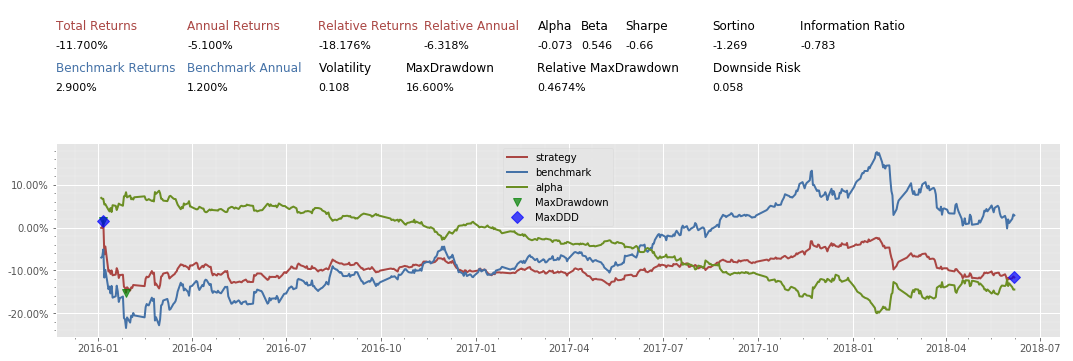

In [146]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = [
        u'Microsoft Yahei',
        u'Heiti SC',
        u'Heiti TC',
        u'STHeiti',
        u'WenQuanYi Zen Hei',
        u'WenQuanYi Micro Hei',
        u"文泉驿微米黑",
        u'SimHei',
    ] + rcParams['font.sans-serif']
rcParams['axes.unicode_minus'] = False

use_chinese_fonts = True
font = findfont(FontProperties(family=['sans-serif']))
if "/matplotlib/" in font:
    use_chinese_fonts = False
    
summary = result["summary"]

title = 'backTestResult'

portfolio = result["portfolio"]
benchmark_portfolio = result.get("benchmark_portfolio")
index = portfolio.index
portfolio_value = portfolio.unit_net_value * portfolio.units
xs = portfolio_value.values
rt = portfolio.unit_net_value.values
max_dd_end = np.argmax(np.maximum.accumulate(xs) / xs)
if max_dd_end == 0:
    max_dd_end = len(xs) - 1
max_dd_start = np.argmax(xs[:max_dd_end]) if max_dd_end > 0 else 0

max_ddd_start_day, max_ddd_end_day = max_ddd(xs)
max_dd_info = "MaxDD  {}~{}, {} days".format(index[max_dd_start], index[max_dd_end],
                                                 (index[max_dd_end] - index[max_dd_start]).days)
max_dd_info += "\nMaxDDD {}~{}, {} days".format(index[max_ddd_start_day], index[max_ddd_end_day],
                                                    (index[max_ddd_end_day] - index[max_ddd_start_day]).days)
plt.style.use('ggplot')
red = "#aa4643"
blue = "#4572a7"
black = "#000000"
green = "#6B8E23"

plots_area_size = 0
if "plots" in result:
    plots_area_size = 5
    
figsize = (18, 6 + int(plots_area_size * 0.9))
plt.figure(title, figsize=figsize)
max_height = 10 + plots_area_size
gs = gridspec.GridSpec(max_height, 8)

ax = plt.subplot(gs[:3, -1:])
ax.axis("off")   
ax.autoscale_view()

font_size = 12
value_font_size = 11
label_height, value_height = 0.8, 0.6
label_height2, value_height2 = 0.35, 0.15

portfolio_value = portfolio.unit_net_value * portfolio.units
portfolio_df = pd.DataFrame(portfolio_value)
max_values = 0 
pvmax_dd = []
for k, v in portfolio_df.iterrows():
    max_values = max(v.values[0],max_values)
    dd = (v.values[0] - max_values) / max_values
    pvmax_dd.append(dd)
    
benchmark_value = benchmark_portfolio.unit_net_value * portfolio.units
benchmark_df = pd.DataFrame(benchmark_value)
max_values = 0 
bvmax_dd = []
for k, v in benchmark_df.iterrows():
    max_values = max(v.values[0],max_values)
    dd = (v.values[0] - max_values) / max_values
    bvmax_dd.append(dd)
rmdd = abs(np.array(pvmax_dd).min() - np.array(bvmax_dd).min()) / 6

def _(txt):
    return gettext(txt) if use_chinese_fonts else txt


#相对收益及年化收益

relative_value = np.power(1 + result['summary']['annualized_returns'],3) - np.power(
    1 + result['summary']['benchmark_annualized_returns'],3)
relative_annual = relative_value / 725 * 252

fig_data = [
        (0.00, label_height, value_height, _(u"Total Returns"), "{0:.3%}".format(
                    summary["total_returns"]), red, black),
        (0.15, label_height, value_height, _(u"Annual Returns"), "{0:.3%}".format(
                    summary["annualized_returns"]), red, black),
        
        (0.30, label_height, value_height, _(u"Relative Returns"), "{0:.3%}".format(
                    relative_value), red, black),
        (0.42, label_height, value_height, _(u"Relative Annual"), "{0:.3%}".format(
                    relative_annual), red, black),
    

        (0.55, label_height, value_height, _(u"Alpha"), "{0:.4}".format(summary["alpha"]), black, black),
        (0.60, label_height, value_height, _(u"Beta"), "{0:.4}".format(summary["beta"]), black, black),
        (0.65, label_height, value_height, _(u"Sharpe"), "{0:.4}".format(summary["sharpe"]), black, black),
        (0.75, label_height, value_height, _(u"Sortino"), "{0:.4}".format(summary["sortino"]), black, black),
        (0.85, label_height, value_height, _(u"Information Ratio"), "{0:.4}".format(
                    summary["information_ratio"]), black, black),

        (0.00, label_height2, value_height2, _(u"Benchmark Returns"), "{0:.3%}".format(
                    summary.get("benchmark_total_returns", 0)), blue,
         black),
        (0.15, label_height2, value_height2, _(u"Benchmark Annual"), "{0:.3%}".format(
                    summary.get("benchmark_annualized_returns", 0)),
         blue, black),
        (0.30, label_height2, value_height2, _(u"Volatility"), "{0:.4}".format(
                    summary["volatility"]), black, black),
        (0.40, label_height2, value_height2, _(u"MaxDrawdown"), "{0:.3%}".format(
                    summary["max_drawdown"]), black, black),
        (0.55, label_height2, value_height2, _(u"Relative MaxDrawdown"), "{0:.4%}".format(rmdd), black, black),
        (0.75, label_height2, value_height2, _(u"Downside Risk"), "{0:.4}".format(
                    summary["downside_risk"]), black, black),
]

ax = plt.subplot(gs[:3, :-1])
ax.axis("off")

for x, y1, y2, label, value, label_color, value_color in fig_data:
    ax.text(x, y1, label, color=label_color, fontsize=font_size)
    ax.text(x, y2, value, color=value_color, fontsize=value_font_size)
#for x, y1, y2, label, value, label_color, value_color in [
#        (0.85, label_height2, value_height2, _(u"MaxDD/MaxDDD"), max_dd_info, black, black)]:
#    ax.text(x, y1, label, color=label_color, fontsize=font_size)
#    ax.text(x, y2, value, color=value_color, fontsize=8)
    
# strategy vs benchmark
ax = plt.subplot(gs[4:10, :])

ax.get_xaxis().set_minor_locator(ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', linewidth=.2)
ax.grid(b=True, which='major', linewidth=1)


# plot two lines
ax.plot(portfolio["unit_net_value"] - 1.0, label=_(u"strategy"), alpha=1, linewidth=2, color=red)
if benchmark_portfolio is not None:
    ax.plot(benchmark_portfolio["unit_net_value"] - 1.0, label=_(u"benchmark"), alpha=1, linewidth=2, color=blue)
    alpha_portfolio = portfolio["unit_net_value"] - benchmark_portfolio["unit_net_value"]
    ax.plot(alpha_portfolio, label=_(u"alpha"), alpha=1, linewidth=2, color=green)
    
# plot MaxDD/MaxDDD
ax.plot([index[max_dd_end], index[max_dd_start]], [rt[max_dd_end] - 1.0, rt[max_dd_start] - 1.0],
            'v', color='Green', markersize=8, alpha=.7, label=_(u"MaxDrawdown"))
ax.plot([index[max_ddd_start_day], index[max_ddd_end_day]],
            [rt[max_ddd_start_day] - 1.0, rt[max_ddd_end_day] - 1.0], 'D', color='Blue', markersize=8, alpha=.7,
            label=_(u"MaxDDD"))


# place legend
leg = plt.legend(loc="best")
leg.get_frame().set_alpha(0.5)

# manipulate axis
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.2f}%'.format(x * 100) for x in vals])


if "plots" in result:
    plots_df = result["plots"]
    ax2 = plt.subplot(gs[11:, :])
    for column in plots_df.columns:
        ax2.plot(plots_df[column], label=column)

    leg = plt.legend(loc="best")
    leg.get_frame().set_alpha(0.5)
    
plt.show()


In [113]:
pd.DataFrame([result['summary']])

,STOCK,alpha,annualized_returns,benchmark_annualized_returns,benchmark_total_returns,beta,cash,downside_risk,end_date,information_ratio,...,sortino,start_date,strategy_file,strategy_name,total_returns,total_value,tracking_error,unit_net_value,units,volatility
0,100000000.0,-0.053,-0.032,0.012,0.029,0.527,4.840798e+07,0.06,2018-06-06,-0.555,...,-0.904,2016-01-04,strategy.py,strategy,-0.074,9.260541e+07,0.098,0.926,100000000.0,0.106


In [114]:
trades = pd.DataFrame(result['trades'])
trades

,commission,exec_id,last_price,last_quantity,order_book_id,order_id,position_effect,side,symbol,tax,trading_datetime,transaction_cost
datetime,,,,,,,,,,,,
2016-01-04 15:00:00,1693.744000,15708733930000,8.84,239500.0,000027.XSHE,15708733860003,OPEN,BUY,深圳能源,0.00000,2016-01-04 15:00:00,1693.744000
2016-01-04 15:00:00,1723.644000,15708733930001,19.05,113100.0,000039.XSHE,15708733860006,OPEN,BUY,中集集团,0.00000,2016-01-04 15:00:00,1723.644000
2016-01-04 15:00:00,825.372000,15708733930002,11.35,90900.0,000046.XSHE,15708733860009,OPEN,BUY,泛海控股,0.00000,2016-01-04 15:00:00,825.372000
2016-01-04 15:00:00,1409.916800,15708733930003,29.72,59300.0,000333.XSHE,15708733860016,OPEN,BUY,美的集团,0.00000,2016-01-04 15:00:00,1409.916800
2016-01-04 15:00:00,1652.108800,15708733930004,6.74,306400.0,000539.XSHE,15708733860023,OPEN,BUY,粤电力A,0.00000,2016-01-04 15:00:00,1652.108800
2016-01-04 15:00:00,2473.340800,15708733930005,20.26,152600.0,000651.XSHE,15708733860028,OPEN,BUY,格力电器,0.00000,2016-01-04 15:00:00,2473.340800
2016-01-04 15:00:00,1647.379200,15708733930006,28.68,71800.0,000738.XSHE,15708733860033,OPEN,BUY,航发控制,0.00000,2016-01-04 15:00:00,1647.379200
2016-01-04 15:00:00,2018.688800,15708733930007,25.67,98300.0,000858.XSHE,15708733860038,OPEN,BUY,五粮液,0.00000,2016-01-04 15:00:00,2018.688800
2016-01-04 15:00:00,1683.992800,15708733930008,25.27,83300.0,000999.XSHE,15708733860044,OPEN,BUY,华润三九,0.00000,2016-01-04 15:00:00,1683.992800


In [115]:
account = pd.DataFrame(result['stock_account'])
account

,cash,dividend_receivable,market_value,total_value,transaction_cost
date,,,,,
2016-01-04,4.591365e+04,0.0,9.987419e+07,9.992010e+07,79899.350
2016-01-05,4.591365e+04,0.0,1.007473e+08,1.007932e+08,0.000
2016-01-06,4.591365e+04,0.0,1.027275e+08,1.027735e+08,0.000
2016-01-07,4.591365e+04,0.0,9.555152e+07,9.559744e+07,0.000
2016-01-08,4.591365e+04,0.0,9.766977e+07,9.771569e+07,0.000
2016-01-11,7.018278e+07,0.0,2.198808e+07,9.217087e+07,172752.551
2016-01-12,7.018278e+07,0.0,2.226031e+07,9.244310e+07,0.000
2016-01-13,7.018278e+07,0.0,2.158267e+07,9.176545e+07,0.000
2016-01-14,7.018278e+07,0.0,2.220508e+07,9.238786e+07,0.000


In [116]:
positions = pd.DataFrame(result['stock_positions'])
positions

,avg_price,last_price,market_value,order_book_id,quantity,symbol
date,,,,,,
2016-01-04,8.84,8.84,2117180.0,000027.XSHE,239500.0,深圳能源
2016-01-04,19.05,19.05,2154555.0,000039.XSHE,113100.0,中集集团
2016-01-04,11.35,11.35,1031715.0,000046.XSHE,90900.0,泛海控股
2016-01-04,29.72,29.72,1762396.0,000333.XSHE,59300.0,美的集团
2016-01-04,6.74,6.74,2065136.0,000539.XSHE,306400.0,粤电力A
2016-01-04,20.26,20.26,3091676.0,000651.XSHE,152600.0,格力电器
2016-01-04,28.68,28.68,2059224.0,000738.XSHE,71800.0,航发控制
2016-01-04,25.67,25.67,2523361.0,000858.XSHE,98300.0,五粮液
2016-01-04,25.27,25.27,2104991.0,000999.XSHE,83300.0,华润三九


In [119]:
positions.groupby(level=['date']).count()

,avg_price,last_price,market_value,order_book_id,quantity,symbol
date,,,,,,
2016-01-04,45,45,45,45,45,45
2016-01-05,45,45,45,45,45,45
2016-01-06,45,45,45,45,45,45
2016-01-07,45,45,45,45,45,45
2016-01-08,45,45,45,45,45,45
2016-01-11,55,55,55,55,55,55
2016-01-12,37,37,37,37,37,37
2016-01-13,37,37,37,37,37,37
2016-01-14,37,37,37,37,37,37
